# Import

In [1]:
import sys
import warnings
import gc
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import math
from functools import partial
import scipy as sp

from sklearn import *
import sklearn

import lightgbm as lgbm
import catboost as ctbst

import matplotlib.pyplot as plt
import seaborn as sns
import plotly
from plotly.offline import *
import plotly.plotly as py
from plotly.graph_objs import *
from pylab import *
init_notebook_mode(connected=True)

import multiprocessing as mp
import tqdm

from typing import List, NoReturn, Union, Tuple, Optional, Text, Generic, Callable, Dict
import tsfresh
import joblib

from time import time

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

# Load

In [2]:
random_state = 1
path = r'D:\Python\Kaggle\Ion\\'
n_threads = mp.cpu_count()-1 #th.active_count()

print('Reading training, testing and submission data...')

df_train = pd.read_csv(path + 'train_clean.csv')
df_test = pd.read_csv(path + 'test_clean.csv')

submission = pd.read_csv(path + 'sample_submission.csv', dtype={'time':str})

print('Train set has {} rows and {} columns'.format(df_train.shape[0], df_train.shape[1]))
print('Test set has {} rows and {} columns'.format(df_test.shape[0], df_test.shape[1]))

# Set

In [3]:
def ram_usage():
    
    ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars']
    return sorted(
        [
            (x, sys.getsizeof(globals().get(x))) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars
        ],
        key=lambda x: x[1],
        reverse=True
    )

def data_skew(df):
    
    sk_df = pd.DataFrame(
        [
            {
                'column': c,
                'uniq': df[c].nunique(),
                'skewness': df[c].value_counts(normalize=True).values[0] * 100
            } for c in df.columns
        ]
    )
    sk_df = sk_df.sort_values('skewness', ascending=False)
    return sk_df

def get_outliers(df, n, features):
    """
    Для обнаружения выбросов, которые определяют межквартильный диапазон, 
    заключенный между 1-м и 3-м квартилями значений распределения (IQR). 
    Выброс-это строка, которая имеет значение объекта за пределами (IQR +- шаг выброса).
    Принимает фрейм данных df и возвращает список индексов
    соответствующие наблюдениям, содержащим более n выбросов согласно к методу Тьюки.
    """

    df = df.copy()

    outlier_indices = []
    from collections import Counter
    # iterate over features(columns)
    for col in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col],75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1

        # outlier step
        outlier_step = 1.5 * IQR

        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index

        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col) # mapper

    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices) # reducer
    # получаем список строк, в которых перекосы по определенном числу фичей вне доверительного интервала
    multiple_outliers = list(k for k, v in outlier_indices.items() if v > n)

    return multiple_outliers

def get_corr_features(df, features, perc=.95, is_print=False):
    
    def set_to_list(cols, excepted):
        return list(set(cols) - set(excepted))
    # Identify Highly Correlated Features
    # Create correlation matrix
    corr_matrix = df[features].corr().abs()
    # Select upper triangle of correlation matrix
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
    # Find index of feature columns with correlation greater than 0.95/perc var
    to_drop_corr_feat = [column for column in upper.columns if any(upper[column] > perc)]
    if is_print:
        print(', '.join(to_drop_corr_feat))
    # Drop Marked Features
    # df.drop(to_drop_corr_feat, axis=1, inplace = True)
    features = set_to_list(features, to_drop_corr_feat)
    
    return to_drop_corr_feat

In [4]:
def reduce_mem_usage(df: pd.DataFrame,
                     columns: list,
                     verbose: bool = True) -> pd.DataFrame:
    
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2

    for col in columns:
        
        col_type = df[col].dtypes

        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()

            if str(col_type)[:3] == 'int':
                if (c_min > np.iinfo(np.int8).min
                        and c_max < np.iinfo(np.int8).max):
                    df[col] = df[col].astype(np.int8)
                elif (c_min > np.iinfo(np.int16).min
                      and c_max < np.iinfo(np.int16).max):
                    df[col] = df[col].astype(np.int16)
                elif (c_min > np.iinfo(np.int32).min
                      and c_max < np.iinfo(np.int32).max):
                    df[col] = df[col].astype(np.int32)
                elif (c_min > np.iinfo(np.int64).min
                      and c_max < np.iinfo(np.int64).max):
                    df[col] = df[col].astype(np.int64)
            else:
#                 if (c_min > np.finfo(np.float16).min
#                         and c_max < np.finfo(np.float16).max):
#                     df[col] = df[col].astype(np.float16)
                if (c_min > np.finfo(np.float16).min
                      and c_max < np.finfo(np.float32).max):
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    reduction = (start_mem - end_mem) / start_mem

    msg = f'Mem. usage decreased to {end_mem:5.2f} MB ({reduction * 100:.1f} % reduction)'
    if verbose:
        print(msg)

    return df

def plot_vc(x, y_train, y_valid, xlabel='DEPTH', title='RMSE'):
    '''
    plt.title('Validation curve')
    plt.xlabel('depth')
    plt.ylabel('neg_mean_squared_log_error')
    sns.lineplot(
        x=x,
        y=y_train,
        label='Train'
    )

    sns.lineplot(
        x=x,
        y=y_valid,
        label='Valid'
    )
    
    plt.show()
    '''
    train = Scatter(
        x=x,
        y=y_train,
        name='Train',
        line=dict(
            color='rgba(240, 65, 65, .9)',
            shape='hvh'
        ),
        mode='lines+markers',
        connectgaps=True
    )
    
    valid = Scatter(
        x=x,
        y=y_valid,
        name='Valid',
        line=dict(
            color='rgba(65, 100, 240, .9)',
            shape='hvh'
        ),
        mode='lines+markers',
        connectgaps=True
    )
    
    data = [train, valid]
    
    layout = dict(
        title='Validation curve',
        legend=dict(
            x=.9,
            y=1
        ),
        yaxis = dict(
            title=title,
            autorange=False,
            range=[0, max(y_valid)*1.1],
            #tickformat='0.0%'
        ),
        xaxis = dict(
            title=xlabel,
            dtick=1
        ),
        showlegend=True
    )
    
    fig = dict(
        data=data,
        layout=layout
    )
    
    iplot(fig)

In [5]:
class OptimizedRounder(object):
    """
    An optimizer for rounding thresholds
    to maximize F1 (Macro) score
    # https://www.kaggle.com/naveenasaithambi/optimizedrounder-improved
    """
    def __init__(self):
        self.coef_ = 0

    def _f1_loss(self, coef, X, y):
        """
        Get loss according to
        using current coefficients

        :param coef: A list of coefficients that will be used for rounding
        :param X: The raw predictions
        :param y: The ground truth labels
        """
        X_p = pd.cut(X, [-np.inf] + list(np.sort(coef)) + [np.inf], labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

        return -sklearn.metrics.f1_score(y, X_p, average = 'macro')

    def fit(self, X, y):
        """
        Optimize rounding thresholds

        :param X: The raw predictions
        :param y: The ground truth labels
        """
        loss_partial = partial(self._f1_loss, X=X, y=y)
        initial_coef = [0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5]
        self.coef_ = sp.optimize.minimize(loss_partial, initial_coef, method='nelder-mead')

    def predict(self, X, coef):
        """
        Make predictions with specified thresholds

        :param X: The raw predictions
        :param coef: A list of coefficients that will be used for rounding
        """
        return pd.cut(X, [-np.inf] + list(np.sort(coef)) + [np.inf], labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

    def coefficients(self):
        """
        Return the optimized coefficients
        """
        return self.coef_['x']

In [6]:
def features(df):
    
    df = df.sort_values(by=['time']).reset_index(drop=True)
    #df.index = ((df.time * 10_000) - 1).to_numpy()
    df.index = range(df.shape[0])
    # делим датасет на части
    df['batch'] = df.index // 50_000
    # размечаем строки внутри группы
    df['batch_index'] = df.index  - (df.batch * 50_000)
    # создаем подгруппы по 5 тысяч строк для всего датасета (не используется)
    df['batch_slices'] = df['batch_index']  // 5_000
    # создаем подгруппы по 5 тысяч строк внутри 50 групп
    df['batch_slices2'] = df.apply(
        lambda r: '_'.join([str(r['batch']).zfill(3), str(r['batch_slices']).zfill(3)]),
        axis=1
    )
    
    # все собирает в словаре
    for c in ['batch', 'batch_slices2']:
        
        d = {}
        d['mean_' + c] = df.groupby([c])['signal'].mean()
        d['median_' + c] = df.groupby([c])['signal'].median()
        d['max_' + c] = df.groupby([c])['signal'].max()
        d['min_' + c] = df.groupby([c])['signal'].min()
        d['std_' + c] = df.groupby([c])['signal'].std()
        # средняя разница в одно значение
        d['mean_abs_chg_' + c] = df.groupby([c])['signal'].apply(lambda x: np.mean(np.abs(np.diff(x))))
        d['abs_max_' + c] = df.groupby([c])['signal'].apply(lambda x: np.max(np.abs(x)))
        d['abs_min_' + c] = df.groupby([c])['signal'].apply(lambda x: np.min(np.abs(x)))
        
        # маппит по индексу
        for v in d:
            
            df[v] = df[c].map(d[v].to_dict())
            
        df['range_' + c] = df['max_' + c] - df['min_' + c]
        df['maxtomin_' + c] = df['max_' + c] / df['min_' + c]
        df['abs_avg_' + c] = (df['abs_min_' + c] + df['abs_max_' + c]) / 2
    
    # предыдущие значения сигнала
    df['signal_shift_+1'] = [0,] + list(df['signal'].values[:-1])
    # последующие значения сигнала
    df['signal_shift_-1'] = list(df['signal'].values[1:]) + [0]
    
    # удаляем первое и последнее из расчета среднего
    for i in df[df['batch_index']==0].index:
        
        df['signal_shift_+1'][i] = np.nan
        
    for i in df[df['batch_index']==49999].index:
        
        df['signal_shift_-1'][i] = np.nan

    # считаем разницу для всех фичей
    for c in [c1 for c1 in df.columns if c1 not in ['time', 'signal', 'open_channels', 'batch', 'batch_index', 'batch_slices', 'batch_slices2']]:
        
        df[c + '_msignal'] = df[c] - df['signal']
        
    return df

In [16]:
def lgbm_metric(preds, dtrain):
    
    labels = dtrain.get_label()
    preds = np.round(np.clip(preds, 0, 10)).astype(int)
    #score = sklearn.metrics.cohen_kappa_score(labels, preds, weights = 'quadratic')
    score = sklearn.metrics.f1_score(labels, preds, average='macro')
    
    return ('F1 Macro', score, True)

In [17]:
def visual_batching(df: pd.DataFrame,
                        batch_slices : List,
                        train: bool = True) -> pd.DataFrame:

    tr_visual_idx = [0, 500000, 600000, 1000000, 1500000, 2000000, 2500000, 3000000, 3500000, 4000000, 4500000, 5000000]
    te_visual_idx = [0, 100000, 200000, 300000, 400000, 500000, 600000, 700000, 800000, 900000, 1000000, 1500000, 2000000]
    tr_data_type = [0, 0, 0, 1, 2, 4, 3, 1, 2, 3, 4]
    te_data_type = [0, 2, 3, 0, 1, 4, 3, 4, 0, 2, 0, 0]
        
    idx = tr_visual_idx if train else te_visual_idx
    type_ = tr_data_type if train else te_data_type
    s = idx; t = type_
    visual_batch = np.zeros((s[-1],), dtype=np.int64)
    visual_type = np.zeros((s[-1],), dtype=np.int64)
    df['visual_batch'] = 0
    df['visual_type'] = 0

    for i, j in zip(range(len(s) - 1), t):

        df.loc[s[i]:s[i+1],'visual_batch'] = i
        df.loc[s[i]:s[i+1],'visual_type'] = j

    # размечаем строки внутри группы
    df['visual_batch_index'] = 0

    for v_b in set(df['visual_batch']):

        df.loc[df[df['visual_batch']==v_b].index, 'visual_batch_index'] = range(df[df['visual_batch']==v_b].shape[0])

    for b_s in batch_slices:
        
        # создаем подгруппы для всего датасета (не используется для фичей)
        df['visual_batch_slice'] = df['visual_batch_index']  // b_s

        # создаем подгруппы
        df['visual_subbatch_' + str(b_s)] = df.apply(
            lambda r: '_'.join([str(r['visual_batch']).zfill(3), str(r['visual_batch_slice']).zfill(3)]),
            axis=1
        )

    df.drop(
        labels=['visual_batch_slice'],
        axis=1,
        inplace=True
    )
        
    return df

In [9]:
# функция разбивки на батчи
def batching(df : pd.DataFrame,
             batch_size : int,
             batch_slices : List) -> pd.DataFrame:
    
    df = df.sort_values(by=['time']).reset_index(drop=True)
    df.index = range(df.shape[0])
    # делим датасет на части
    df['batch'] = df.index // batch_size
    # размечаем строки внутри группы
    df['batch_index'] = df.index  - (df['batch'] * batch_size)
    
    #df['batch'] += 1

    for b_s in batch_slices:
        
        # создаем подгруппы для всего датасета (не используется для фичей)
        df['batch_slice'] = df['batch_index']  // b_s
        #df['batch_slice'] += 1
        # создаем подгруппы
        df['subbatch_' + str(b_s)] = df.apply(
            lambda r: '_'.join([str(r['batch']).zfill(3), str(r['batch_slice']).zfill(3)]),
            axis=1
        )

    df.drop(
        labels=['batch_slice'],
        axis=1,
        inplace=True
    )
    #df['batch_index'] += 1
        
    return df

In [10]:
from pykalman import KalmanFilter

def Kalman1D(observations, damping=1):
    # To return the smoothed time series data
    observation_covariance = damping
    initial_value_guess = observations[0]
    transition_matrix = 1
    transition_covariance = 0.1
    initial_value_guess
    
    kf = KalmanFilter(
            initial_state_mean=initial_value_guess,
            initial_state_covariance=observation_covariance,
            observation_covariance=observation_covariance,
            transition_covariance=transition_covariance,
            transition_matrices=transition_matrix
        )
    pred_state, state_cov = kf.smooth(observations)
    
    return pred_state

In [11]:
# signal processing features
def calc_gradients(s, n_grads=4, column='signal'):
    '''
    Calculate gradients for a pandas series. Returns the same number of samples
    '''
    grads = pd.DataFrame()
    
    g = s.to_numpy()
    
    for i in range(n_grads):
        
        g = np.gradient(g)
        grads[column + '_grad_' + str(i+1)] = g
        
    return grads

def calc_low_pass(s, n_filts=10, column='signal'):
    '''
    Applies low pass filters to the signal. Left delayed and no delayed
    '''
    wns = np.logspace(-2, -0.3, n_filts)
    
    low_pass = pd.DataFrame()
    x = s.to_numpy()
    
    for wn in wns:
        
        b, a = sp.signal.butter(1, Wn=wn, btype='low')
        zi = sp.signal.lfilter_zi(b, a)
        low_pass[column + '_lowpass_lf_' + str('%.4f' %wn)] = sp.signal.lfilter(b, a, x, zi=zi*x[0])[0]
        low_pass[column + '_lowpass_ff_' + str('%.4f' %wn)] = sp.signal.filtfilt(b, a, x)
        
    return low_pass

def calc_high_pass(s, n_filts=10, column='signal'):
    '''
    Applies high pass filters to the signal. Left delayed and no delayed
    '''
    wns = np.logspace(-2, -0.1, n_filts)
    
    high_pass = pd.DataFrame()
    x = s.to_numpy()
    
    for wn in wns:
        
        b, a = sp.signal.butter(1, Wn=wn, btype='high')
        zi = sp.signal.lfilter_zi(b, a)
        high_pass[column + '_highpass_lf_' + str('%.4f' %wn)] = sp.signal.lfilter(b, a, x, zi=zi*x[0])[0]
        high_pass[column + '_highpass_ff_' + str('%.4f' %wn)] = sp.signal.filtfilt(b, a, x)
        
    return high_pass

def calc_ewm(s, windows=[10, 50, 100, 500, 1000, 5000, 10000], column='signal'):
    '''
    Calculates exponential weighted functions
    '''
    ewm = pd.DataFrame()
    
    for w in windows:
        
        ewm[column + '_ewm_mean_' + str(w)] = s.ewm(span=w, min_periods=1).mean()
        ewm[column + '_ewm_std_' + str(w)] = s.ewm(span=w, min_periods=1).std()
        
    # add zeros when na values (std)
    ewm = ewm.fillna(value=0)
        
    return ewm


def add_features(s, column):
    '''
    All calculations together
    '''
    
    gradients = calc_gradients(s)
    low_pass = calc_low_pass(s)
    high_pass = calc_high_pass(s)
    ewm = calc_ewm(s)
    
    return pd.concat([s, gradients, low_pass, high_pass, ewm], axis=1)

In [12]:
def normalized_feat(df : pd.DataFrame,
                    batch_column : str,
                    column : str) -> pd.DataFrame:
    '''
    Divide the signal in bags of "signal_size".
    Normalize the data dividing it by 15.0
    '''
    # normalize
    #s /= 15.0
    
    ls = []

    for b in tqdm.tqdm_notebook(set(df[batch_column])):

        #sig = s[i*signal_size:(i+1)*signal_size].copy().reset_index(drop=True)
        sig = df[df[batch_column]==b][column] / 15
        sig.reset_index(drop=True, inplace=True)
        sig_featured = add_features(sig, column)
        ls.append(sig_featured)

    ls = pd.concat(
        objs=ls,
        axis=0
    ).drop(labels=[column], axis=1).reset_index(drop=True)
    
    df = pd.concat(
       objs=[df, ls],
       axis=1
    )
        
    return df

In [13]:
def filter_wave(x, cutoff=(-1, -1), N=4, filtering='lfilter'):

    assert x.ndim == 1
    
    output = 'sos' if filtering == 'sos' else 'ba'
    
    if cutoff[0] <= 0 and cutoff[1] <= 0:
        # Do not apply filter
        return x
    
    elif cutoff[0] <= 0 and cutoff[1] > 0:
        # Apply low pass filter
        output = sp.signal.butter(N, Wn=cutoff[1]/len(x), btype='lowpass', output=output)
        
    elif cutoff[0] > 0 and cutoff[1] <= 0:
        # Apply high pass filter
        output = sp.signal.butter(N, Wn=cutoff[0]/len(x), btype='highpass', output=output)
        
    else:
        # Apply band pass filter
        output = sp.signal.butter(N, Wn=(cutoff[0]/len(x), cutoff[1]/len(x)), btype='bandpass', output=output)

    if filtering == 'lfilter':
        b, a = output
        return sp.signal.lfilter(b, a, x)
    
    elif filtering == 'filtfilt':
        b, a = output
        return sp.signal.filtfilt(b, a, x)
    
    elif filtering == 'sos':
        sos = output
        return sp.signal.sosfilt(sos, x)
    
    else:
        
        raise ValueError("[ERROR] Unexpected value filtering={}".format(filtering))
        
def trend_feature(arr, abs_values=False):
    
    idx = np.array(range(len(arr)))
    
    if abs_values:
        
        arr = np.abs(arr)
        
    lr = sklearn.linear_model.LinearRegression()
    lr.fit(idx.reshape(-1, 1), arr)
    
    return lr.coef_[0]

def classic_sta_lta(x, length_sta, length_lta):
    
    sta = np.cumsum(x ** 2)

    # Convert to float
    sta = np.require(sta, dtype=np.float)

    # Copy for LTA
    lta = sta.copy()

    # Compute the STA and the LTA
    sta[length_sta:] = sta[length_sta:] - sta[:-length_sta]
    sta /= length_sta
    lta[length_lta:] = lta[length_lta:] - lta[:-length_lta]
    lta /= length_lta

    # Pad zeros
    sta[:length_lta - 1] = 0

    # Avoid division by zero by setting zero values to tiny float
    dtiny = np.finfo(0.0).tiny
    idx = lta < dtiny
    lta[idx] = dtiny

    return sta / lta

def calc_change_rate(x):
    
    change = (np.diff(x) / x[:-1]).to_numpy()
    change = change[np.nonzero(change)[0]]
    change = change[~np.isnan(change)]
    change = change[change != -np.inf]
    change = change[change != np.inf]
    
    return np.mean(change)

def calc_change_rate_numpy(x):
    
    change = (np.diff(x) / x[:-1])
    change = change[np.nonzero(change)[0]]
    change = change[~np.isnan(change)]
    change = change[change != -np.inf]
    change = change[change != np.inf]
    
    return np.mean(change)

In [14]:
# функция для расчета смещенных признаков
def lag_feat(df : pd.DataFrame,
             batch_column: str,
             shift_sizes : List,
             window_sizes : List,
             column : str) -> pd.DataFrame:
    
    #smooth_sig = lambda x: filter_wave(x, cutoff=(0, 100), filtering='filtfilt')
    #df[column + '_baseline'] = np.concatenate(df.groupby(['visual_batch'])[column].apply(smooth_sig))

    cur_time = time()
    
    # проходим по сдвигам вперед и назад
    for shift_size in shift_sizes:
        
        # залепляет nan на случай, если такие значения есть в ряду
        df[column + '_shift_pos_' + str(shift_size)] = df.groupby(by=[batch_column])[column].shift(shift_size).fillna(0)
        df[column + '_shift_neg_' + str(shift_size)] = df.groupby(by=[batch_column])[column].shift(-1 * shift_size).fillna(0)

    # также проходим по сдвигам процентных изменений
    # дальше их сдвигать не стал - попробую позже

    for shift_size in shift_sizes:

        df[column + '_pct_change_' + str(shift_size) + '_pos'] = df.groupby(by=[batch_column])[column].pct_change(shift_size).fillna(0)
        df[column + '_pct_change_' + str(shift_size) + '_neg'] = df.groupby(by=[batch_column])[column].pct_change(-1 * shift_size).fillna(0)
        
    print('shift features are passed!')
    print('seconds elapced', time() - cur_time)
    cur_time = time()
        
    # смещаемся на значение назад/вперед и рассчитываем агрегатное значение в окне
    for window in tqdm.tqdm_notebook(window_sizes):

        print('-'*10)
        print('window', window)
        print('move backward')

        # обявляем один раз, чтобы не считать в каждой функции
        values_back = df.groupby(by=[batch_column])[column].shift(1).rolling(window)
        values_forward = df.groupby(by=[batch_column])[column].shift(- window - 1).rolling(window)

        # окно назад
        df[column + '_sum_' + str(window) + '_back'] = values_back.apply(lambda x: np.sum(x))
        df[column + '_mean_' + str(window) + '_back'] = values_back.apply(lambda x: np.mean(x))
        df[column + '_median_' + str(window) + '_back'] = values_back.apply(lambda x: np.median(x))
        df[column + '_min_' + str(window) + '_back'] = values_back.apply(lambda x: np.min(x))
        df[column + '_max_' + str(window) + '_back'] = values_back.apply(lambda x: np.max(x))
        df[column + '_var_' + str(window) + '_back'] = values_back.apply(lambda x: np.var(x))
        df[column + '_std_' + str(window) + '_back'] = values_back.apply(lambda x: np.std(x))
        df[column + '_skew_' + str(window) + '_back'] = values_back.apply(lambda x: pd.Series(x).skew())
        df[column + '_mad_' + str(window) + '_back'] = values_back.apply(lambda x: pd.Series(x).mad())
        df[column + '_kurtosis_' + str(window) + '_back'] = values_back.apply(lambda x: pd.Series(x).kurtosis())
        df[column + '_trend_' + str(window) + '_back'] = values_back.apply(lambda x: trend_feature(x, abs_values=False))

        print('-'*10)
        print('standart features are generated!')
        print('seconds elapced', time() - cur_time)
        cur_time = time()

        percentiles = [1, 5, 10, 20, 25, 30, 40, 50, 60, 70, 75, 80, 90, 95, 99]

        for p in percentiles:

            df[column + f'_percentile{p}' + '_' + str(window) + '_back'] = values_back.apply(lambda x: np.percentile(x, p))
            df[column + f'_quantile00{p}' + '_' + str(window) + '_back'] = values_back.apply(lambda x: np.quantile(x, p/100))

        print('-'*10)
        print('percentile and quantile features are generated!')
        print('seconds elapced', time() - cur_time)
        cur_time = time()

        df[column + '_abs_signal_sum_' + str(window) + '_back'] = values_back.apply(lambda x: np.sum(np.abs(x)))
        df[column + '_abs_signal_mean_' + str(window) + '_back'] = values_back.apply(lambda x: np.mean(np.abs(x)))
        df[column + '_abs_signal_median_' + str(window) + '_back'] = values_back.apply(lambda x: np.median(np.abs(x)))
        df[column + '_abs_signal_min_' + str(window) + '_back'] = values_back.apply(lambda x: np.min(np.abs(x)))
        df[column + '_abs_signal_max_' + str(window) + '_back'] = values_back.apply(lambda x: np.max(np.abs(x)))
        df[column + '_abs_signal_var_' + str(window) + '_back'] = values_back.apply(lambda x: np.var(np.abs(x)))
        df[column + '_abs_signal_std_' + str(window) + '_back'] = values_back.apply(lambda x: np.std(np.abs(x)))
        df[column + '_abs_skew_' + str(window) + '_back'] = values_back.apply(lambda x: pd.Series(np.abs(x)).skew())
        df[column + '_abs_mad_' + str(window) + '_back'] = values_back.apply(lambda x: pd.Series(np.abs(x)).mad())
        df[column + '_abs_kurtosis_' + str(window) + '_back'] = values_back.apply(lambda x: pd.Series(np.abs(x)).kurtosis())
        df[column + '_abs_trend_' + str(window) + '_back'] = values_back.apply(lambda x: trend_feature(x, abs_values=True))

        print('-'*10)
        print('standart abs features are generated!')
        print('seconds elapced', time() - cur_time)
        cur_time = time()

        for p in percentiles:

            df[column + f'_abs_percentile{p}' + '_' + str(window) + '_back'] = values_back.apply(lambda x: np.percentile(np.abs(x), p))
            df[column + f'_abs_quantile00{p}' + '_' + str(window) + '_back'] = values_back.apply(lambda x: np.quantile(np.abs(x), p/100))

        print('-'*10)
        print('percentile and quantile abs features generated!')
        print('seconds elapced', time() - cur_time)
        cur_time = time()

        min_max = (df[column] - df[column + '_min_' + str(window) + '_back']) / (df[column + '_max_' + str(window) + '_back'] - df[column + '_min_' + str(window) + '_back'])
        df[column + '_norm_' + str(window) + '_back'] = min_max * (np.floor(df[column + '_max_' + str(window) + '_back']) - np.ceil(df[column + '_min_' + str(window) + '_back']))
        df[column + '_mean_abs_chg_' + str(window) + '_back'] = values_back.apply(lambda x: np.mean(np.abs(np.diff(x))))
        df[column + '_mean_change_rate_' + str(window) + '_back'] = values_back.apply(calc_change_rate_numpy)
        df[column + '_range_' + str(window) + '_back'] = df[column + '_max_' + str(window) + '_back'] - df[column + '_min_' + str(window) + '_back']
        df[column + '_max_to_min_' + str(window) + '_back'] = df[column + '_max_' + str(window) + '_back'] / df[column + '_min_' + str(window) + '_back']
        df[column + '_abs_avg_' + str(window) + '_back'] = (df[column + '_abs_signal_min_' + str(window) + '_back'] + df[column + '_abs_signal_max_' + str(window) + '_back']) / 2

        df[column + '_harmonic_mean_' + str(window) + '_back'] = values_back.apply(lambda x: sp.stats.hmean(np.abs(x[np.nonzero(x)[0]])))
        df[column + '_geometric_mean_' + str(window) + '_back'] = values_back.apply(lambda x: sp.stats.gmean(np.abs(x[np.nonzero(x)[0]])))
        df[column + '_hilbert_mean_' + str(window) + '_back'] = values_back.apply(lambda x: np.mean(sp.signal.hilbert(np.abs(x))))
        df[column + '_iqr_' + str(window) + '_back'] = values_back.apply(lambda x: np.subtract(*np.percentile(x, [75, 25])))
        df[column + '_ave10_' + str(window) + '_back'] = values_back.apply(lambda x: sp.stats.trim_mean(x, .1))

        print('-'*10)
        print('nonstandart features are generated!')
        print('seconds elapced', time() - cur_time)
        cur_time = time()

        windows_mini = [50, 100, 200, 300, 400, 500]
        ewma = pd.Series.ewm

        for i in windows_mini:

            print('-'*10)
            print('mini window', i)

            df[column + f'_autocorrelation_{i}_' + str(window) + '_back'] = values_back.apply(lambda x: tsfresh.feature_extraction.feature_calculators.autocorrelation(x, i))

            print('-'*10)
            print('autocorrelation is generated!')
            print('seconds elapced', time() - cur_time)
            cur_time = time()

            df[column + f'_c3_{i}_' + str(window) + '_back'] = values_back.apply(lambda x: tsfresh.feature_extraction.feature_calculators.c3(x, i))

            print('-'*10)
            print('c3 is generated!')
            print('seconds elapced', time() - cur_time)
            cur_time = time()

            df[column + f'_binned_entropy_{i}_' + str(window) + '_back'] = values_back.apply(lambda x: tsfresh.feature_extraction.feature_calculators.binned_entropy(x, i))

            print('-'*10)
            print('binned entropy is generated!')
            print('seconds elapced', time() - cur_time)
            cur_time = time()

            # долго считает
    #             df[column + f'_number_peaks_{i}_' + str(window) + '_back'] = values_back.apply(lambda x: tsfresh.feature_extraction.feature_calculators.number_peaks(x, i))

    #             print('-'*10)
    #             print('number peaks is generated!')
    #             print('seconds elapced', time() - cur_time)
    #             cur_time = time()

            df[column + f'_time_reversal_asymmetry_statistic_{i}_' + str(window) + '_back'] = values_back.apply(lambda x: tsfresh.feature_extraction.feature_calculators.time_reversal_asymmetry_statistic(x, i))

            print('-'*10)
            print('time reversal assymentry statistic is generated!')
            print('seconds elapced', time() - cur_time)
            cur_time = time()

            # возвращет одно число, поэтому убрал
            # df[column + f'_spkt_welch_density_{i}_' + str(window) + '_back'] = pd.Series(list(values_back.apply(lambda x: tsfresh.feature_extraction.feature_calculators.spkt_welch_density(x, [{'coeff': i}]))[0])[0][1])

            df[column + f'_ewm_{i}_' + str(window) + '_back'] = df.groupby(by=[batch_column])[column].shift(1).ewm(span=i).mean(skipna=True)

            print('-'*10)
            print('ewm is generated!')
            print('seconds elapced', time() - cur_time)
            cur_time = time()

            df[column + f'_hann_{i}' + '_mean_' + str(window) + '_back'] = values_back.apply(lambda x: np.mean(sp.signal.convolve(x, sp.signal.hann(i), mode='same') / np.sum(sp.signal.hann(i))))

            print('-'*10)
            print('hann is generated!')
            print('seconds elapced', time() - cur_time)
            cur_time = time()

        for i, j in zip([50, 125, 250], [100, 250, 500]):

            print('-'*10)
            print('range', i, ' and', j)

            df[column + '_classic_sta_lta_' + str(i) + '_' + str(j) + '_mean_' + str(window) + '_back'] = values_back.apply(lambda x: np.mean(classic_sta_lta(x, i, j)))

            print('-'*10)
            print('classic sta lta is generated!')
            print('seconds elapced', time() - cur_time)
            cur_time = time()

        for i in range(1, 5):

            print('-'*10)
            print('range', i)

            df[column + f'_kstat_{i}_' + str(window) + '_back'] = values_back.apply(lambda x: sp.stats.kstat(x, i))

            print('-'*10)
            print('kstat is generated!')
            print('seconds elapced', time() - cur_time)
            cur_time = time()

            df[column + f'_moment_{i}_' + str(window) + '_back'] = values_back.apply(lambda x: sp.stats.moment(x, i))

            print('-'*10)
            print('moment is generated!')
            print('seconds elapced', time() - cur_time)
            cur_time = time()

        for i in [1, 2]:

            print('-'*10)
            print('range', i)

            df[column + f'_kstatvar_{i}_' + str(window) + '_back'] = values_back.apply(lambda x: sp.stats.kstatvar(x, i))

            print('-'*10)
            print('kstatvar is generated!')
            print('seconds elapced', time() - cur_time)
            cur_time = time()

        print('-'*10)
        print('nonstandart windows features are generated!')
        print('seconds elapced', time() - cur_time)
        cur_time = time()

        print('move forward')

        # окно вперед
        df[column + '_sum_' + str(window) + '_lead'] = values_forward.apply(lambda x: np.sum(x))
        df[column + '_mean_' + str(window) + '_lead'] = values_forward.apply(lambda x: np.mean(x))
        df[column + '_median_' + str(window) + '_lead'] = values_forward.apply(lambda x: np.median(x))
        df[column + '_min_' + str(window) + '_lead'] = values_forward.apply(lambda x: np.min(x))
        df[column + '_max_' + str(window) + '_lead'] = values_forward.apply(lambda x: np.max(x))
        df[column + '_var_' + str(window) + '_lead'] = values_forward.apply(lambda x: np.var(x))
        df[column + '_std_' + str(window) + '_lead'] = values_forward.apply(lambda x: np.std(x))
        df[column + '_skew_' + str(window) + '_lead'] = values_forward.apply(lambda x: pd.Series(x).skew())
        df[column + '_mad_' + str(window) + '_lead'] = values_forward.apply(lambda x: pd.Series(x).mad())
        df[column + '_kurtosis_' + str(window) + '_lead'] = values_forward.apply(lambda x: pd.Series(x).kurtosis())
        df[column + '_trend_' + str(window) + '_lead'] = values_forward.apply(lambda x: trend_feature(x, abs_values=False))

        print('-'*10)
        print('standart features are generated!')
        print('seconds elapced', time() - cur_time)
        cur_time = time()

        percentiles = [1, 5, 10, 20, 25, 30, 40, 50, 60, 70, 75, 80, 90, 95, 99]

        for p in percentiles:

            df[column + f'_percentile{p}' + '_' + str(window) + '_lead'] = values_forward.apply(lambda x: np.percentile(x, p))
            df[column + f'_quantile00{p}' + '_' + str(window) + '_lead'] = values_forward.apply(lambda x: np.quantile(x, p/100))

        print('-'*10)
        print('percentile and quantile features are generated!')
        print('seconds elapced', time() - cur_time)
        cur_time = time()

        df[column + '_abs_signal_sum_' + str(window) + '_lead'] = values_forward.apply(lambda x: np.sum(np.abs(x)))
        df[column + '_abs_signal_mean_' + str(window) + '_lead'] = values_forward.apply(lambda x: np.mean(np.abs(x)))
        df[column + '_abs_signal_median_' + str(window) + '_lead'] = values_forward.apply(lambda x: np.median(np.abs(x)))
        df[column + '_abs_signal_min_' + str(window) + '_lead'] = values_forward.apply(lambda x: np.min(np.abs(x)))
        df[column + '_abs_signal_max_' + str(window) + '_lead'] = values_forward.apply(lambda x: np.max(np.abs(x)))
        df[column + '_abs_signal_var_' + str(window) + '_lead'] = values_forward.apply(lambda x: np.var(np.abs(x)))
        df[column + '_abs_signal_std_' + str(window) + '_lead'] = values_forward.apply(lambda x: np.std(np.abs(x)))
        df[column + '_abs_skew_' + str(window) + '_lead'] = values_forward.apply(lambda x: pd.Series(np.abs(x)).skew())
        df[column + '_abs_mad_' + str(window) + '_lead'] = values_forward.apply(lambda x: pd.Series(np.abs(x)).mad())
        df[column + '_abs_kurtosis_' + str(window) + '_lead'] = values_forward.apply(lambda x: pd.Series(np.abs(x)).kurtosis())
        df[column + '_abs_trend_' + str(window) + '_lead'] = values_forward.apply(lambda x: trend_feature(x, abs_values=True))

        print('-'*10)
        print('standart abs features are generated!')
        print('seconds elapced', time() - cur_time)
        cur_time = time()

        for p in percentiles:

            df[column + f'_abs_percentile_{p}' + '_' + str(window) + '_lead'] = values_forward.apply(lambda x: np.percentile(np.abs(x), p))
            df[column + f'_abs_quantile_00{p}' + '_' + str(window) + '_lead'] = values_forward.apply(lambda x: np.quantile(np.abs(x), p/100))

        print('-'*10)
        print('percentile and quantile abs features are generated!')
        print('seconds elapced', time() - cur_time)
        cur_time = time()

        min_max = (df[column] - df[column + '_min_' + str(window) + '_lead']) / (df[column + '_max_' + str(window) + '_lead'] - df[column + '_min_' + str(window) + '_lead'])
        df[column + '_norm_' + str(window) + '_lead'] = min_max * (np.floor(df[column + '_max_' + str(window) + '_lead']) - np.ceil(df[column + '_min_' + str(window) + '_lead']))
        df[column + '_mean_abs_chg_' + str(window) + '_lead'] = values_forward.apply(lambda x: np.mean(np.abs(np.diff(x))))
        df[column + '_mean_change_rate_' + str(window) + '_lead'] = values_forward.apply(calc_change_rate_numpy)
        df[column + '_range_' + str(window) + '_lead'] = df[column + '_max_' + str(window) + '_lead'] - df[column + '_min_' + str(window) + '_lead']
        df[column + '_max_to_min_' + str(window) + '_lead'] = df[column + '_max_' + str(window) + '_lead'] / df[column + '_min_' + str(window) + '_lead']
        df[column + '_abs_avg_' + str(window) + '_lead'] = (df[column + '_abs_signal_min_' + str(window) + '_lead'] + df[column + '_abs_signal_max_' + str(window) + '_lead']) / 2

        df[column + '_harmonic_mean_' + str(window) + '_lead'] = values_forward.apply(lambda x: sp.stats.hmean(np.abs(x[np.nonzero(x)[0]])))
        df[column + '_geometric_mean_' + str(window) + '_lead'] = values_forward.apply(lambda x: sp.stats.gmean(np.abs(x[np.nonzero(x)[0]])))
        df[column + '_hilbert_mean_' + str(window) + '_lead'] = values_forward.apply(lambda x: np.mean(sp.signal.hilbert(np.abs(x))))
        df[column + '_iqr_' + str(window) + '_lead'] = values_forward.apply(lambda x: np.subtract(*np.percentile(x, [75, 25])))
        df[column + '_ave10_' + str(window) + '_lead'] = values_forward.apply(lambda x: sp.stats.trim_mean(x, .1))

        print('-'*10)
        print('nonstandart features are generated')
        print('seconds elapced', time() - cur_time)
        cur_time = time()

        windows_mini = [50, 100, 200, 300, 400, 500]
        ewma = pd.Series.ewm

        for i in windows_mini:

            print('-'*10)
            print('mini window', i)

            df[column + f'_autocorrelation_{i}_' + str(window) + '_lead'] = values_forward.apply(lambda x: tsfresh.feature_extraction.feature_calculators.autocorrelation(x, i))

            print('-'*10)
            print('autocorrelation abs is generated!')
            print('seconds elapced', time() - cur_time)
            cur_time = time()

            df[column + f'_c3_{i}_' + str(window) + '_lead'] = values_forward.apply(lambda x: tsfresh.feature_extraction.feature_calculators.c3(x, i))

            print('-'*10)
            print('c3 abs is generated!')
            print('seconds elapced', time() - cur_time)
            cur_time = time()

            df[column + f'_binned_entropy_{i}_' + str(window) + '_lead'] = values_forward.apply(lambda x: tsfresh.feature_extraction.feature_calculators.binned_entropy(x, i))

            print('-'*10)
            print('binned entropy abs is generated!')
            print('seconds elapced', time() - cur_time)
            cur_time = time()

            # долго считает
    #             df[column + f'_number_peaks_{i}_' + str(window) + '_lead'] = values_forward.apply(lambda x: tsfresh.feature_extraction.feature_calculators.number_peaks(x, i))

    #             print('-'*10)
    #             print('number peaks abs is generated!')
    #             print('seconds elapced', time() - cur_time)
    #             cur_time = time()

            df[column + f'_time_reversal_asymmetry_statistic_{i}_' + str(window) + '_lead'] = values_forward.apply(lambda x: tsfresh.feature_extraction.feature_calculators.time_reversal_asymmetry_statistic(x, i))

            #df[column + f'_spkt_welch_density_{i}_' + str(window) + '_lead'] = pd.Series(list(values_forward.apply(lambda x: tsfresh.feature_extraction.feature_calculators.spkt_welch_density(x, [{'coeff': i}]))[0])[0][1])

            print('-'*10)
            print('time reversal assymetry statistic abs is generated!')
            print('seconds elapced', time() - cur_time)
            cur_time = time()

            df[column + f'_ewm_{i}_' + str(window) + '_lead'] = df.groupby(by=[batch_column])[column].shift(- window - 1).ewm(span=i).mean(skipna=True)

            print('-'*10)
            print('ewm abs is generated!')
            print('seconds elapced', time() - cur_time)
            cur_time = time()

            df[column + f'_hann_{i}' + '_mean_' + str(window) + '_lead'] = values_forward.apply(lambda x: np.mean(sp.signal.convolve(x, sp.signal.hann(i), mode='same') / np.sum(sp.signal.hann(i))))

            print('-'*10)
            print('hann abs is generated!')
            print('seconds elapced', time() - cur_time)
            cur_time = time()

        for i, j in zip([50, 125, 250], [100, 250, 500]):

            print('-'*10)
            print('range', i, ' and', j)

            df[column + '_classic_sta_lta_' + str(i) + '_' + str(j) + '_mean_' + str(window) + '_lead'] = values_forward.apply(lambda x: np.mean(classic_sta_lta(x, i, j)))

            print('-'*10)
            print('classic sta lta abs is generated!')
            print('seconds elapced', time() - cur_time)
            cur_time = time()

        for i in range(1, 5):

            print('-'*10)
            print('range', i)

            df[column + f'_kstat_{i}_' + str(window) + '_lead'] = values_forward.apply(lambda x: sp.stats.kstat(x, i))

            print('-'*10)
            print('kstat abs is generated!')
            print('seconds elapced', time() - cur_time)
            cur_time = time()

            df[column + f'_moment_{i}_' + str(window) + '_lead'] = values_forward.apply(lambda x: sp.stats.moment(x, i))

            print('-'*10)
            print('moment abs is generated!')
            print('seconds elapced', time() - cur_time)
            cur_time = time()

        for i in [1, 2]:

            print('-'*10)
            print('range', i)

            df[column + f'_kstatvar_{i}_' + str(window) + '_lead'] = values_forward.apply(lambda x: sp.stats.kstatvar(x, i))

            print('-'*10)
            print('kstatvar is generated!')
            print('seconds elapced', time() - cur_time)
            cur_time = time()

        print('-'*10)
        print('nonstandart windows features are generated!')
        print('seconds elapced', time() - cur_time)
        cur_time = time()

    return df

In [15]:
def batch_feat(df : pd.DataFrame,
               batch_columns : List,
               column : str) -> pd.DataFrame:
    
    for c in batch_columns:
        
        cur_time = time()
        print('-'*10)
        print('batch column', c)
        
        d = {}
        
        values_group = df.groupby([c])[column]

        d[column + '_sum_' + c] = values_group.apply(lambda x: np.sum(x))
        d[column + '_mean_' + c] = values_group.apply(lambda x: np.mean(x))
        d[column + '_median_' + c] = values_group.apply(lambda x: np.median(x))
        d[column + '_max_' + c] = values_group.apply(lambda x: np.max(x))
        d[column + '_min_' + c] = values_group.apply(lambda x: np.min(x))
        d[column + '_var_' + c] = values_group.apply(lambda x: np.var(x))
        d[column + '_std_' + c] = values_group.apply(lambda x: np.std(x))
        d[column + '_skew_' + c] = values_group.apply(lambda x: pd.Series(x).skew())
        d[column + '_mad_' + c] = values_group.apply(lambda x: pd.Series(x).mad())
        d[column + '_kurtosis_' + c] = values_group.apply(lambda x: pd.Series(x).kurtosis())
        d[column + '_trend_' + c] = values_group.apply(lambda x: trend_feature(x, abs_values=False))
        
        print('-'*10)
        print('standart features are generated!')
        print('seconds elapced', time() - cur_time)
        cur_time = time()
        
        percentiles = [1, 5, 10, 20, 25, 30, 40, 50, 60, 70, 75, 80, 90, 95, 99]
        
        for p in percentiles:
            
            d[column + f'_percentile{p}_' + c] = values_group.apply(lambda x: np.percentile(x, p))
            d[column + f'_quantile00{p}_' + c] = values_group.apply(lambda x: np.quantile(x, p/100))
        
        print('-'*10)
        print('percentile and quantile features are generated!')
        print('seconds elapced', time() - cur_time)
        cur_time = time()
        
        d[column + '_abs_sum_' + c] = values_group.apply(lambda x: np.sum(np.abs(x)))
        d[column + '_abs_mean_' + c] = values_group.apply(lambda x: np.mean(np.abs(x)))
        d[column + '_abs_median_' + c] = values_group.apply(lambda x: np.median(np.abs(x)))
        d[column + '_abs_max_' + c] = values_group.apply(lambda x: np.max(np.abs(x)))
        d[column + '_abs_min_' + c] = values_group.apply(lambda x: np.min(np.abs(x)))
        d[column + '_abs_var_' + c] = values_group.apply(lambda x: np.var(np.abs(x)))
        d[column + '_abs_std_' + c] = values_group.apply(lambda x: np.std(np.abs(x)))
        d[column + '_abs_skew_' + c] = values_group.apply(lambda x: pd.Series(np.abs(x)).skew())
        d[column + '_abs_mad_' + c] = values_group.apply(lambda x: pd.Series(np.abs(x)).mad())
        d[column + '_abs_kurtosis_' + c] = values_group.apply(lambda x: pd.Series(np.abs(x)).kurtosis())
        d[column + '_trend_' + c] = values_group.apply(lambda x: trend_feature(x, abs_values=True))
        
        print('-'*10)
        print('standart abs features are generated!')
        print('seconds elapced', time() - cur_time)
        cur_time = time()
        
        for p in percentiles:
            
            d[column + f'_abs_percentile_{p}_' + c] = values_group.apply(lambda x: np.percentile(np.abs(x), p))
            d[column + f'_abs_quantile_00{p}_' + c] = values_group.apply(lambda x: np.quantile(np.abs(x), p/100))
        
        print('-'*10)
        print('percentile and quantile abs features are generated!')
        print('seconds elapced', time() - cur_time)
        cur_time = time()
        
        min_max = (d[column + '_mean_' + c] - d[column + '_min_' + c]) / (d[column + '_max_' + c] - d[column + '_min_' + c])
        d[column + '_norm_' + c] = min_max * (np.floor(d[column + '_max_' + c]) - np.ceil(d[column + '_min_' + c]))
        d[column + '_mean_abs_chg_' + c] = values_group.apply(lambda x: np.mean(np.abs(np.diff(x))))
        d[column + '_mean_change_rate_' + c] = values_group.apply(calc_change_rate)
        d[column + '_range_' + c] = d[column + '_max_' + c] - d[column + '_min_' + c]
        d[column + '_max_to_min_' + c] = d[column + '_max_' + c] / d[column + '_min_' + c]
        d[column + '_abs_avg_' + c] = (d[column + '_abs_min_' + c] + d[column + '_abs_max_' + c]) / 2
        
        d[column + '_harmonic_mean_' + c] = values_group.apply(lambda x: sp.stats.hmean(np.abs(x.iloc[np.nonzero(x)[0]])))
        d[column + '_geometric_mean_' + c] = values_group.apply(lambda x: sp.stats.gmean(np.abs(x.iloc[np.nonzero(x)[0]])))
        d[column + '_hilbert_mean_' + c] = values_group.apply(lambda x: np.mean(sp.signal.hilbert(np.abs(x))))
        d[column + '_iqr_' + c] = values_group.apply(lambda x: np.subtract(*np.percentile(x, [75, 25])))
        d[column + '_ave10_' + c] = values_group.apply(lambda x: sp.stats.trim_mean(x, .1))

        print('-'*10)
        print('nonstandart features are generated!')
        print('seconds elapced', time() - cur_time)
        cur_time = time()
        
        windows_mini = [50, 100, 200, 300, 400, 500]
        ewma = pd.Series.ewm
        
        for i in windows_mini:
            
            print('\n')
            print('mini window', i)
            
            d[column + f'_autocorrelation_{i}_' + c] = values_group.apply(lambda x: tsfresh.feature_extraction.feature_calculators.autocorrelation(x, i))
            
            print('-'*10)
            print('autocorrelation is generated!')
            print('seconds elapced', time() - cur_time)
            cur_time = time()
            
            d[column + f'_c3_{i}_' + c] = values_group.apply(lambda x: tsfresh.feature_extraction.feature_calculators.c3(x, i))
            
            print('-'*10)
            print('c3 is generated!')
            print('seconds elapced', time() - cur_time)
            cur_time = time()
            
            d[column + f'_binned_entropy_{i}_' + c] = values_group.apply(lambda x: tsfresh.feature_extraction.feature_calculators.binned_entropy(x, i))
            
            print('-'*10)
            print('binned entropy is generated!')
            print('seconds elapced', time() - cur_time)
            cur_time = time()
            
            # долго обрабатывается
#             d[column + f'_number_peaks_{i}_' + c] = values_group.apply(lambda x: tsfresh.feature_extraction.feature_calculators.number_peaks(x, i))
            
#             print('-'*10)
#             print('numpber peaks is generated!')
#             print('seconds elapced', time() - cur_time)
#             cur_time = time()
            
            d[column + f'_time_reversal_asymmetry_statistic_{i}_' + c] = values_group.apply(lambda x: tsfresh.feature_extraction.feature_calculators.time_reversal_asymmetry_statistic(x, i))
            
            print('-'*10)
            print('time reversal assymetry statistic is generated!')
            print('seconds elapced', time() - cur_time)
            cur_time = time()
            
            d[column + f'_spkt_welch_density_{i}_' + c] = pd.Series(list(values_group.apply(lambda x: tsfresh.feature_extraction.feature_calculators.spkt_welch_density(x, [{'coeff': i}]))[0])[0][1])
            
            print('-'*10)
            print('spkt welch density is generated!')
            print('seconds elapced', time() - cur_time)
            cur_time = time()
            
            d[column + f'_ewm_{i}_' + c] = values_group.apply(lambda x: ewma(x, span=i).mean(skipna=True).mean(skipna=True))
            
            print('-'*10)
            print('ewm is generated!')
            print('seconds elapced', time() - cur_time)
            cur_time = time()
            
            d[column + f'_hann_{i}_' + '_mean_' + c] = values_group.apply(lambda x: np.mean(sp.signal.convolve(x, sp.signal.hann(i), mode='same') / np.sum(sp.signal.hann(i))))
        
            print('-'*10)
            print('hann is generated!')
            print('seconds elapced', time() - cur_time)
            cur_time = time()
        
        for i, j in zip([50, 125, 250], [100, 250, 500]):
        
            print('\n')
            print('range', i, ' and', j)
        
            d['classic_sta_lta_' + str(i) + '_' + str(j) + '_mean_' + c] = values_group.apply(lambda x: np.mean(classic_sta_lta(x, i, j)))
    
            print('-'*10)
            print('classic sta and lta is generated!')
            print('seconds elapced', time() - cur_time)
            cur_time = time()
    
        for i in range(1, 5):
            
            print('\n')
            print('range', i)
            
            d[column + f'_kstat_{i}' + '_' + c] = values_group.apply(lambda x: sp.stats.kstat(x, i))

            print('-'*10)
            print('kstat is generated!')
            print('seconds elapced', time() - cur_time)
            cur_time = time()
            
            d[column + f'_moment_{i}' + '_' + c] = values_group.apply(lambda x: sp.stats.moment(x, i))

            print('-'*10)
            print('moment is generated!')
            print('seconds elapced', time() - cur_time)
            cur_time = time()
            
        for i in [1, 2]:
            
            print('\n')
            print('range', i)
            
            d[column + f'_kstatvar_{i}' + '_' + c] = values_group.apply(lambda x: sp.stats.kstatvar(x, i))

            print('-'*10)
            print('kstatvar is generated!')
            print('seconds elapced', time() - cur_time)
            cur_time = time()
            
        print('-'*10)
        print('window features are generated!')
        print('seconds elapced', time() - cur_time)
        cur_time = time()
            
        for v in d:
            
            df[v] = df[c].map(d[v].to_dict())
        
    return df

In [16]:
def minus_feat(df : pd.DataFrame,
               escape_columns: List,
               column : str) -> pd.DataFrame:
    
    for c in [c1 for c1 in df.columns if c1 not in escape_columns]:
        
        df[c + '_minus_' + column] = df[c] - df[column]
        
    return df

def multiply_feat(df : pd.DataFrame,
               escape_columns: List,
               column : str) -> pd.DataFrame:
    
    for c in [c1 for c1 in df.columns if c1 not in escape_columns]:
        
        df[c + '_minus_' + column] = df[c] * df[column]
        
    return df

def divide_feat(df : pd.DataFrame,
               escape_columns: List,
               column : str) -> pd.DataFrame:
    
    for c in [c1 for c1 in df.columns if c1 not in escape_columns]:
        
        df[c + '_minus_' + column] = df[c] / df[column].replace([0], [np.finfo(float).tiny])
        
    return df

In [17]:
# функция для расчета по части данных
def parse_sample(sample : pd.DataFrame,
                 batch_no : int,
                 #batch_size : int,
                 batch_column : str,
                 window_size : List) -> pd.DataFrame:
    
    # переводим данные в массив и проводим расчеты
    temp = feature_enginering_by_batch(
        z=sample['signal'].to_numpy(),
        #batch_size=batch_size,
        window_size=window_size
    )
    temp[batch_column] = batch_no
    
    return temp

In [18]:
# функция для паралелльных расчетов
def sample_gen(df : pd.DataFrame,
               #batch_size : int,
               batch_column : str,
               window_size : List,
               batches : List=[0], ) -> pd.DataFrame:
    
    # считаем параллельно функцию parse_sample по батчам
    result = joblib.Parallel(n_jobs=1, temp_folder='/tmp', max_nbytes=None, backend='multiprocessing')(joblib.delayed(parse_sample)
                                              (df[df[batch_column]==i], i, batch_column, window_size)
                                                                                                       for i in tqdm.tqdm_notebook(batches))

    # соединяем результаты по каждому батчу
    data = [r.values for r in result]
    # транспонируем результаты по всем батчам
    data = np.vstack(data)

    # добавляем размер батча для колонок, у которых его нет
    cols = result[0].columns
    #cols = [name + '_' + str(batch_column) if name != batch_column else batch_column for name in cols]

    X = pd.DataFrame(
       data=data,
       columns=cols
    )
    X = reduce_mem_usage(
       X,
       False
    )
    X = X.sort_values(by=batch_column)
    
    return X

# Feature generaion

## Train

In [19]:
def feat_eng(df, is_train=True):
    
    batch_size = 500_000
    # для разбивки на подгруппы
    batch_slices = [1_000, 5_000, 10_000, 25_000]
    # для оконных функций внутри главного батча
    window_sizes = [1_000, 5_000, 10_000, 25_000]
#     window_slices = {
#         1000: [50, 100],
#         5000: [100, 500],
#         10000: [500, 1000],
#         25000: [500, 1000, 5000]
#     }
    shift_sizes = [1, 2, 3]
    batch_columns = [
        'visual_subbatch_1000',
        'visual_subbatch_5000',
        'visual_subbatch_10000',
        'visual_subbatch_25000',
    ]
    escape_columns = [
        'time',
        'signal',
        'open_channels',
        'batch',
        'batch_index',
        'subbatch_1000',
        'subbatch_5000',
        'subbatch_10000',
        'subbatch_25000',
        'visual_batch',
        'visual_type',
        'visual_batch_index',
        'visual_subbatch_1000',
        'visual_subbatch_5000',
        'visual_subbatch_10000',
        'visual_subbatch_25000',
    ]

    # делит на батчи
    df = batching(
        df=df,
        batch_size=batch_size,
        batch_slices=batch_slices,
    )
    
    print('batching passed!')
    
    # делит на визуальные батчи
    df = visual_batching(
        df=df,
        batch_slices=batch_slices,
        train=is_train
    )
    
    print('visual batching passed!')
    
    for column in ['signal_kalman']:#'signal_kalman', 'signal_real_FFT', 'signal_imag_FFT']:  

        # добавляет временные фичи
        df = normalized_feat(
            df=df,
            batch_column='visual_batch',
            column=column
        )
        
#         # добавляет смещенные фичи сигналов и их процентного изменения
#         df = lag_feat(
#             df=df,
#             batch_column='visual_batch',
#             shift_sizes=shift_sizes,
#             window_sizes=window_sizes,
#             column=column
#         )

        # фичи по нормализованному сигналу
        df = batch_feat(
            df=df,
            batch_columns=batch_columns,
            column=column
        )
        
#         # фичи, полученные с помощью вычитания из сигнала других фичей
#         df = minus_feat(
#             df=df,
#             escape_columns=escape_columns,
#             column=column
#         )

#         df = multiply_feat(
#             df=df,
#             escape_columns=escape_columns,
#             column=column
#         )

#         df = divide_feat(
#             df=df,
#             escape_columns=escape_columns,
#             column=column
#         )
    
    return df

In [21]:
# используем незашумленные данные

df_train_final = df_train.copy()
df_test_final = df_test.copy()

In [25]:
# создаем два новых варианта сигналов - попробовать добавить фичи по ним
zc = np.fft.fft(df_train_final['signal'])
df_train_final['signal_real_FFT'] = np.real(zc)
df_train_final['signal_imag_FFT'] = np.imag(zc)

In [ ]:
# применяем этот фильтр для дополнительной очистки
observation_covariance = .0015

df_train_final['signal_kalman'] = Kalman1D(
    df_train_final['signal'].to_numpy(),
    observation_covariance
)

In [27]:
df_train_final = feat_eng(df_train_final, True)

batching passed!
visual batching passed!



----------
batch column visual_subbatch_1000
----------
standart features are generated!
seconds elapced 12.955366611480713
----------
percentile and quantile features are generated!
seconds elapced 28.61951184272766
----------
standart abs features are generated!
seconds elapced 15.188376665115356
----------
percentile and quantile abs features are generated!
seconds elapced 39.52953624725342
----------
nonstandart features are generated!
seconds elapced 8.001620292663574


mini window 50
----------
autocorrelation is generated!
seconds elapced 0.7639749050140381
----------
c3 is generated!
seconds elapced 1.918900489807129
----------
binned entropy is generated!
seconds elapced 1.1538848876953125
----------
time reversal assymetry statistic is generated!
seconds elapced 0.617365837097168
----------
spkt welch density is generated!
seconds elapced 1.6256542205810547
----------
ewm is generated!
seconds elapced 2.0375523567199707
----------
hann is generated!
seconds elapced 1.2715852

----------
spkt welch density is generated!
seconds elapced 0.4857022762298584
----------
ewm is generated!
seconds elapced 0.7101013660430908
----------
hann is generated!
seconds elapced 0.6662185192108154


range 50  and 100
----------
classic sta and lta is generated!
seconds elapced 0.5106515884399414


range 125  and 250
----------
classic sta and lta is generated!
seconds elapced 0.507659912109375


range 250  and 500
----------
classic sta and lta is generated!
seconds elapced 0.5036370754241943


range 1
----------
kstat is generated!
seconds elapced 0.20545697212219238
----------
moment is generated!
seconds elapced 0.21041488647460938


range 2
----------
kstat is generated!
seconds elapced 0.2154548168182373
----------
moment is generated!
seconds elapced 0.2483348846435547


range 3
----------
kstat is generated!
seconds elapced 0.36501193046569824
----------
moment is generated!
seconds elapced 0.2572941780090332


range 4
----------
kstat is generated!
seconds elapced 0.

----------
c3 is generated!
seconds elapced 0.21743249893188477
----------
binned entropy is generated!
seconds elapced 0.18248224258422852
----------
time reversal assymetry statistic is generated!
seconds elapced 0.13166427612304688
----------
spkt welch density is generated!
seconds elapced 0.24136924743652344
----------
ewm is generated!
seconds elapced 0.43181443214416504
----------
hann is generated!
seconds elapced 0.38497138023376465


mini window 400
----------
autocorrelation is generated!
seconds elapced 0.1406402587890625
----------
c3 is generated!
seconds elapced 0.21642231941223145
----------
binned entropy is generated!
seconds elapced 0.18450570106506348
----------
time reversal assymetry statistic is generated!
seconds elapced 0.1326296329498291
----------
spkt welch density is generated!
seconds elapced 0.24135398864746094
----------
ewm is generated!
seconds elapced 0.4288768768310547
----------
hann is generated!
seconds elapced 0.4318389892578125


mini window 500

In [28]:
df_train_final.to_csv(path + 'df_train_final_1.csv', index=None)

In [23]:
observation_covariance = .0015

df_train_final['signal_kalman'] = Kalman1D(
    df_train_final['signal'].to_numpy(),
    observation_covariance
)

batch_size = 500_000
batch_slices = [1_000, 5_000, 10_000, 25_000]

# делит на батчи
df_train_final = batching(
    df=df_train_final,
    batch_size=batch_size,
    batch_slices=batch_slices,
)

df_train_final = visual_batching(
    df=df_train_final,
    batch_slices=batch_slices,
    train=True
)

In [ ]:
df_train_final = lag_feat(
    df=df_train_final,
    batch_column='visual_batch',
    shift_sizes=[1, 2, 3],
    window_sizes=[1000],
    column='signal_kalman'
)

shift features are passed!
seconds elapced 5.827435255050659


----------
window 1000
move backward
----------
standart features are generated!
seconds elapced 5419.281911611557
----------
percentile and quantile features are generated!
seconds elapced 9201.3982629776
----------
standart abs features are generated!
seconds elapced 5464.498495578766
----------
percentile and quantile abs features generated!
seconds elapced 9506.75179862976
----------
nonstandart features are generated!
seconds elapced 1114.3025534152985
----------
mini window 50
----------
autocorrelation is generated!
seconds elapced 254.70561528205872
----------
c3 is generated!
seconds elapced 59.85011839866638
----------
binned entropy is generated!
seconds elapced 437.47612619400024
----------
time reversal assymentry statistic is generated!
seconds elapced 74.34332394599915
----------
ewm is generated!
seconds elapced 2.479728937149048
----------
hann is generated!
seconds elapced 553.209584236145
----------
mini window 100
----------
autocorrelation is generated!
seconds ela

In [ ]:
df_train_final.to_csv(path + 'df_train_final_2.csv', index=None)

In [22]:
observation_covariance = .0015

df_train_final['signal_kalman'] = Kalman1D(
    df_train_final['signal'].to_numpy(),
    observation_covariance
)

batch_size = 500_000
batch_slices = [1_000, 5_000, 10_000, 25_000]

# делит на батчи
df_train_final = batching(
    df=df_train_final,
    batch_size=batch_size,
    batch_slices=batch_slices,
)

df_train_final = visual_batching(
    df=df_train_final,
    batch_slices=batch_slices,
    train=True
)

In [23]:
df_train_final = lag_feat(
    df=df_train_final,
    batch_column='visual_batch',
    shift_sizes=[1, 2, 3],
    window_sizes=[5000],
    column='signal_kalman'
)

shift features are passed!
seconds elapced 5.709407806396484


----------
window 5000
move backward
----------
standart features are generated!
seconds elapced 8046.8559358119965
----------
percentile and quantile features are generated!
seconds elapced 13071.628699302673
----------
standart abs features are generated!
seconds elapced 8375.530569553375
----------
percentile and quantile abs features generated!
seconds elapced 13918.778890132904
----------
nonstandart features are generated!
seconds elapced 2476.7746686935425
----------
mini window 50
----------
autocorrelation is generated!
seconds elapced 339.4684724807739
----------
c3 is generated!
seconds elapced 99.6155652999878
----------
binned entropy is generated!
seconds elapced 660.1035492420197
----------
time reversal assymentry statistic is generated!
seconds elapced 138.51265501976013
----------
ewm is generated!
seconds elapced 2.422595977783203
----------
hann is generated!
seconds elapced 1123.3953120708466
----------
mini window 100
----------
autocorrelation is generated!
secon

----------
kstat abs is generated!
seconds elapced 130.105975151062
----------
moment abs is generated!
seconds elapced 214.2041425704956
----------
range 3
----------
kstat abs is generated!
seconds elapced 835.181987285614
----------
moment abs is generated!
seconds elapced 256.6095886230469
----------
range 4
----------
kstat abs is generated!
seconds elapced 1542.1313691139221
----------
moment abs is generated!
seconds elapced 233.8704228401184
----------
range 1
----------
kstatvar is generated!
seconds elapced 137.33087992668152
----------
range 2
----------
kstatvar is generated!
seconds elapced 1676.6793196201324
----------
nonstandart windows features are generated!
seconds elapced 0.0



In [24]:
df_train_final.to_csv(path + 'df_train_final_3.csv', index=None)

In [22]:
observation_covariance = .0015

df_train_final['signal_kalman'] = Kalman1D(
    df_train_final['signal'].to_numpy(),
    observation_covariance
)

batch_size = 500_000
batch_slices = [1_000, 5_000, 10_000, 25_000]

# делит на батчи
df_train_final = batching(
    df=df_train_final,
    batch_size=batch_size,
    batch_slices=batch_slices,
)

df_train_final = visual_batching(
    df=df_train_final,
    batch_slices=batch_slices,
    train=True
)

In [23]:
df_train_final = lag_feat(
    df=df_train_final,
    batch_column='visual_batch',
    shift_sizes=[1, 2, 3],
    window_sizes=[10000],
    column='signal_kalman'
)

shift features are passed!
seconds elapced 5.680257558822632


----------
window 10000
move backward
----------
standart features are generated!
seconds elapced 10260.77071094513
----------
percentile and quantile features are generated!
seconds elapced 17376.6072306633
----------
standart abs features are generated!
seconds elapced 10511.930519580841
----------
percentile and quantile abs features generated!
seconds elapced 18302.238713502884
----------
nonstandart features are generated!
seconds elapced 3852.151065349579
----------
mini window 50
----------
autocorrelation is generated!
seconds elapced 399.4197063446045
----------
c3 is generated!
seconds elapced 134.5285370349884
----------
binned entropy is generated!
seconds elapced 851.9611918926239
----------
time reversal assymentry statistic is generated!
seconds elapced 194.83090591430664
----------
ewm is generated!
seconds elapced 2.7735824584960938
----------
hann is generated!
seconds elapced 1754.54678273201
----------
mini window 100
----------
autocorrelation is generated!
seconds

----------
kstat abs is generated!
seconds elapced 158.11573338508606
----------
moment abs is generated!
seconds elapced 241.016756772995
----------
range 3
----------
kstat abs is generated!
seconds elapced 1493.2656302452087
----------
moment abs is generated!
seconds elapced 297.1262102127075
----------
range 4
----------
kstat abs is generated!
seconds elapced 2828.6456344127655
----------
moment abs is generated!
seconds elapced 265.46106338500977
----------
range 1
----------
kstatvar is generated!
seconds elapced 168.17041873931885
----------
range 2
----------
kstatvar is generated!
seconds elapced 3050.1164276599884
----------
nonstandart windows features are generated!
seconds elapced 0.0



In [24]:
df_train_final.to_csv(path + 'df_train_final_4.csv', index=None)

In [6]:
df_train_final_1 = pd.read_csv(path + 'df_train_final_1.csv')
df_train_final_1.fillna(0, inplace=True)
gc.collect()
df_train_final_1.head(5)

,time,signal,open_channels,signal_real_FFT,signal_imag_FFT,signal_kalman,batch,batch_index,subbatch_1000,subbatch_5000,subbatch_10000,subbatch_25000,visual_batch,visual_type,visual_batch_index,visual_subbatch_1000,visual_subbatch_5000,visual_subbatch_10000,visual_subbatch_25000,signal_grad_1,signal_grad_2,signal_grad_3,signal_grad_4,signal_lowpass_lf_0.0100,signal_lowpass_ff_0.0100,signal_lowpass_lf_0.0154,signal_lowpass_ff_0.0154,signal_lowpass_lf_0.0239,signal_lowpass_ff_0.0239,signal_lowpass_lf_0.0369,signal_lowpass_ff_0.0369,signal_lowpass_lf_0.0570,signal_lowpass_ff_0.0570,signal_lowpass_lf_0.0880,signal_lowpass_ff_0.0880,signal_lowpass_lf_0.1359,signal_lowpass_ff_0.1359,signal_lowpass_lf_0.2100,signal_lowpass_ff_0.2100,signal_lowpass_lf_0.3244,signal_lowpass_ff_0.3244,signal_lowpass_lf_0.5012,signal_lowpass_ff_0.5012,signal_highpass_lf_0.0100,signal_highpass_ff_0.0100,signal_highpass_lf_0.0163,signal_highpass_ff_0.0163,signal_highpass_lf_0.0264,signal_highpass_ff_0.0264,signal_highpass_lf_0.0430,...,signal_kalman_ewm_50_visual_subbatch_25000,signal_kalman_hann_50__mean_visual_subbatch_25000,signal_kalman_autocorrelation_100_visual_subbatch_25000,signal_kalman_c3_100_visual_subbatch_25000,signal_kalman_binned_entropy_100_visual_subbatch_25000,signal_kalman_time_reversal_asymmetry_statistic_100_visual_subbatch_25000,signal_kalman_spkt_welch_density_100_visual_subbatch_25000,signal_kalman_ewm_100_visual_subbatch_25000,signal_kalman_hann_100__mean_visual_subbatch_25000,signal_kalman_autocorrelation_200_visual_subbatch_25000,signal_kalman_c3_200_visual_subbatch_25000,signal_kalman_binned_entropy_200_visual_subbatch_25000,signal_kalman_time_reversal_asymmetry_statistic_200_visual_subbatch_25000,signal_kalman_spkt_welch_density_200_visual_subbatch_25000,signal_kalman_ewm_200_visual_subbatch_25000,signal_kalman_hann_200__mean_visual_subbatch_25000,signal_kalman_autocorrelation_300_visual_subbatch_25000,signal_kalman_c3_300_visual_subbatch_25000,signal_kalman_binned_entropy_300_visual_subbatch_25000,signal_kalman_time_reversal_asymmetry_statistic_300_visual_subbatch_25000,signal_kalman_spkt_welch_density_300_visual_subbatch_25000,signal_kalman_ewm_300_visual_subbatch_25000,signal_kalman_hann_300__mean_visual_subbatch_25000,signal_kalman_autocorrelation_400_visual_subbatch_25000,signal_kalman_c3_400_visual_subbatch_25000,signal_kalman_binned_entropy_400_visual_subbatch_25000,signal_kalman_time_reversal_asymmetry_statistic_400_visual_subbatch_25000,signal_kalman_spkt_welch_density_400_visual_subbatch_25000,signal_kalman_ewm_400_visual_subbatch_25000,signal_kalman_hann_400__mean_visual_subbatch_25000,signal_kalman_autocorrelation_500_visual_subbatch_25000,signal_kalman_c3_500_visual_subbatch_25000,signal_kalman_binned_entropy_500_visual_subbatch_25000,signal_kalman_time_reversal_asymmetry_statistic_500_visual_subbatch_25000,signal_kalman_spkt_welch_density_500_visual_subbatch_25000,signal_kalman_ewm_500_visual_subbatch_25000,signal_kalman_hann_500__mean_visual_subbatch_25000,classic_sta_lta_50_100_mean_visual_subbatch_25000,classic_sta_lta_125_250_mean_visual_subbatch_25000,classic_sta_lta_250_500_mean_visual_subbatch_25000,signal_kalman_kstat_1_visual_subbatch_25000,signal_kalman_moment_1_visual_subbatch_25000,signal_kalman_kstat_2_visual_subbatch_25000,signal_kalman_moment_2_visual_subbatch_25000,signal_kalman_kstat_3_visual_subbatch_25000,signal_kalman_moment_3_visual_subbatch_25000,signal_kalman_kstat_4_visual_subbatch_25000,signal_kalman_moment_4_visual_subbatch_25000,signal_kalman_kstatvar_1_visual_subbatch_25000,signal_kalman_kstatvar_2_visual_subbatch_25000
0,0.0001,-2.7600,0,4.130559e+05,0.000000e+00,-2.760655,0,0,0.0_0.0,000_000,000_000,000_000,0,0,0,000_000,000_000,000_000,000_000,-0.005825,0.017036,-0.018823,0.001498,-0.184044,-0.186209,-0.184044,-0.186460,-0.184044,-0.186211,-0.184044,-0.185560,-0.184044,-0.184827,-0.184044,-0.184300,-0.184044,-0.184071,-0.184044,-0.184035,-0.184044,-0.184043,-0.184044,-0.184044,1.66533

In [7]:
df_train_final_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000000 entries, 0 to 4999999
Columns: 665 entries, time to signal_kalman_kstatvar_2_visual_subbatch_25000
dtypes: float64(645), int64(8), object(12)
memory usage: 24.8+ GB


In [8]:
df_train_final_1 = reduce_mem_usage(
    df_train_final_1,
    list(df_train_final_1.columns[6:])
)

Mem. usage decreased to 12974.74 MB (48.9 % reduction)


In [9]:
df_train_final_1.head(5)

,time,signal,open_channels,signal_real_FFT,signal_imag_FFT,signal_kalman,batch,batch_index,subbatch_1000,subbatch_5000,subbatch_10000,subbatch_25000,visual_batch,visual_type,visual_batch_index,visual_subbatch_1000,visual_subbatch_5000,visual_subbatch_10000,visual_subbatch_25000,signal_grad_1,signal_grad_2,signal_grad_3,signal_grad_4,signal_lowpass_lf_0.0100,signal_lowpass_ff_0.0100,signal_lowpass_lf_0.0154,signal_lowpass_ff_0.0154,signal_lowpass_lf_0.0239,signal_lowpass_ff_0.0239,signal_lowpass_lf_0.0369,signal_lowpass_ff_0.0369,signal_lowpass_lf_0.0570,signal_lowpass_ff_0.0570,signal_lowpass_lf_0.0880,signal_lowpass_ff_0.0880,signal_lowpass_lf_0.1359,signal_lowpass_ff_0.1359,signal_lowpass_lf_0.2100,signal_lowpass_ff_0.2100,signal_lowpass_lf_0.3244,signal_lowpass_ff_0.3244,signal_lowpass_lf_0.5012,signal_lowpass_ff_0.5012,signal_highpass_lf_0.0100,signal_highpass_ff_0.0100,signal_highpass_lf_0.0163,signal_highpass_ff_0.0163,signal_highpass_lf_0.0264,signal_highpass_ff_0.0264,signal_highpass_lf_0.0430,...,signal_kalman_ewm_50_visual_subbatch_25000,signal_kalman_hann_50__mean_visual_subbatch_25000,signal_kalman_autocorrelation_100_visual_subbatch_25000,signal_kalman_c3_100_visual_subbatch_25000,signal_kalman_binned_entropy_100_visual_subbatch_25000,signal_kalman_time_reversal_asymmetry_statistic_100_visual_subbatch_25000,signal_kalman_spkt_welch_density_100_visual_subbatch_25000,signal_kalman_ewm_100_visual_subbatch_25000,signal_kalman_hann_100__mean_visual_subbatch_25000,signal_kalman_autocorrelation_200_visual_subbatch_25000,signal_kalman_c3_200_visual_subbatch_25000,signal_kalman_binned_entropy_200_visual_subbatch_25000,signal_kalman_time_reversal_asymmetry_statistic_200_visual_subbatch_25000,signal_kalman_spkt_welch_density_200_visual_subbatch_25000,signal_kalman_ewm_200_visual_subbatch_25000,signal_kalman_hann_200__mean_visual_subbatch_25000,signal_kalman_autocorrelation_300_visual_subbatch_25000,signal_kalman_c3_300_visual_subbatch_25000,signal_kalman_binned_entropy_300_visual_subbatch_25000,signal_kalman_time_reversal_asymmetry_statistic_300_visual_subbatch_25000,signal_kalman_spkt_welch_density_300_visual_subbatch_25000,signal_kalman_ewm_300_visual_subbatch_25000,signal_kalman_hann_300__mean_visual_subbatch_25000,signal_kalman_autocorrelation_400_visual_subbatch_25000,signal_kalman_c3_400_visual_subbatch_25000,signal_kalman_binned_entropy_400_visual_subbatch_25000,signal_kalman_time_reversal_asymmetry_statistic_400_visual_subbatch_25000,signal_kalman_spkt_welch_density_400_visual_subbatch_25000,signal_kalman_ewm_400_visual_subbatch_25000,signal_kalman_hann_400__mean_visual_subbatch_25000,signal_kalman_autocorrelation_500_visual_subbatch_25000,signal_kalman_c3_500_visual_subbatch_25000,signal_kalman_binned_entropy_500_visual_subbatch_25000,signal_kalman_time_reversal_asymmetry_statistic_500_visual_subbatch_25000,signal_kalman_spkt_welch_density_500_visual_subbatch_25000,signal_kalman_ewm_500_visual_subbatch_25000,signal_kalman_hann_500__mean_visual_subbatch_25000,classic_sta_lta_50_100_mean_visual_subbatch_25000,classic_sta_lta_125_250_mean_visual_subbatch_25000,classic_sta_lta_250_500_mean_visual_subbatch_25000,signal_kalman_kstat_1_visual_subbatch_25000,signal_kalman_moment_1_visual_subbatch_25000,signal_kalman_kstat_2_visual_subbatch_25000,signal_kalman_moment_2_visual_subbatch_25000,signal_kalman_kstat_3_visual_subbatch_25000,signal_kalman_moment_3_visual_subbatch_25000,signal_kalman_kstat_4_visual_subbatch_25000,signal_kalman_moment_4_visual_subbatch_25000,signal_kalman_kstatvar_1_visual_subbatch_25000,signal_kalman_kstatvar_2_visual_subbatch_25000
0,0.0001,-2.7600,0,4.130559e+05,0.000000e+00,-2.760655,0,0,0.0_0.0,000_000,000_000,000_000,0,0,0,000_000,000_000,000_000,000_000,-0.005825,0.017036,-0.018823,0.001498,-0.184044,-0.186209,-0.184044,-0.186460,-0.184044,-0.186211,-0.184044,-0.185560,-0.184044,-0.184827,-0.184044,-0.184300,-0.184044,-0.184071,-0.184044,-0.184035,-0.184044,-0.184043,-0.184044,-0.184044,1.66533

In [10]:
df_train_final_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000000 entries, 0 to 4999999
Columns: 665 entries, time to signal_kalman_kstatvar_2_visual_subbatch_25000
dtypes: float32(639), float64(6), int32(2), int64(1), int8(5), object(12)
memory usage: 12.7+ GB


In [11]:
df_train_final_1.to_feather(r'E:\df_train_final_1.fth')

In [6]:
df_train_final_2 = pd.read_csv(path + 'df_train_final_2.csv')
df_train_final_2.fillna(0, inplace=True)
gc.collect()
df_train_final_2.head(5)

,time,signal,open_channels,signal_kalman,batch,batch_index,subbatch_1000,subbatch_5000,subbatch_10000,subbatch_25000,visual_batch,visual_type,visual_batch_index,visual_subbatch_1000,visual_subbatch_5000,visual_subbatch_10000,visual_subbatch_25000,signal_kalman_shift_pos_1,signal_kalman_shift_neg_1,signal_kalman_shift_pos_2,signal_kalman_shift_neg_2,signal_kalman_shift_pos_3,signal_kalman_shift_neg_3,signal_kalman_pct_change_1_pos,signal_kalman_pct_change_1_neg,signal_kalman_pct_change_2_pos,signal_kalman_pct_change_2_neg,signal_kalman_pct_change_3_pos,signal_kalman_pct_change_3_neg,signal_kalman_sum_1000_back,signal_kalman_mean_1000_back,signal_kalman_median_1000_back,signal_kalman_min_1000_back,signal_kalman_max_1000_back,signal_kalman_var_1000_back,signal_kalman_std_1000_back,signal_kalman_skew_1000_back,signal_kalman_mad_1000_back,signal_kalman_kurtosis_1000_back,signal_kalman_trend_1000_back,signal_kalman_percentile1_1000_back,signal_kalman_quantile001_1000_back,signal_kalman_percentile5_1000_back,signal_kalman_quantile005_1000_back,signal_kalman_percentile10_1000_back,signal_kalman_quantile0010_1000_back,signal_kalman_percentile20_1000_back,signal_kalman_quantile0020_1000_back,signal_kalman_percentile25_1000_back,signal_kalman_quantile0025_1000_back,...,signal_kalman_ave10_1000_lead,signal_kalman_autocorrelation_50_1000_lead,signal_kalman_c3_50_1000_lead,signal_kalman_binned_entropy_50_1000_lead,signal_kalman_time_reversal_asymmetry_statistic_50_1000_lead,signal_kalman_ewm_50_1000_lead,signal_kalman_hann_50_mean_1000_lead,signal_kalman_autocorrelation_100_1000_lead,signal_kalman_c3_100_1000_lead,signal_kalman_binned_entropy_100_1000_lead,signal_kalman_time_reversal_asymmetry_statistic_100_1000_lead,signal_kalman_ewm_100_1000_lead,signal_kalman_hann_100_mean_1000_lead,signal_kalman_autocorrelation_200_1000_lead,signal_kalman_c3_200_1000_lead,signal_kalman_binned_entropy_200_1000_lead,signal_kalman_time_reversal_asymmetry_statistic_200_1000_lead,signal_kalman_ewm_200_1000_lead,signal_kalman_hann_200_mean_1000_lead,signal_kalman_autocorrelation_300_1000_lead,signal_kalman_c3_300_1000_lead,signal_kalman_binned_entropy_300_1000_lead,signal_kalman_time_reversal_asymmetry_statistic_300_1000_lead,signal_kalman_ewm_300_1000_lead,signal_kalman_hann_300_mean_1000_lead,signal_kalman_autocorrelation_400_1000_lead,signal_kalman_c3_400_1000_lead,signal_kalman_binned_entropy_400_1000_lead,signal_kalman_time_reversal_asymmetry_statistic_400_1000_lead,signal_kalman_ewm_400_1000_lead,signal_kalman_hann_400_mean_1000_lead,signal_kalman_autocorrelation_500_1000_lead,signal_kalman_c3_500_1000_lead,signal_kalman_binned_entropy_500_1000_lead,signal_kalman_time_reversal_asymmetry_statistic_500_1000_lead,signal_kalman_ewm_500_1000_lead,signal_kalman_hann_500_mean_1000_lead,signal_kalman_classic_sta_lta_50_100_mean_1000_lead,signal_kalman_classic_sta_lta_125_250_mean_1000_lead,signal_kalman_classic_sta_lta_250_500_mean_1000_lead,signal_kalman_kstat_1_1000_lead,signal_kalman_moment_1_1000_lead,signal_kalman_kstat_2_1000_lead,signal_kalman_moment_2_1000_lead,signal_kalman_kstat_3_1000_lead,signal_kalman_moment_3_1000_lead,signal_kalman_kstat_4_1000_lead,signal_kalman_moment_4_1000_lead,signal_kalman_kstatvar_1_1000_lead,signal_kalman_kstatvar_2_1000_lead
0,0.0001,-2.7600,0,-2.760655,0,0,0.0_0.0,000_000,000_000,000_000,0,0,0,000_000,000_000,000_000,000_000,0.000000,-2.848034,0.000000,-2.424341,0.000000,-3.130037,0.000000,-0.030680,0.000000,0.138724,0.000000,-0.118012,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,-2.499942,0.0,0.0,0.0,0.0,0.0,-2.499942,0.0,0.0,0.0,0.0,0.0,-2.499942,0.0,0.0,0.0,0.0,0.0,-2.499942,0.0,0.0,0.0,0.0,0.0,-2.499942,0.0,0.0,0.0,0.0,0.0,-2.499942,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0002,-2.8557,0,-2.848034,0,1,0.0_0.0,000_000,000_000,000_000,0,0,1,000_000,000_000,000_000,000_000,-2.760655,-2.424341,0.000000,-3.130037,0.000000,-3.144854,0.031651

In [7]:
[c for c in df_train_final_2.columns]

['time',
 'signal',
 'open_channels',
 'signal_kalman',
 'batch',
 'batch_index',
 'subbatch_1000',
 'subbatch_5000',
 'subbatch_10000',
 'subbatch_25000',
 'visual_batch',
 'visual_type',
 'visual_batch_index',
 'visual_subbatch_1000',
 'visual_subbatch_5000',
 'visual_subbatch_10000',
 'visual_subbatch_25000',
 'signal_kalman_shift_pos_1',
 'signal_kalman_shift_neg_1',
 'signal_kalman_shift_pos_2',
 'signal_kalman_shift_neg_2',
 'signal_kalman_shift_pos_3',
 'signal_kalman_shift_neg_3',
 'signal_kalman_pct_change_1_pos',
 'signal_kalman_pct_change_1_neg',
 'signal_kalman_pct_change_2_pos',
 'signal_kalman_pct_change_2_neg',
 'signal_kalman_pct_change_3_pos',
 'signal_kalman_pct_change_3_neg',
 'signal_kalman_sum_1000_back',
 'signal_kalman_mean_1000_back',
 'signal_kalman_median_1000_back',
 'signal_kalman_min_1000_back',
 'signal_kalman_max_1000_back',
 'signal_kalman_var_1000_back',
 'signal_kalman_std_1000_back',
 'signal_kalman_skew_1000_back',
 'signal_kalman_mad_1000_back',
 's

In [8]:
drop = [
    'signal',
    'open_channels',
    'signal_kalman',
    'batch',
    'batch_index',
    'subbatch_1000',
    'subbatch_5000',
    'subbatch_10000',
    'subbatch_25000',
    'visual_batch',
    'visual_type',
    'visual_batch_index',
    'visual_subbatch_1000',
    'visual_subbatch_5000',
    'visual_subbatch_10000',
    'visual_subbatch_25000',
]

In [9]:
df_train_final_2.drop(labels=drop, axis=1, inplace=True)

In [10]:
df_train_final_2 = reduce_mem_usage(
    df_train_final_2,
    list(df_train_final_2.columns[1:])
)

Mem. usage decreased to 5798.34 MB (48.8 % reduction)


In [11]:
df_train_final_2.to_feather(r'E:\df_train_final_2.fth')

In [12]:
df_train_final_3 = pd.read_csv(path + 'df_train_final_3.csv')
df_train_final_3.fillna(0, inplace=True)
gc.collect()
df_train_final_3.head(5)

,time,signal,open_channels,signal_kalman,batch,batch_index,subbatch_1000,subbatch_5000,subbatch_10000,subbatch_25000,visual_batch,visual_type,visual_batch_index,visual_subbatch_1000,visual_subbatch_5000,visual_subbatch_10000,visual_subbatch_25000,signal_kalman_shift_pos_1,signal_kalman_shift_neg_1,signal_kalman_shift_pos_2,signal_kalman_shift_neg_2,signal_kalman_shift_pos_3,signal_kalman_shift_neg_3,signal_kalman_pct_change_1_pos,signal_kalman_pct_change_1_neg,signal_kalman_pct_change_2_pos,signal_kalman_pct_change_2_neg,signal_kalman_pct_change_3_pos,signal_kalman_pct_change_3_neg,signal_kalman_sum_5000_back,signal_kalman_mean_5000_back,signal_kalman_median_5000_back,signal_kalman_min_5000_back,signal_kalman_max_5000_back,signal_kalman_var_5000_back,signal_kalman_std_5000_back,signal_kalman_skew_5000_back,signal_kalman_mad_5000_back,signal_kalman_kurtosis_5000_back,signal_kalman_trend_5000_back,signal_kalman_percentile1_5000_back,signal_kalman_quantile001_5000_back,signal_kalman_percentile5_5000_back,signal_kalman_quantile005_5000_back,signal_kalman_percentile10_5000_back,signal_kalman_quantile0010_5000_back,signal_kalman_percentile20_5000_back,signal_kalman_quantile0020_5000_back,signal_kalman_percentile25_5000_back,signal_kalman_quantile0025_5000_back,...,signal_kalman_ave10_5000_lead,signal_kalman_autocorrelation_50_5000_lead,signal_kalman_c3_50_5000_lead,signal_kalman_binned_entropy_50_5000_lead,signal_kalman_time_reversal_asymmetry_statistic_50_5000_lead,signal_kalman_ewm_50_5000_lead,signal_kalman_hann_50_mean_5000_lead,signal_kalman_autocorrelation_100_5000_lead,signal_kalman_c3_100_5000_lead,signal_kalman_binned_entropy_100_5000_lead,signal_kalman_time_reversal_asymmetry_statistic_100_5000_lead,signal_kalman_ewm_100_5000_lead,signal_kalman_hann_100_mean_5000_lead,signal_kalman_autocorrelation_200_5000_lead,signal_kalman_c3_200_5000_lead,signal_kalman_binned_entropy_200_5000_lead,signal_kalman_time_reversal_asymmetry_statistic_200_5000_lead,signal_kalman_ewm_200_5000_lead,signal_kalman_hann_200_mean_5000_lead,signal_kalman_autocorrelation_300_5000_lead,signal_kalman_c3_300_5000_lead,signal_kalman_binned_entropy_300_5000_lead,signal_kalman_time_reversal_asymmetry_statistic_300_5000_lead,signal_kalman_ewm_300_5000_lead,signal_kalman_hann_300_mean_5000_lead,signal_kalman_autocorrelation_400_5000_lead,signal_kalman_c3_400_5000_lead,signal_kalman_binned_entropy_400_5000_lead,signal_kalman_time_reversal_asymmetry_statistic_400_5000_lead,signal_kalman_ewm_400_5000_lead,signal_kalman_hann_400_mean_5000_lead,signal_kalman_autocorrelation_500_5000_lead,signal_kalman_c3_500_5000_lead,signal_kalman_binned_entropy_500_5000_lead,signal_kalman_time_reversal_asymmetry_statistic_500_5000_lead,signal_kalman_ewm_500_5000_lead,signal_kalman_hann_500_mean_5000_lead,signal_kalman_classic_sta_lta_50_100_mean_5000_lead,signal_kalman_classic_sta_lta_125_250_mean_5000_lead,signal_kalman_classic_sta_lta_250_500_mean_5000_lead,signal_kalman_kstat_1_5000_lead,signal_kalman_moment_1_5000_lead,signal_kalman_kstat_2_5000_lead,signal_kalman_moment_2_5000_lead,signal_kalman_kstat_3_5000_lead,signal_kalman_moment_3_5000_lead,signal_kalman_kstat_4_5000_lead,signal_kalman_moment_4_5000_lead,signal_kalman_kstatvar_1_5000_lead,signal_kalman_kstatvar_2_5000_lead
0,0.0001,-2.7600,0,-2.760655,0,0,0.0_0.0,000_000,000_000,000_000,0,0,0,000_000,000_000,000_000,000_000,0.000000,-2.848034,0.000000,-2.424341,0.000000,-3.130037,0.000000,-0.030680,0.000000,0.138724,0.000000,-0.118012,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,-2.701403,0.0,0.0,0.0,0.0,0.0,-2.701403,0.0,0.0,0.0,0.0,0.0,-2.701403,0.0,0.0,0.0,0.0,0.0,-2.701403,0.0,0.0,0.0,0.0,0.0,-2.701403,0.0,0.0,0.0,0.0,0.0,-2.701403,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0002,-2.8557,0,-2.848034,0,1,0.0_0.0,000_000,000_000,000_000,0,0,1,000_000,000_000,000_000,000_000,-2.760655,-2.424341,0.000000,-3.130037,0.000000,-3.144854,0.031651

In [13]:
[c for c in df_train_final_3.columns]

['time',
 'signal',
 'open_channels',
 'signal_kalman',
 'batch',
 'batch_index',
 'subbatch_1000',
 'subbatch_5000',
 'subbatch_10000',
 'subbatch_25000',
 'visual_batch',
 'visual_type',
 'visual_batch_index',
 'visual_subbatch_1000',
 'visual_subbatch_5000',
 'visual_subbatch_10000',
 'visual_subbatch_25000',
 'signal_kalman_shift_pos_1',
 'signal_kalman_shift_neg_1',
 'signal_kalman_shift_pos_2',
 'signal_kalman_shift_neg_2',
 'signal_kalman_shift_pos_3',
 'signal_kalman_shift_neg_3',
 'signal_kalman_pct_change_1_pos',
 'signal_kalman_pct_change_1_neg',
 'signal_kalman_pct_change_2_pos',
 'signal_kalman_pct_change_2_neg',
 'signal_kalman_pct_change_3_pos',
 'signal_kalman_pct_change_3_neg',
 'signal_kalman_sum_5000_back',
 'signal_kalman_mean_5000_back',
 'signal_kalman_median_5000_back',
 'signal_kalman_min_5000_back',
 'signal_kalman_max_5000_back',
 'signal_kalman_var_5000_back',
 'signal_kalman_std_5000_back',
 'signal_kalman_skew_5000_back',
 'signal_kalman_mad_5000_back',
 's

In [14]:
drop = [
    'signal',
    'open_channels',
    'signal_kalman',
    'batch',
    'batch_index',
    'subbatch_1000',
    'subbatch_5000',
    'subbatch_10000',
    'subbatch_25000',
    'visual_batch',
    'visual_type',
    'visual_batch_index',
    'visual_subbatch_1000',
    'visual_subbatch_5000',
    'visual_subbatch_10000',
    'visual_subbatch_25000',
    'signal_kalman_shift_pos_1',
    'signal_kalman_shift_neg_1',
    'signal_kalman_shift_pos_2',
    'signal_kalman_shift_neg_2',
    'signal_kalman_shift_pos_3',
    'signal_kalman_shift_neg_3',
    'signal_kalman_pct_change_1_pos',
    'signal_kalman_pct_change_1_neg',
    'signal_kalman_pct_change_2_pos',
    'signal_kalman_pct_change_2_neg',
    'signal_kalman_pct_change_3_pos',
    'signal_kalman_pct_change_3_neg',
]

In [15]:
df_train_final_3.drop(labels=drop, axis=1, inplace=True)

In [16]:
df_train_final_3 = reduce_mem_usage(
    df_train_final_3,
    list(df_train_final_3.columns[1:])
)

Mem. usage decreased to 5455.02 MB (49.8 % reduction)


In [17]:
df_train_final_3.to_feather(r'E:\df_train_final_3.fth')

In [18]:
del df_train_final_3
gc.collect()

20

In [19]:
df_train_final_4 = pd.read_csv(path + 'df_train_final_4.csv')
df_train_final_4.fillna(0, inplace=True)
gc.collect()
df_train_final_4.head(5)

,time,signal,open_channels,signal_kalman,batch,batch_index,subbatch_1000,subbatch_5000,subbatch_10000,subbatch_25000,visual_batch,visual_type,visual_batch_index,visual_subbatch_1000,visual_subbatch_5000,visual_subbatch_10000,visual_subbatch_25000,signal_kalman_shift_pos_1,signal_kalman_shift_neg_1,signal_kalman_shift_pos_2,signal_kalman_shift_neg_2,signal_kalman_shift_pos_3,signal_kalman_shift_neg_3,signal_kalman_pct_change_1_pos,signal_kalman_pct_change_1_neg,signal_kalman_pct_change_2_pos,signal_kalman_pct_change_2_neg,signal_kalman_pct_change_3_pos,signal_kalman_pct_change_3_neg,signal_kalman_sum_10000_back,signal_kalman_mean_10000_back,signal_kalman_median_10000_back,signal_kalman_min_10000_back,signal_kalman_max_10000_back,signal_kalman_var_10000_back,signal_kalman_std_10000_back,signal_kalman_skew_10000_back,signal_kalman_mad_10000_back,signal_kalman_kurtosis_10000_back,signal_kalman_trend_10000_back,signal_kalman_percentile1_10000_back,signal_kalman_quantile001_10000_back,signal_kalman_percentile5_10000_back,signal_kalman_quantile005_10000_back,signal_kalman_percentile10_10000_back,signal_kalman_quantile0010_10000_back,signal_kalman_percentile20_10000_back,signal_kalman_quantile0020_10000_back,signal_kalman_percentile25_10000_back,signal_kalman_quantile0025_10000_back,...,signal_kalman_ave10_10000_lead,signal_kalman_autocorrelation_50_10000_lead,signal_kalman_c3_50_10000_lead,signal_kalman_binned_entropy_50_10000_lead,signal_kalman_time_reversal_asymmetry_statistic_50_10000_lead,signal_kalman_ewm_50_10000_lead,signal_kalman_hann_50_mean_10000_lead,signal_kalman_autocorrelation_100_10000_lead,signal_kalman_c3_100_10000_lead,signal_kalman_binned_entropy_100_10000_lead,signal_kalman_time_reversal_asymmetry_statistic_100_10000_lead,signal_kalman_ewm_100_10000_lead,signal_kalman_hann_100_mean_10000_lead,signal_kalman_autocorrelation_200_10000_lead,signal_kalman_c3_200_10000_lead,signal_kalman_binned_entropy_200_10000_lead,signal_kalman_time_reversal_asymmetry_statistic_200_10000_lead,signal_kalman_ewm_200_10000_lead,signal_kalman_hann_200_mean_10000_lead,signal_kalman_autocorrelation_300_10000_lead,signal_kalman_c3_300_10000_lead,signal_kalman_binned_entropy_300_10000_lead,signal_kalman_time_reversal_asymmetry_statistic_300_10000_lead,signal_kalman_ewm_300_10000_lead,signal_kalman_hann_300_mean_10000_lead,signal_kalman_autocorrelation_400_10000_lead,signal_kalman_c3_400_10000_lead,signal_kalman_binned_entropy_400_10000_lead,signal_kalman_time_reversal_asymmetry_statistic_400_10000_lead,signal_kalman_ewm_400_10000_lead,signal_kalman_hann_400_mean_10000_lead,signal_kalman_autocorrelation_500_10000_lead,signal_kalman_c3_500_10000_lead,signal_kalman_binned_entropy_500_10000_lead,signal_kalman_time_reversal_asymmetry_statistic_500_10000_lead,signal_kalman_ewm_500_10000_lead,signal_kalman_hann_500_mean_10000_lead,signal_kalman_classic_sta_lta_50_100_mean_10000_lead,signal_kalman_classic_sta_lta_125_250_mean_10000_lead,signal_kalman_classic_sta_lta_250_500_mean_10000_lead,signal_kalman_kstat_1_10000_lead,signal_kalman_moment_1_10000_lead,signal_kalman_kstat_2_10000_lead,signal_kalman_moment_2_10000_lead,signal_kalman_kstat_3_10000_lead,signal_kalman_moment_3_10000_lead,signal_kalman_kstat_4_10000_lead,signal_kalman_moment_4_10000_lead,signal_kalman_kstatvar_1_10000_lead,signal_kalman_kstatvar_2_10000_lead
0,0.0001,-2.7600,0,-2.760655,0,0,0.0_0.0,000_000,000_000,000_000,0,0,0,000_000,000_000,000_000,000_000,0.000000,-2.848034,0.000000,-2.424341,0.000000,-3.130037,0.000000,-0.030680,0.000000,0.138724,0.000000,-0.118012,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,-2.710017,0.0,0.0,0.0,0.0,0.0,-2.710017,0.0,0.0,0.0,0.0,0.0,-2.710017,0.0,0.0,0.0,0.0,0.0,-2.710017,0.0,0.0,0.0,0.0,0.0,-2.710017,0.0,0.0,0.0,0.0,0.0,-2.710017,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0002,-2.8557,0,-2.848034,0,1,0.0_0.0,000_000,000_000,000_000,0,0,1,000_000,000_000,000_000,000

In [20]:
[c for c in df_train_final_4.columns]

['time',
 'signal',
 'open_channels',
 'signal_kalman',
 'batch',
 'batch_index',
 'subbatch_1000',
 'subbatch_5000',
 'subbatch_10000',
 'subbatch_25000',
 'visual_batch',
 'visual_type',
 'visual_batch_index',
 'visual_subbatch_1000',
 'visual_subbatch_5000',
 'visual_subbatch_10000',
 'visual_subbatch_25000',
 'signal_kalman_shift_pos_1',
 'signal_kalman_shift_neg_1',
 'signal_kalman_shift_pos_2',
 'signal_kalman_shift_neg_2',
 'signal_kalman_shift_pos_3',
 'signal_kalman_shift_neg_3',
 'signal_kalman_pct_change_1_pos',
 'signal_kalman_pct_change_1_neg',
 'signal_kalman_pct_change_2_pos',
 'signal_kalman_pct_change_2_neg',
 'signal_kalman_pct_change_3_pos',
 'signal_kalman_pct_change_3_neg',
 'signal_kalman_sum_10000_back',
 'signal_kalman_mean_10000_back',
 'signal_kalman_median_10000_back',
 'signal_kalman_min_10000_back',
 'signal_kalman_max_10000_back',
 'signal_kalman_var_10000_back',
 'signal_kalman_std_10000_back',
 'signal_kalman_skew_10000_back',
 'signal_kalman_mad_10000_b

In [21]:
drop = [
    'signal',
    'open_channels',
    'signal_kalman',
    'batch',
    'batch_index',
    'subbatch_1000',
    'subbatch_5000',
    'subbatch_10000',
    'subbatch_25000',
    'visual_batch',
    'visual_type',
    'visual_batch_index',
    'visual_subbatch_1000',
    'visual_subbatch_5000',
    'visual_subbatch_10000',
    'visual_subbatch_25000',
    'signal_kalman_shift_pos_1',
    'signal_kalman_shift_neg_1',
    'signal_kalman_shift_pos_2',
    'signal_kalman_shift_neg_2',
    'signal_kalman_shift_pos_3',
    'signal_kalman_shift_neg_3',
    'signal_kalman_pct_change_1_pos',
    'signal_kalman_pct_change_1_neg',
    'signal_kalman_pct_change_2_pos',
    'signal_kalman_pct_change_2_neg',
    'signal_kalman_pct_change_3_pos',
    'signal_kalman_pct_change_3_neg',
]

In [22]:
df_train_final_4.drop(labels=drop, axis=1, inplace=True)

In [23]:
df_train_final_4 = reduce_mem_usage(
    df_train_final_4,
    list(df_train_final_4.columns[1:])
)

Mem. usage decreased to 5455.02 MB (49.8 % reduction)


In [24]:
df_train_final_4.to_feather(r'E:\df_train_final_4.fth')

In [25]:
del df_train_final_4
gc.collect()

20

In [3]:
df_train_final_1 = pd.read_feather(r'E:\df_train_final_1.fth')
df_train_final_2 = pd.read_feather(r'E:\df_train_final_2.fth')
df_train_final_3 = pd.read_feather(r'E:\df_train_final_3.fth')
df_train_final_4 = pd.read_feather(r'E:\df_train_final_4.fth')

In [8]:
pd.concat(
    objs=[
        df_train_final_1,
        df_train_final_2.drop(labels=['time'], axis=1),
        df_train_final_3.drop(labels=['time'], axis=1),
        df_train_final_4.drop(labels=['time'], axis=1)
    ],
    axis=1
).to_feather(r'E:\df_train_final.fth')

In [19]:
df_train_final = pd.read_feather('E:\df_train_final.fth')

In [20]:
[c for c in df_train_final.columns]

['time',
 'signal',
 'open_channels',
 'signal_real_FFT',
 'signal_imag_FFT',
 'signal_kalman',
 'batch',
 'batch_index',
 'subbatch_1000',
 'subbatch_5000',
 'subbatch_10000',
 'subbatch_25000',
 'visual_batch',
 'visual_type',
 'visual_batch_index',
 'visual_subbatch_1000',
 'visual_subbatch_5000',
 'visual_subbatch_10000',
 'visual_subbatch_25000',
 'signal_grad_1',
 'signal_grad_2',
 'signal_grad_3',
 'signal_grad_4',
 'signal_lowpass_lf_0.0100',
 'signal_lowpass_ff_0.0100',
 'signal_lowpass_lf_0.0154',
 'signal_lowpass_ff_0.0154',
 'signal_lowpass_lf_0.0239',
 'signal_lowpass_ff_0.0239',
 'signal_lowpass_lf_0.0369',
 'signal_lowpass_ff_0.0369',
 'signal_lowpass_lf_0.0570',
 'signal_lowpass_ff_0.0570',
 'signal_lowpass_lf_0.0880',
 'signal_lowpass_ff_0.0880',
 'signal_lowpass_lf_0.1359',
 'signal_lowpass_ff_0.1359',
 'signal_lowpass_lf_0.2100',
 'signal_lowpass_ff_0.2100',
 'signal_lowpass_lf_0.3244',
 'signal_lowpass_ff_0.3244',
 'signal_lowpass_lf_0.5012',
 'signal_lowpass_ff_0.5

In [ ]:
escape_columns = [
    'time',
    'signal',
    'open_channels',
    'batch',
    'batch_index',
    'subbatch_1000',
    'subbatch_5000',
    'subbatch_10000',
    'subbatch_25000',
    'visual_batch',
    'visual_type',
    'visual_batch_index',
    'visual_subbatch_1000',
    'visual_subbatch_5000',
    'visual_subbatch_10000',
    'visual_subbatch_25000',
]

# фичи, полученные с помощью вычитания из сигнала других фичей
df_train_final = minus_feat(
    df=df_train_final,
    escape_columns=escape_columns,
    column='signal_kalman'
)

In [ ]:
df_train_final.shape

In [ ]:
for c in df_train_final.columns:
    print(c)

In [ ]:
# выделим лишние фичи внутри одного батча, т.к. они независимы
columns_wt_null = df_train_final.columns[df_train_final[df_train_final['batch']==1].isna().sum()>25000]

In [ ]:
for c in sorted(columns_wt_null):
    print(c)

In [ ]:
df_train_final = df_train_final.replace([np.inf, -np.inf], np.nan)
df_train_final.fillna(0, inplace=True)

df_train_final.to_pickle(path + 'df_train_final.pkl')

In [ ]:
df_train_final.head(5)

In [ ]:
del df_train_final
gc.collect()

In [23]:
# создаем два новых варианта сигналов - попробовать добавить фичи по ним
zc = np.fft.fft(df_test_final['signal'])
df_test_final['signal_real_FFT'] = np.real(zc)
df_test_final['signal_imag_FFT'] = np.imag(zc)

In [24]:
# применяем этот фильтр для дополнительной очистки
observation_covariance = .0015

df_test_final['signal_kalman'] = Kalman1D(
    df_test_final['signal'].to_numpy(),
    observation_covariance
)

In [25]:
df_test_final = feat_eng(df_test_final, False)

batching passed!
visual batching passed!



----------
batch column visual_subbatch_1000
----------
standart features are generated!
seconds elapced 5.492483615875244
----------
percentile and quantile features are generated!
seconds elapced 11.822396278381348
----------
standart abs features are generated!
seconds elapced 6.598361492156982
----------
percentile and quantile abs features are generated!
seconds elapced 16.628957748413086
----------
nonstandart features are generated!
seconds elapced 3.3290998935699463


mini window 50
----------
autocorrelation is generated!
seconds elapced 0.30719757080078125
----------
c3 is generated!
seconds elapced 0.786879301071167
----------
binned entropy is generated!
seconds elapced 0.45976948738098145
----------
time reversal assymetry statistic is generated!
seconds elapced 0.29919981956481934
----------
spkt welch density is generated!
seconds elapced 0.6562454700469971
----------
ewm is generated!
seconds elapced 0.8756592273712158
----------
hann is generated!
seconds elapced 0.51

----------
time reversal assymetry statistic is generated!
seconds elapced 0.08774280548095703
----------
spkt welch density is generated!
seconds elapced 0.19250202178955078
----------
ewm is generated!
seconds elapced 0.32514429092407227
----------
hann is generated!
seconds elapced 0.2822151184082031


range 50  and 100
----------
classic sta and lta is generated!
seconds elapced 0.2064499855041504


range 125  and 250
----------
classic sta and lta is generated!
seconds elapced 0.20248007774353027


range 250  and 500
----------
classic sta and lta is generated!
seconds elapced 0.20198893547058105


range 1
----------
kstat is generated!
seconds elapced 0.0867772102355957
----------
moment is generated!
seconds elapced 0.08477163314819336


range 2
----------
kstat is generated!
seconds elapced 0.08876323699951172
----------
moment is generated!
seconds elapced 0.10069966316223145


range 3
----------
kstat is generated!
seconds elapced 0.14763569831848145
----------
moment is gene

----------
ewm is generated!
seconds elapced 0.17760848999023438
----------
hann is generated!
seconds elapced 0.13664937019348145


mini window 300
----------
autocorrelation is generated!
seconds elapced 0.057843685150146484
----------
c3 is generated!
seconds elapced 0.08975958824157715
----------
binned entropy is generated!
seconds elapced 0.08178162574768066
----------
time reversal assymetry statistic is generated!
seconds elapced 0.05582022666931152
----------
spkt welch density is generated!
seconds elapced 0.09976363182067871
----------
ewm is generated!
seconds elapced 0.17553091049194336
----------
hann is generated!
seconds elapced 0.15359187126159668


mini window 400
----------
autocorrelation is generated!
seconds elapced 0.05784320831298828
----------
c3 is generated!
seconds elapced 0.08775138854980469
----------
binned entropy is generated!
seconds elapced 0.07777667045593262
----------
time reversal assymetry statistic is generated!
seconds elapced 0.055850028991699

In [26]:
df_test_final.to_csv(path + 'df_test_final_1.csv', index=None)

In [23]:
observation_covariance = .0015

df_test_final['signal_kalman'] = Kalman1D(
    df_test_final['signal'].to_numpy(),
    observation_covariance
)

batch_size = 500_000 
batch_slices = [1_000, 5_000, 10_000, 25_000]

# делит на батчи
df_test_final = batching(
    df=df_test_final,
    batch_size=batch_size,
    batch_slices=batch_slices,
)

df_test_final = visual_batching(
    df=df_test_final,
    batch_slices=batch_slices,
    train=False
)

In [24]:
df_test_final = lag_feat(
    df=df_test_final,
    batch_column='visual_batch',
    shift_sizes=[1, 2, 3],
    window_sizes=[1000],
    column='signal_kalman'
)

shift features are passed!
seconds elapced 2.207951545715332


----------
window 1000
move backward
----------
standart features are generated!
seconds elapced 2093.4237053394318
----------
percentile and quantile features are generated!
seconds elapced 3691.8956310749054
----------
standart abs features are generated!
seconds elapced 2054.8598811626434
----------
percentile and quantile abs features generated!
seconds elapced 3813.0031549930573
----------
nonstandart features are generated!
seconds elapced 443.49979639053345
----------
mini window 50
----------
autocorrelation is generated!
seconds elapced 103.0039370059967
----------
c3 is generated!
seconds elapced 24.19039225578308
----------
binned entropy is generated!
seconds elapced 179.06149697303772
----------
time reversal assymentry statistic is generated!
seconds elapced 30.144415378570557
----------
ewm is generated!
seconds elapced 0.8995940685272217
----------
hann is generated!
seconds elapced 220.06706380844116
----------
mini window 100
----------
autocorrelation is generated!
s

----------
kstat abs is generated!
seconds elapced 34.338237285614014
----------
moment abs is generated!
seconds elapced 68.78411793708801
----------
range 3
----------
kstat abs is generated!
seconds elapced 100.0238664150238
----------
moment abs is generated!
seconds elapced 78.50815272331238
----------
range 4
----------
kstat abs is generated!
seconds elapced 166.13513588905334
----------
moment abs is generated!
seconds elapced 72.65782761573792
----------
range 1
----------
kstatvar is generated!
seconds elapced 37.02202868461609
----------
range 2
----------
kstatvar is generated!
seconds elapced 207.92669653892517
----------
nonstandart windows features are generated!
seconds elapced 0.0



In [25]:
df_test_final.to_csv(path + 'df_test_final_2.csv', index=None)

In [22]:
observation_covariance = .0015

df_test_final['signal_kalman'] = Kalman1D(
    df_test_final['signal'].to_numpy(),
    observation_covariance
)

batch_size = 500_000 
batch_slices = [1_000, 5_000, 10_000, 25_000]

# делит на батчи
df_test_final = batching(
    df=df_test_final,
    batch_size=batch_size,
    batch_slices=batch_slices,
)

df_test_final = visual_batching(
    df=df_test_final,
    batch_slices=batch_slices,
    train=False
)

In [23]:
df_test_final = lag_feat(
    df=df_test_final,
    batch_column='visual_batch',
    shift_sizes=[1, 2, 3],
    window_sizes=[5000],
    column='signal_kalman'
)

shift features are passed!
seconds elapced 2.2185702323913574


----------
window 5000
move backward
----------
standart features are generated!
seconds elapced 3077.955404996872
----------
percentile and quantile features are generated!
seconds elapced 5172.155402183533
----------
standart abs features are generated!
seconds elapced 3280.7742309570312
----------
percentile and quantile abs features generated!
seconds elapced 5467.707422494888
----------
nonstandart features are generated!
seconds elapced 975.885666847229
----------
mini window 50
----------
autocorrelation is generated!
seconds elapced 130.53332328796387
----------
c3 is generated!
seconds elapced 38.0546669960022
----------
binned entropy is generated!
seconds elapced 247.97507095336914
----------
time reversal assymentry statistic is generated!
seconds elapced 52.17697501182556
----------
ewm is generated!
seconds elapced 1.0175328254699707
----------
hann is generated!
seconds elapced 439.7332761287689
----------
mini window 100
----------
autocorrelation is generated!
seconds 

----------
kstat abs is generated!
seconds elapced 48.130332231521606
----------
moment abs is generated!
seconds elapced 81.47829151153564
----------
range 3
----------
kstat abs is generated!
seconds elapced 316.32457876205444
----------
moment abs is generated!
seconds elapced 96.12801957130432
----------
range 4
----------
kstat abs is generated!
seconds elapced 585.0371487140656
----------
moment abs is generated!
seconds elapced 89.38306951522827
----------
range 1
----------
kstatvar is generated!
seconds elapced 51.57721996307373
----------
range 2
----------
kstatvar is generated!
seconds elapced 643.841962814331
----------
nonstandart windows features are generated!
seconds elapced 0.0



In [24]:
df_test_final.to_csv(path + 'df_test_final_3.csv', index=None)

In [22]:
observation_covariance = .0015

df_test_final['signal_kalman'] = Kalman1D(
    df_test_final['signal'].to_numpy(),
    observation_covariance
)

batch_size = 500_000
batch_slices = [1_000, 5_000, 10_000, 25_000]

# делит на батчи
df_test_final = batching(
    df=df_test_final,
    batch_size=batch_size,
    batch_slices=batch_slices,
)

df_test_final = visual_batching(
    df=df_test_final,
    batch_slices=batch_slices,
    train=False
)

In [23]:
df_test_final = lag_feat(
    df=df_test_final,
    batch_column='visual_batch',
    shift_sizes=[1, 2, 3],
    window_sizes=[10000],
    column='signal_kalman'
)

shift features are passed!
seconds elapced 2.22605562210083


----------
window 10000
move backward
----------
standart features are generated!
seconds elapced 3862.057432413101
----------
percentile and quantile features are generated!
seconds elapced 6805.867066383362
----------
standart abs features are generated!
seconds elapced 3953.5552253723145
----------
percentile and quantile abs features generated!
seconds elapced 7173.731454849243
----------
nonstandart features are generated!
seconds elapced 1473.5620286464691
----------
mini window 50
----------
autocorrelation is generated!
seconds elapced 150.4625804424286
----------
c3 is generated!
seconds elapced 49.55652117729187
----------
binned entropy is generated!
seconds elapced 327.63328313827515
----------
time reversal assymentry statistic is generated!
seconds elapced 71.64275050163269
----------
ewm is generated!
seconds elapced 1.0920805931091309
----------
hann is generated!
seconds elapced 674.5879347324371
----------
mini window 100
----------
autocorrelation is generated!
secon

----------
kstat abs is generated!
seconds elapced 58.992294788360596
----------
moment abs is generated!
seconds elapced 89.40449094772339
----------
range 3
----------
kstat abs is generated!
seconds elapced 556.4026412963867
----------
moment abs is generated!
seconds elapced 109.8508129119873
----------
range 4
----------
kstat abs is generated!
seconds elapced 1054.599264383316
----------
moment abs is generated!
seconds elapced 98.05233454704285
----------
range 1
----------
kstatvar is generated!
seconds elapced 61.69911003112793
----------
range 2
----------
kstatvar is generated!
seconds elapced 1119.4643561840057
----------
nonstandart windows features are generated!
seconds elapced 0.0



In [24]:
df_test_final.to_csv(path + 'df_test_final_4.csv', index=None)

In [6]:
df_test_final_1 = pd.read_csv(path + 'df_test_final_1.csv')
df_test_final_1.fillna(0, inplace=True)
gc.collect()
df_test_final_1.head(5)

,time,signal,signal_real_FFT,signal_imag_FFT,signal_kalman,batch,batch_index,subbatch_1000,subbatch_5000,subbatch_10000,subbatch_25000,visual_batch,visual_type,visual_batch_index,visual_subbatch_1000,visual_subbatch_5000,visual_subbatch_10000,visual_subbatch_25000,signal_grad_1,signal_grad_2,signal_grad_3,signal_grad_4,signal_lowpass_lf_0.0100,signal_lowpass_ff_0.0100,signal_lowpass_lf_0.0154,signal_lowpass_ff_0.0154,signal_lowpass_lf_0.0239,signal_lowpass_ff_0.0239,signal_lowpass_lf_0.0369,signal_lowpass_ff_0.0369,signal_lowpass_lf_0.0570,signal_lowpass_ff_0.0570,signal_lowpass_lf_0.0880,signal_lowpass_ff_0.0880,signal_lowpass_lf_0.1359,signal_lowpass_ff_0.1359,signal_lowpass_lf_0.2100,signal_lowpass_ff_0.2100,signal_lowpass_lf_0.3244,signal_lowpass_ff_0.3244,signal_lowpass_lf_0.5012,signal_lowpass_ff_0.5012,signal_highpass_lf_0.0100,signal_highpass_ff_0.0100,signal_highpass_lf_0.0163,signal_highpass_ff_0.0163,signal_highpass_lf_0.0264,signal_highpass_ff_0.0264,signal_highpass_lf_0.0430,signal_highpass_ff_0.0430,...,signal_kalman_ewm_50_visual_subbatch_25000,signal_kalman_hann_50__mean_visual_subbatch_25000,signal_kalman_autocorrelation_100_visual_subbatch_25000,signal_kalman_c3_100_visual_subbatch_25000,signal_kalman_binned_entropy_100_visual_subbatch_25000,signal_kalman_time_reversal_asymmetry_statistic_100_visual_subbatch_25000,signal_kalman_spkt_welch_density_100_visual_subbatch_25000,signal_kalman_ewm_100_visual_subbatch_25000,signal_kalman_hann_100__mean_visual_subbatch_25000,signal_kalman_autocorrelation_200_visual_subbatch_25000,signal_kalman_c3_200_visual_subbatch_25000,signal_kalman_binned_entropy_200_visual_subbatch_25000,signal_kalman_time_reversal_asymmetry_statistic_200_visual_subbatch_25000,signal_kalman_spkt_welch_density_200_visual_subbatch_25000,signal_kalman_ewm_200_visual_subbatch_25000,signal_kalman_hann_200__mean_visual_subbatch_25000,signal_kalman_autocorrelation_300_visual_subbatch_25000,signal_kalman_c3_300_visual_subbatch_25000,signal_kalman_binned_entropy_300_visual_subbatch_25000,signal_kalman_time_reversal_asymmetry_statistic_300_visual_subbatch_25000,signal_kalman_spkt_welch_density_300_visual_subbatch_25000,signal_kalman_ewm_300_visual_subbatch_25000,signal_kalman_hann_300__mean_visual_subbatch_25000,signal_kalman_autocorrelation_400_visual_subbatch_25000,signal_kalman_c3_400_visual_subbatch_25000,signal_kalman_binned_entropy_400_visual_subbatch_25000,signal_kalman_time_reversal_asymmetry_statistic_400_visual_subbatch_25000,signal_kalman_spkt_welch_density_400_visual_subbatch_25000,signal_kalman_ewm_400_visual_subbatch_25000,signal_kalman_hann_400__mean_visual_subbatch_25000,signal_kalman_autocorrelation_500_visual_subbatch_25000,signal_kalman_c3_500_visual_subbatch_25000,signal_kalman_binned_entropy_500_visual_subbatch_25000,signal_kalman_time_reversal_asymmetry_statistic_500_visual_subbatch_25000,signal_kalman_spkt_welch_density_500_visual_subbatch_25000,signal_kalman_ewm_500_visual_subbatch_25000,signal_kalman_hann_500__mean_visual_subbatch_25000,classic_sta_lta_50_100_mean_visual_subbatch_25000,classic_sta_lta_125_250_mean_visual_subbatch_25000,classic_sta_lta_250_500_mean_visual_subbatch_25000,signal_kalman_kstat_1_visual_subbatch_25000,signal_kalman_moment_1_visual_subbatch_25000,signal_kalman_kstat_2_visual_subbatch_25000,signal_kalman_moment_2_visual_subbatch_25000,signal_kalman_kstat_3_visual_subbatch_25000,signal_kalman_moment_3_visual_subbatch_25000,signal_kalman_kstat_4_visual_subbatch_25000,signal_kalman_moment_4_visual_subbatch_25000,signal_kalman_kstatvar_1_visual_subbatch_25000,signal_kalman_kstatvar_2_visual_subbatch_25000
0,500.0001,-2.649831,-2.588600e+06,0.000000e+00,-2.651296,0,0,0.0_0.0,000_000,000_000,000_000,0,0,0,000_000,000_000,000_000,000_000,-0.013023,0.006272,0.006954,-0.006390,-0.176753,-0.175198,-0.176753,-0.175479,-0.176753,-0.176018,-0.176753,-0.176542,-0.176753,-0.176817,-0.176753,-0.176839,-0.176753,-0.176785,-0.176753,-0.176760,-0.176753,-0.176753,-0.176753,-0

In [7]:
df_test_final_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000000 entries, 0 to 1999999
Columns: 664 entries, time to signal_kalman_kstatvar_2_visual_subbatch_25000
dtypes: float64(645), int64(7), object(12)
memory usage: 9.9+ GB


In [8]:
df_test_final_1.head(5)

,time,signal,signal_real_FFT,signal_imag_FFT,signal_kalman,batch,batch_index,subbatch_1000,subbatch_5000,subbatch_10000,subbatch_25000,visual_batch,visual_type,visual_batch_index,visual_subbatch_1000,visual_subbatch_5000,visual_subbatch_10000,visual_subbatch_25000,signal_grad_1,signal_grad_2,signal_grad_3,signal_grad_4,signal_lowpass_lf_0.0100,signal_lowpass_ff_0.0100,signal_lowpass_lf_0.0154,signal_lowpass_ff_0.0154,signal_lowpass_lf_0.0239,signal_lowpass_ff_0.0239,signal_lowpass_lf_0.0369,signal_lowpass_ff_0.0369,signal_lowpass_lf_0.0570,signal_lowpass_ff_0.0570,signal_lowpass_lf_0.0880,signal_lowpass_ff_0.0880,signal_lowpass_lf_0.1359,signal_lowpass_ff_0.1359,signal_lowpass_lf_0.2100,signal_lowpass_ff_0.2100,signal_lowpass_lf_0.3244,signal_lowpass_ff_0.3244,signal_lowpass_lf_0.5012,signal_lowpass_ff_0.5012,signal_highpass_lf_0.0100,signal_highpass_ff_0.0100,signal_highpass_lf_0.0163,signal_highpass_ff_0.0163,signal_highpass_lf_0.0264,signal_highpass_ff_0.0264,signal_highpass_lf_0.0430,signal_highpass_ff_0.0430,...,signal_kalman_ewm_50_visual_subbatch_25000,signal_kalman_hann_50__mean_visual_subbatch_25000,signal_kalman_autocorrelation_100_visual_subbatch_25000,signal_kalman_c3_100_visual_subbatch_25000,signal_kalman_binned_entropy_100_visual_subbatch_25000,signal_kalman_time_reversal_asymmetry_statistic_100_visual_subbatch_25000,signal_kalman_spkt_welch_density_100_visual_subbatch_25000,signal_kalman_ewm_100_visual_subbatch_25000,signal_kalman_hann_100__mean_visual_subbatch_25000,signal_kalman_autocorrelation_200_visual_subbatch_25000,signal_kalman_c3_200_visual_subbatch_25000,signal_kalman_binned_entropy_200_visual_subbatch_25000,signal_kalman_time_reversal_asymmetry_statistic_200_visual_subbatch_25000,signal_kalman_spkt_welch_density_200_visual_subbatch_25000,signal_kalman_ewm_200_visual_subbatch_25000,signal_kalman_hann_200__mean_visual_subbatch_25000,signal_kalman_autocorrelation_300_visual_subbatch_25000,signal_kalman_c3_300_visual_subbatch_25000,signal_kalman_binned_entropy_300_visual_subbatch_25000,signal_kalman_time_reversal_asymmetry_statistic_300_visual_subbatch_25000,signal_kalman_spkt_welch_density_300_visual_subbatch_25000,signal_kalman_ewm_300_visual_subbatch_25000,signal_kalman_hann_300__mean_visual_subbatch_25000,signal_kalman_autocorrelation_400_visual_subbatch_25000,signal_kalman_c3_400_visual_subbatch_25000,signal_kalman_binned_entropy_400_visual_subbatch_25000,signal_kalman_time_reversal_asymmetry_statistic_400_visual_subbatch_25000,signal_kalman_spkt_welch_density_400_visual_subbatch_25000,signal_kalman_ewm_400_visual_subbatch_25000,signal_kalman_hann_400__mean_visual_subbatch_25000,signal_kalman_autocorrelation_500_visual_subbatch_25000,signal_kalman_c3_500_visual_subbatch_25000,signal_kalman_binned_entropy_500_visual_subbatch_25000,signal_kalman_time_reversal_asymmetry_statistic_500_visual_subbatch_25000,signal_kalman_spkt_welch_density_500_visual_subbatch_25000,signal_kalman_ewm_500_visual_subbatch_25000,signal_kalman_hann_500__mean_visual_subbatch_25000,classic_sta_lta_50_100_mean_visual_subbatch_25000,classic_sta_lta_125_250_mean_visual_subbatch_25000,classic_sta_lta_250_500_mean_visual_subbatch_25000,signal_kalman_kstat_1_visual_subbatch_25000,signal_kalman_moment_1_visual_subbatch_25000,signal_kalman_kstat_2_visual_subbatch_25000,signal_kalman_moment_2_visual_subbatch_25000,signal_kalman_kstat_3_visual_subbatch_25000,signal_kalman_moment_3_visual_subbatch_25000,signal_kalman_kstat_4_visual_subbatch_25000,signal_kalman_moment_4_visual_subbatch_25000,signal_kalman_kstatvar_1_visual_subbatch_25000,signal_kalman_kstatvar_2_visual_subbatch_25000
0,500.0001,-2.649831,-2.588600e+06,0.000000e+00,-2.651296,0,0,0.0_0.0,000_000,000_000,000_000,0,0,0,000_000,000_000,000_000,000_000,-0.013023,0.006272,0.006954,-0.006390,-0.176753,-0.175198,-0.176753,-0.175479,-0.176753,-0.176018,-0.176753,-0.176542,-0.176753,-0.176817,-0.176753,-0.176839,-0.176753,-0.176785,-0.176753,-0.176760,-0.176753,-0.176753,-0.176753,-0

In [11]:
df_test_final_1 = reduce_mem_usage(
    df_test_final_1,
    list(df_test_final_1.columns[5:])
)

Mem. usage decreased to 5174.64 MB (48.9 % reduction)


In [12]:
df_test_final_1.head(5)

,time,signal,signal_real_FFT,signal_imag_FFT,signal_kalman,batch,batch_index,subbatch_1000,subbatch_5000,subbatch_10000,subbatch_25000,visual_batch,visual_type,visual_batch_index,visual_subbatch_1000,visual_subbatch_5000,visual_subbatch_10000,visual_subbatch_25000,signal_grad_1,signal_grad_2,signal_grad_3,signal_grad_4,signal_lowpass_lf_0.0100,signal_lowpass_ff_0.0100,signal_lowpass_lf_0.0154,signal_lowpass_ff_0.0154,signal_lowpass_lf_0.0239,signal_lowpass_ff_0.0239,signal_lowpass_lf_0.0369,signal_lowpass_ff_0.0369,signal_lowpass_lf_0.0570,signal_lowpass_ff_0.0570,signal_lowpass_lf_0.0880,signal_lowpass_ff_0.0880,signal_lowpass_lf_0.1359,signal_lowpass_ff_0.1359,signal_lowpass_lf_0.2100,signal_lowpass_ff_0.2100,signal_lowpass_lf_0.3244,signal_lowpass_ff_0.3244,signal_lowpass_lf_0.5012,signal_lowpass_ff_0.5012,signal_highpass_lf_0.0100,signal_highpass_ff_0.0100,signal_highpass_lf_0.0163,signal_highpass_ff_0.0163,signal_highpass_lf_0.0264,signal_highpass_ff_0.0264,signal_highpass_lf_0.0430,signal_highpass_ff_0.0430,...,signal_kalman_ewm_50_visual_subbatch_25000,signal_kalman_hann_50__mean_visual_subbatch_25000,signal_kalman_autocorrelation_100_visual_subbatch_25000,signal_kalman_c3_100_visual_subbatch_25000,signal_kalman_binned_entropy_100_visual_subbatch_25000,signal_kalman_time_reversal_asymmetry_statistic_100_visual_subbatch_25000,signal_kalman_spkt_welch_density_100_visual_subbatch_25000,signal_kalman_ewm_100_visual_subbatch_25000,signal_kalman_hann_100__mean_visual_subbatch_25000,signal_kalman_autocorrelation_200_visual_subbatch_25000,signal_kalman_c3_200_visual_subbatch_25000,signal_kalman_binned_entropy_200_visual_subbatch_25000,signal_kalman_time_reversal_asymmetry_statistic_200_visual_subbatch_25000,signal_kalman_spkt_welch_density_200_visual_subbatch_25000,signal_kalman_ewm_200_visual_subbatch_25000,signal_kalman_hann_200__mean_visual_subbatch_25000,signal_kalman_autocorrelation_300_visual_subbatch_25000,signal_kalman_c3_300_visual_subbatch_25000,signal_kalman_binned_entropy_300_visual_subbatch_25000,signal_kalman_time_reversal_asymmetry_statistic_300_visual_subbatch_25000,signal_kalman_spkt_welch_density_300_visual_subbatch_25000,signal_kalman_ewm_300_visual_subbatch_25000,signal_kalman_hann_300__mean_visual_subbatch_25000,signal_kalman_autocorrelation_400_visual_subbatch_25000,signal_kalman_c3_400_visual_subbatch_25000,signal_kalman_binned_entropy_400_visual_subbatch_25000,signal_kalman_time_reversal_asymmetry_statistic_400_visual_subbatch_25000,signal_kalman_spkt_welch_density_400_visual_subbatch_25000,signal_kalman_ewm_400_visual_subbatch_25000,signal_kalman_hann_400__mean_visual_subbatch_25000,signal_kalman_autocorrelation_500_visual_subbatch_25000,signal_kalman_c3_500_visual_subbatch_25000,signal_kalman_binned_entropy_500_visual_subbatch_25000,signal_kalman_time_reversal_asymmetry_statistic_500_visual_subbatch_25000,signal_kalman_spkt_welch_density_500_visual_subbatch_25000,signal_kalman_ewm_500_visual_subbatch_25000,signal_kalman_hann_500__mean_visual_subbatch_25000,classic_sta_lta_50_100_mean_visual_subbatch_25000,classic_sta_lta_125_250_mean_visual_subbatch_25000,classic_sta_lta_250_500_mean_visual_subbatch_25000,signal_kalman_kstat_1_visual_subbatch_25000,signal_kalman_moment_1_visual_subbatch_25000,signal_kalman_kstat_2_visual_subbatch_25000,signal_kalman_moment_2_visual_subbatch_25000,signal_kalman_kstat_3_visual_subbatch_25000,signal_kalman_moment_3_visual_subbatch_25000,signal_kalman_kstat_4_visual_subbatch_25000,signal_kalman_moment_4_visual_subbatch_25000,signal_kalman_kstatvar_1_visual_subbatch_25000,signal_kalman_kstatvar_2_visual_subbatch_25000
0,500.0001,-2.649831,-2.588600e+06,0.000000e+00,-2.651296,0,0,0.0_0.0,000_000,000_000,000_000,0,0,0,000_000,000_000,000_000,000_000,-0.013023,0.006272,0.006954,-0.006390,-0.176753,-0.175198,-0.176753,-0.175479,-0.176753,-0.176018,-0.176753,-0.176542,-0.176753,-0.176817,-0.176753,-0.176839,-0.176753,-0.176785,-0.176753,-0.176760,-0.176753,-0.176753,-0.176753,-0

In [13]:
df_test_final_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000000 entries, 0 to 1999999
Columns: 664 entries, time to signal_kalman_kstatvar_2_visual_subbatch_25000
dtypes: float32(639), float64(6), int32(2), int8(5), object(12)
memory usage: 5.1+ GB


In [14]:
df_test_final_1.to_feather(r'E:\df_test_final_1.fth')

In [17]:
del df_test_final_1
gc.collect()

40

In [26]:
df_test_final_2 = pd.read_csv(path + 'df_test_final_2.csv')
df_test_final_2.fillna(0, inplace=True)
gc.collect()
df_test_final_2.head(5)

,time,signal,signal_kalman,batch,batch_index,subbatch_1000,subbatch_5000,subbatch_10000,subbatch_25000,visual_batch,visual_type,visual_batch_index,visual_subbatch_1000,visual_subbatch_5000,visual_subbatch_10000,visual_subbatch_25000,signal_kalman_shift_pos_1,signal_kalman_shift_neg_1,signal_kalman_shift_pos_2,signal_kalman_shift_neg_2,signal_kalman_shift_pos_3,signal_kalman_shift_neg_3,signal_kalman_pct_change_1_pos,signal_kalman_pct_change_1_neg,signal_kalman_pct_change_2_pos,signal_kalman_pct_change_2_neg,signal_kalman_pct_change_3_pos,signal_kalman_pct_change_3_neg,signal_kalman_sum_1000_back,signal_kalman_mean_1000_back,signal_kalman_median_1000_back,signal_kalman_min_1000_back,signal_kalman_max_1000_back,signal_kalman_var_1000_back,signal_kalman_std_1000_back,signal_kalman_skew_1000_back,signal_kalman_mad_1000_back,signal_kalman_kurtosis_1000_back,signal_kalman_trend_1000_back,signal_kalman_percentile1_1000_back,signal_kalman_quantile001_1000_back,signal_kalman_percentile5_1000_back,signal_kalman_quantile005_1000_back,signal_kalman_percentile10_1000_back,signal_kalman_quantile0010_1000_back,signal_kalman_percentile20_1000_back,signal_kalman_quantile0020_1000_back,signal_kalman_percentile25_1000_back,signal_kalman_quantile0025_1000_back,signal_kalman_percentile30_1000_back,...,signal_kalman_ave10_1000_lead,signal_kalman_autocorrelation_50_1000_lead,signal_kalman_c3_50_1000_lead,signal_kalman_binned_entropy_50_1000_lead,signal_kalman_time_reversal_asymmetry_statistic_50_1000_lead,signal_kalman_ewm_50_1000_lead,signal_kalman_hann_50_mean_1000_lead,signal_kalman_autocorrelation_100_1000_lead,signal_kalman_c3_100_1000_lead,signal_kalman_binned_entropy_100_1000_lead,signal_kalman_time_reversal_asymmetry_statistic_100_1000_lead,signal_kalman_ewm_100_1000_lead,signal_kalman_hann_100_mean_1000_lead,signal_kalman_autocorrelation_200_1000_lead,signal_kalman_c3_200_1000_lead,signal_kalman_binned_entropy_200_1000_lead,signal_kalman_time_reversal_asymmetry_statistic_200_1000_lead,signal_kalman_ewm_200_1000_lead,signal_kalman_hann_200_mean_1000_lead,signal_kalman_autocorrelation_300_1000_lead,signal_kalman_c3_300_1000_lead,signal_kalman_binned_entropy_300_1000_lead,signal_kalman_time_reversal_asymmetry_statistic_300_1000_lead,signal_kalman_ewm_300_1000_lead,signal_kalman_hann_300_mean_1000_lead,signal_kalman_autocorrelation_400_1000_lead,signal_kalman_c3_400_1000_lead,signal_kalman_binned_entropy_400_1000_lead,signal_kalman_time_reversal_asymmetry_statistic_400_1000_lead,signal_kalman_ewm_400_1000_lead,signal_kalman_hann_400_mean_1000_lead,signal_kalman_autocorrelation_500_1000_lead,signal_kalman_c3_500_1000_lead,signal_kalman_binned_entropy_500_1000_lead,signal_kalman_time_reversal_asymmetry_statistic_500_1000_lead,signal_kalman_ewm_500_1000_lead,signal_kalman_hann_500_mean_1000_lead,signal_kalman_classic_sta_lta_50_100_mean_1000_lead,signal_kalman_classic_sta_lta_125_250_mean_1000_lead,signal_kalman_classic_sta_lta_250_500_mean_1000_lead,signal_kalman_kstat_1_1000_lead,signal_kalman_moment_1_1000_lead,signal_kalman_kstat_2_1000_lead,signal_kalman_moment_2_1000_lead,signal_kalman_kstat_3_1000_lead,signal_kalman_moment_3_1000_lead,signal_kalman_kstat_4_1000_lead,signal_kalman_moment_4_1000_lead,signal_kalman_kstatvar_1_1000_lead,signal_kalman_kstatvar_2_1000_lead
0,500.0001,-2.649831,-2.651296,0,0,0.0_0.0,000_000,000_000,000_000,0,0,0,000_000,000_000,000_000,000_000,0.000000,-2.846641,0.000000,-2.853836,0.000000,-2.443806,0.000000,-0.068623,0.000000,-0.070971,0.000000,0.084905,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,-2.275753,0.0,0.0,0.0,0.0,0.0,-2.275753,0.0,0.0,0.0,0.0,0.0,-2.275753,0.0,0.0,0.0,0.0,0.0,-2.275753,0.0,0.0,0.0,0.0,0.0,-2.275753,0.0,0.0,0.0,0.0,0.0,-2.275753,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,500.0002,-2.849463,-2.846641,0,1,0.0_0.0,000_000,000_000,000_000,0,0,1,000_000,000_000,000_000,000_000,-2.651296,-2.853836,0.000000,-2.443

In [27]:
[c for c in df_test_final_2.columns]

['time',
 'signal',
 'signal_kalman',
 'batch',
 'batch_index',
 'subbatch_1000',
 'subbatch_5000',
 'subbatch_10000',
 'subbatch_25000',
 'visual_batch',
 'visual_type',
 'visual_batch_index',
 'visual_subbatch_1000',
 'visual_subbatch_5000',
 'visual_subbatch_10000',
 'visual_subbatch_25000',
 'signal_kalman_shift_pos_1',
 'signal_kalman_shift_neg_1',
 'signal_kalman_shift_pos_2',
 'signal_kalman_shift_neg_2',
 'signal_kalman_shift_pos_3',
 'signal_kalman_shift_neg_3',
 'signal_kalman_pct_change_1_pos',
 'signal_kalman_pct_change_1_neg',
 'signal_kalman_pct_change_2_pos',
 'signal_kalman_pct_change_2_neg',
 'signal_kalman_pct_change_3_pos',
 'signal_kalman_pct_change_3_neg',
 'signal_kalman_sum_1000_back',
 'signal_kalman_mean_1000_back',
 'signal_kalman_median_1000_back',
 'signal_kalman_min_1000_back',
 'signal_kalman_max_1000_back',
 'signal_kalman_var_1000_back',
 'signal_kalman_std_1000_back',
 'signal_kalman_skew_1000_back',
 'signal_kalman_mad_1000_back',
 'signal_kalman_kurto

In [28]:
drop = [
    'signal',
    'signal_kalman',
    'batch',
    'batch_index',
    'subbatch_1000',
    'subbatch_5000',
    'subbatch_10000',
    'subbatch_25000',
    'visual_batch',
    'visual_type',
    'visual_batch_index',
    'visual_subbatch_1000',
    'visual_subbatch_5000',
    'visual_subbatch_10000',
    'visual_subbatch_25000',
]

In [29]:
df_test_final_2.drop(labels=drop, axis=1, inplace=True)

In [30]:
df_test_final_2 = reduce_mem_usage(
    df_test_final_2,
    list(df_test_final_2.columns[1:])
)

Mem. usage decreased to 2304.08 MB (49.2 % reduction)


In [31]:
df_test_final_2.to_feather(r'E:\df_test_final_2.fth')

In [32]:
del df_test_final_2
gc.collect()

20

In [33]:
df_test_final_3 = pd.read_csv(path + 'df_test_final_3.csv')
df_test_final_3.fillna(0, inplace=True)
gc.collect()
df_test_final_3.head(5)

,time,signal,signal_kalman,batch,batch_index,subbatch_1000,subbatch_5000,subbatch_10000,subbatch_25000,visual_batch,visual_type,visual_batch_index,visual_subbatch_1000,visual_subbatch_5000,visual_subbatch_10000,visual_subbatch_25000,signal_kalman_shift_pos_1,signal_kalman_shift_neg_1,signal_kalman_shift_pos_2,signal_kalman_shift_neg_2,signal_kalman_shift_pos_3,signal_kalman_shift_neg_3,signal_kalman_pct_change_1_pos,signal_kalman_pct_change_1_neg,signal_kalman_pct_change_2_pos,signal_kalman_pct_change_2_neg,signal_kalman_pct_change_3_pos,signal_kalman_pct_change_3_neg,signal_kalman_sum_5000_back,signal_kalman_mean_5000_back,signal_kalman_median_5000_back,signal_kalman_min_5000_back,signal_kalman_max_5000_back,signal_kalman_var_5000_back,signal_kalman_std_5000_back,signal_kalman_skew_5000_back,signal_kalman_mad_5000_back,signal_kalman_kurtosis_5000_back,signal_kalman_trend_5000_back,signal_kalman_percentile1_5000_back,signal_kalman_quantile001_5000_back,signal_kalman_percentile5_5000_back,signal_kalman_quantile005_5000_back,signal_kalman_percentile10_5000_back,signal_kalman_quantile0010_5000_back,signal_kalman_percentile20_5000_back,signal_kalman_quantile0020_5000_back,signal_kalman_percentile25_5000_back,signal_kalman_quantile0025_5000_back,signal_kalman_percentile30_5000_back,...,signal_kalman_ave10_5000_lead,signal_kalman_autocorrelation_50_5000_lead,signal_kalman_c3_50_5000_lead,signal_kalman_binned_entropy_50_5000_lead,signal_kalman_time_reversal_asymmetry_statistic_50_5000_lead,signal_kalman_ewm_50_5000_lead,signal_kalman_hann_50_mean_5000_lead,signal_kalman_autocorrelation_100_5000_lead,signal_kalman_c3_100_5000_lead,signal_kalman_binned_entropy_100_5000_lead,signal_kalman_time_reversal_asymmetry_statistic_100_5000_lead,signal_kalman_ewm_100_5000_lead,signal_kalman_hann_100_mean_5000_lead,signal_kalman_autocorrelation_200_5000_lead,signal_kalman_c3_200_5000_lead,signal_kalman_binned_entropy_200_5000_lead,signal_kalman_time_reversal_asymmetry_statistic_200_5000_lead,signal_kalman_ewm_200_5000_lead,signal_kalman_hann_200_mean_5000_lead,signal_kalman_autocorrelation_300_5000_lead,signal_kalman_c3_300_5000_lead,signal_kalman_binned_entropy_300_5000_lead,signal_kalman_time_reversal_asymmetry_statistic_300_5000_lead,signal_kalman_ewm_300_5000_lead,signal_kalman_hann_300_mean_5000_lead,signal_kalman_autocorrelation_400_5000_lead,signal_kalman_c3_400_5000_lead,signal_kalman_binned_entropy_400_5000_lead,signal_kalman_time_reversal_asymmetry_statistic_400_5000_lead,signal_kalman_ewm_400_5000_lead,signal_kalman_hann_400_mean_5000_lead,signal_kalman_autocorrelation_500_5000_lead,signal_kalman_c3_500_5000_lead,signal_kalman_binned_entropy_500_5000_lead,signal_kalman_time_reversal_asymmetry_statistic_500_5000_lead,signal_kalman_ewm_500_5000_lead,signal_kalman_hann_500_mean_5000_lead,signal_kalman_classic_sta_lta_50_100_mean_5000_lead,signal_kalman_classic_sta_lta_125_250_mean_5000_lead,signal_kalman_classic_sta_lta_250_500_mean_5000_lead,signal_kalman_kstat_1_5000_lead,signal_kalman_moment_1_5000_lead,signal_kalman_kstat_2_5000_lead,signal_kalman_moment_2_5000_lead,signal_kalman_kstat_3_5000_lead,signal_kalman_moment_3_5000_lead,signal_kalman_kstat_4_5000_lead,signal_kalman_moment_4_5000_lead,signal_kalman_kstatvar_1_5000_lead,signal_kalman_kstatvar_2_5000_lead
0,500.0001,-2.649831,-2.651296,0,0,0.0_0.0,000_000,000_000,000_000,0,0,0,000_000,000_000,000_000,000_000,0.000000,-2.846641,0.000000,-2.853836,0.000000,-2.443806,0.000000,-0.068623,0.000000,-0.070971,0.000000,0.084905,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,-2.606323,0.0,0.0,0.0,0.0,0.0,-2.606323,0.0,0.0,0.0,0.0,0.0,-2.606323,0.0,0.0,0.0,0.0,0.0,-2.606323,0.0,0.0,0.0,0.0,0.0,-2.606323,0.0,0.0,0.0,0.0,0.0,-2.606323,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,500.0002,-2.849463,-2.846641,0,1,0.0_0.0,000_000,000_000,000_000,0,0,1,000_000,000_000,000_000,000_000,-2.651296,-2.853836,0.000000,-2.443

In [34]:
[c for c in df_test_final_3.columns]

['time',
 'signal',
 'signal_kalman',
 'batch',
 'batch_index',
 'subbatch_1000',
 'subbatch_5000',
 'subbatch_10000',
 'subbatch_25000',
 'visual_batch',
 'visual_type',
 'visual_batch_index',
 'visual_subbatch_1000',
 'visual_subbatch_5000',
 'visual_subbatch_10000',
 'visual_subbatch_25000',
 'signal_kalman_shift_pos_1',
 'signal_kalman_shift_neg_1',
 'signal_kalman_shift_pos_2',
 'signal_kalman_shift_neg_2',
 'signal_kalman_shift_pos_3',
 'signal_kalman_shift_neg_3',
 'signal_kalman_pct_change_1_pos',
 'signal_kalman_pct_change_1_neg',
 'signal_kalman_pct_change_2_pos',
 'signal_kalman_pct_change_2_neg',
 'signal_kalman_pct_change_3_pos',
 'signal_kalman_pct_change_3_neg',
 'signal_kalman_sum_5000_back',
 'signal_kalman_mean_5000_back',
 'signal_kalman_median_5000_back',
 'signal_kalman_min_5000_back',
 'signal_kalman_max_5000_back',
 'signal_kalman_var_5000_back',
 'signal_kalman_std_5000_back',
 'signal_kalman_skew_5000_back',
 'signal_kalman_mad_5000_back',
 'signal_kalman_kurto

In [37]:
drop = [
    'signal',
    'signal_kalman',
    'batch',
    'batch_index',
    'subbatch_1000',
    'subbatch_5000',
    'subbatch_10000',
    'subbatch_25000',
    'visual_batch',
    'visual_type',
    'visual_batch_index',
    'visual_subbatch_1000',
    'visual_subbatch_5000',
    'visual_subbatch_10000',
    'visual_subbatch_25000',
    'signal_kalman_shift_pos_1',
    'signal_kalman_shift_neg_1',
    'signal_kalman_shift_pos_2',
    'signal_kalman_shift_neg_2',
    'signal_kalman_shift_pos_3',
    'signal_kalman_shift_neg_3',
    'signal_kalman_pct_change_1_pos',
    'signal_kalman_pct_change_1_neg',
    'signal_kalman_pct_change_2_pos',
    'signal_kalman_pct_change_2_neg',
    'signal_kalman_pct_change_3_pos',
    'signal_kalman_pct_change_3_neg',
]

In [38]:
df_test_final_3.drop(labels=drop, axis=1, inplace=True)

In [39]:
df_test_final_3 = reduce_mem_usage(
    df_test_final_3,
    list(df_test_final_3.columns[1:])
)

Mem. usage decreased to 2182.01 MB (49.8 % reduction)


In [40]:
df_test_final_3.to_feather(r'E:\df_test_final_3.fth')

In [41]:
del df_test_final_3
gc.collect()

20

In [19]:
df_test_final_4 = pd.read_csv(path + 'df_test_final_4.csv')
df_test_final_4.fillna(0, inplace=True)
gc.collect()
df_test_final_4.head(5)

,time,signal,signal_kalman,batch,batch_index,subbatch_1000,subbatch_5000,subbatch_10000,subbatch_25000,visual_batch,visual_type,visual_batch_index,visual_subbatch_1000,visual_subbatch_5000,visual_subbatch_10000,visual_subbatch_25000,signal_kalman_shift_pos_1,signal_kalman_shift_neg_1,signal_kalman_shift_pos_2,signal_kalman_shift_neg_2,signal_kalman_shift_pos_3,signal_kalman_shift_neg_3,signal_kalman_pct_change_1_pos,signal_kalman_pct_change_1_neg,signal_kalman_pct_change_2_pos,signal_kalman_pct_change_2_neg,signal_kalman_pct_change_3_pos,signal_kalman_pct_change_3_neg,signal_kalman_sum_10000_back,signal_kalman_mean_10000_back,signal_kalman_median_10000_back,signal_kalman_min_10000_back,signal_kalman_max_10000_back,signal_kalman_var_10000_back,signal_kalman_std_10000_back,signal_kalman_skew_10000_back,signal_kalman_mad_10000_back,signal_kalman_kurtosis_10000_back,signal_kalman_trend_10000_back,signal_kalman_percentile1_10000_back,signal_kalman_quantile001_10000_back,signal_kalman_percentile5_10000_back,signal_kalman_quantile005_10000_back,signal_kalman_percentile10_10000_back,signal_kalman_quantile0010_10000_back,signal_kalman_percentile20_10000_back,signal_kalman_quantile0020_10000_back,signal_kalman_percentile25_10000_back,signal_kalman_quantile0025_10000_back,signal_kalman_percentile30_10000_back,...,signal_kalman_ave10_10000_lead,signal_kalman_autocorrelation_50_10000_lead,signal_kalman_c3_50_10000_lead,signal_kalman_binned_entropy_50_10000_lead,signal_kalman_time_reversal_asymmetry_statistic_50_10000_lead,signal_kalman_ewm_50_10000_lead,signal_kalman_hann_50_mean_10000_lead,signal_kalman_autocorrelation_100_10000_lead,signal_kalman_c3_100_10000_lead,signal_kalman_binned_entropy_100_10000_lead,signal_kalman_time_reversal_asymmetry_statistic_100_10000_lead,signal_kalman_ewm_100_10000_lead,signal_kalman_hann_100_mean_10000_lead,signal_kalman_autocorrelation_200_10000_lead,signal_kalman_c3_200_10000_lead,signal_kalman_binned_entropy_200_10000_lead,signal_kalman_time_reversal_asymmetry_statistic_200_10000_lead,signal_kalman_ewm_200_10000_lead,signal_kalman_hann_200_mean_10000_lead,signal_kalman_autocorrelation_300_10000_lead,signal_kalman_c3_300_10000_lead,signal_kalman_binned_entropy_300_10000_lead,signal_kalman_time_reversal_asymmetry_statistic_300_10000_lead,signal_kalman_ewm_300_10000_lead,signal_kalman_hann_300_mean_10000_lead,signal_kalman_autocorrelation_400_10000_lead,signal_kalman_c3_400_10000_lead,signal_kalman_binned_entropy_400_10000_lead,signal_kalman_time_reversal_asymmetry_statistic_400_10000_lead,signal_kalman_ewm_400_10000_lead,signal_kalman_hann_400_mean_10000_lead,signal_kalman_autocorrelation_500_10000_lead,signal_kalman_c3_500_10000_lead,signal_kalman_binned_entropy_500_10000_lead,signal_kalman_time_reversal_asymmetry_statistic_500_10000_lead,signal_kalman_ewm_500_10000_lead,signal_kalman_hann_500_mean_10000_lead,signal_kalman_classic_sta_lta_50_100_mean_10000_lead,signal_kalman_classic_sta_lta_125_250_mean_10000_lead,signal_kalman_classic_sta_lta_250_500_mean_10000_lead,signal_kalman_kstat_1_10000_lead,signal_kalman_moment_1_10000_lead,signal_kalman_kstat_2_10000_lead,signal_kalman_moment_2_10000_lead,signal_kalman_kstat_3_10000_lead,signal_kalman_moment_3_10000_lead,signal_kalman_kstat_4_10000_lead,signal_kalman_moment_4_10000_lead,signal_kalman_kstatvar_1_10000_lead,signal_kalman_kstatvar_2_10000_lead
0,500.0001,-2.649831,-2.651296,0,0,0.0_0.0,000_000,000_000,000_000,0,0,0,000_000,000_000,000_000,000_000,0.000000,-2.846641,0.000000,-2.853836,0.000000,-2.443806,0.000000,-0.068623,0.000000,-0.070971,0.000000,0.084905,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,-1.158656,0.0,0.0,0.0,0.0,0.0,-1.158656,0.0,0.0,0.0,0.0,0.0,-1.158656,0.0,0.0,0.0,0.0,0.0,-1.158656,0.0,0.0,0.0,0.0,0.0,-1.158656,0.0,0.0,0.0,0.0,0.0,-1.158656,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,500.0002,-2.849463,-2.846641,0,1,0.0_0.0,000_000,000_000,000_000,0

In [20]:
[c for c in df_test_final_4.columns]

['time',
 'signal',
 'signal_kalman',
 'batch',
 'batch_index',
 'subbatch_1000',
 'subbatch_5000',
 'subbatch_10000',
 'subbatch_25000',
 'visual_batch',
 'visual_type',
 'visual_batch_index',
 'visual_subbatch_1000',
 'visual_subbatch_5000',
 'visual_subbatch_10000',
 'visual_subbatch_25000',
 'signal_kalman_shift_pos_1',
 'signal_kalman_shift_neg_1',
 'signal_kalman_shift_pos_2',
 'signal_kalman_shift_neg_2',
 'signal_kalman_shift_pos_3',
 'signal_kalman_shift_neg_3',
 'signal_kalman_pct_change_1_pos',
 'signal_kalman_pct_change_1_neg',
 'signal_kalman_pct_change_2_pos',
 'signal_kalman_pct_change_2_neg',
 'signal_kalman_pct_change_3_pos',
 'signal_kalman_pct_change_3_neg',
 'signal_kalman_sum_10000_back',
 'signal_kalman_mean_10000_back',
 'signal_kalman_median_10000_back',
 'signal_kalman_min_10000_back',
 'signal_kalman_max_10000_back',
 'signal_kalman_var_10000_back',
 'signal_kalman_std_10000_back',
 'signal_kalman_skew_10000_back',
 'signal_kalman_mad_10000_back',
 'signal_kal

In [21]:
drop = [
    'signal',
    'signal_kalman',
    'batch',
    'batch_index',
    'subbatch_1000',
    'subbatch_5000',
    'subbatch_10000',
    'subbatch_25000',
    'visual_batch',
    'visual_type',
    'visual_batch_index',
    'visual_subbatch_1000',
    'visual_subbatch_5000',
    'visual_subbatch_10000',
    'visual_subbatch_25000',
    'signal_kalman_shift_pos_1',
    'signal_kalman_shift_neg_1',
    'signal_kalman_shift_pos_2',
    'signal_kalman_shift_neg_2',
    'signal_kalman_shift_pos_3',
    'signal_kalman_shift_neg_3',
    'signal_kalman_pct_change_1_pos',
    'signal_kalman_pct_change_1_neg',
    'signal_kalman_pct_change_2_pos',
    'signal_kalman_pct_change_2_neg',
    'signal_kalman_pct_change_3_pos',
    'signal_kalman_pct_change_3_neg',
]

In [22]:
df_test_final_4.drop(labels=drop, axis=1, inplace=True)

In [25]:
df_test_final_4 = reduce_mem_usage(
    df_test_final_4,
    list(df_test_final_4.columns[1:])
)

Mem. usage decreased to 2182.01 MB (49.8 % reduction)


In [26]:
df_test_final_4.to_feather(r'E:\df_test_final_4.fth')

In [27]:
del df_test_final_4
gc.collect()

141

In [28]:
df_test_final_1 = pd.read_feather(r'E:\df_test_final_1.fth')
df_test_final_2 = pd.read_feather(r'E:\df_test_final_2.fth')
df_test_final_3 = pd.read_feather(r'E:\df_test_final_3.fth')
df_test_final_4 = pd.read_feather(r'E:\df_test_final_4.fth')

In [29]:
pd.concat(
    objs=[
        df_test_final_1,
        df_test_final_2.drop(labels=['time'], axis=1),
        df_test_final_3.drop(labels=['time'], axis=1),
        df_test_final_4.drop(labels=['time'], axis=1)
    ],
    axis=1
).to_feather(r'E:\df_test_final.fth')

In [6]:
df_test_final = pd.read_feather('E:\df_test_final.fth')

In [7]:
[c for c in df_test_final.columns]

['time',
 'signal',
 'signal_real_FFT',
 'signal_imag_FFT',
 'signal_kalman',
 'batch',
 'batch_index',
 'subbatch_1000',
 'subbatch_5000',
 'subbatch_10000',
 'subbatch_25000',
 'visual_batch',
 'visual_type',
 'visual_batch_index',
 'visual_subbatch_1000',
 'visual_subbatch_5000',
 'visual_subbatch_10000',
 'visual_subbatch_25000',
 'signal_grad_1',
 'signal_grad_2',
 'signal_grad_3',
 'signal_grad_4',
 'signal_lowpass_lf_0.0100',
 'signal_lowpass_ff_0.0100',
 'signal_lowpass_lf_0.0154',
 'signal_lowpass_ff_0.0154',
 'signal_lowpass_lf_0.0239',
 'signal_lowpass_ff_0.0239',
 'signal_lowpass_lf_0.0369',
 'signal_lowpass_ff_0.0369',
 'signal_lowpass_lf_0.0570',
 'signal_lowpass_ff_0.0570',
 'signal_lowpass_lf_0.0880',
 'signal_lowpass_ff_0.0880',
 'signal_lowpass_lf_0.1359',
 'signal_lowpass_ff_0.1359',
 'signal_lowpass_lf_0.2100',
 'signal_lowpass_ff_0.2100',
 'signal_lowpass_lf_0.3244',
 'signal_lowpass_ff_0.3244',
 'signal_lowpass_lf_0.5012',
 'signal_lowpass_ff_0.5012',
 'signal_hig

In [ ]:
escape_columns = [
    'time',
    'signal',
    'open_channels',
    'batch',
    'batch_index',
    'subbatch_1000',
    'subbatch_5000',
    'subbatch_10000',
    'subbatch_25000',
    'visual_batch',
    'visual_type',
    'visual_batch_index',
    'visual_subbatch_1000',
    'visual_subbatch_5000',
    'visual_subbatch_10000',
    'visual_subbatch_25000',
]

# фичи, полученные с помощью вычитания из сигнала других фичей
df_test_final = minus_feat(
    df=df_test_final,
    escape_columns=escape_columns,
    column='signal_kalman'
)

In [ ]:
df_test_final.shape

In [ ]:
df_test_final = df_test_final.replace([np.inf, -np.inf], np.nan)
df_test_final.fillna(0, inplace=True)

df_test_final.to_pickle(path + 'df_test_final_5.pkl')

In [ ]:
df_test_final.head(5)

In [ ]:
del df_test_final
gc.collect()

## Cleaning

In [21]:
df_train_final = pd.read_feather(r'E:\df_train_final.fth')

In [22]:
[c for c in df_train_final.columns]

['time',
 'signal',
 'open_channels',
 'signal_real_FFT',
 'signal_imag_FFT',
 'signal_kalman',
 'batch',
 'batch_index',
 'subbatch_1000',
 'subbatch_5000',
 'subbatch_10000',
 'subbatch_25000',
 'visual_batch',
 'visual_type',
 'visual_batch_index',
 'visual_subbatch_1000',
 'visual_subbatch_5000',
 'visual_subbatch_10000',
 'visual_subbatch_25000',
 'signal_grad_1',
 'signal_grad_2',
 'signal_grad_3',
 'signal_grad_4',
 'signal_lowpass_lf_0.0100',
 'signal_lowpass_ff_0.0100',
 'signal_lowpass_lf_0.0154',
 'signal_lowpass_ff_0.0154',
 'signal_lowpass_lf_0.0239',
 'signal_lowpass_ff_0.0239',
 'signal_lowpass_lf_0.0369',
 'signal_lowpass_ff_0.0369',
 'signal_lowpass_lf_0.0570',
 'signal_lowpass_ff_0.0570',
 'signal_lowpass_lf_0.0880',
 'signal_lowpass_ff_0.0880',
 'signal_lowpass_lf_0.1359',
 'signal_lowpass_ff_0.1359',
 'signal_lowpass_lf_0.2100',
 'signal_lowpass_ff_0.2100',
 'signal_lowpass_lf_0.3244',
 'signal_lowpass_ff_0.3244',
 'signal_lowpass_lf_0.5012',
 'signal_lowpass_ff_0.5

In [23]:
df_train_final.groupby(by=['visual_batch', 'open_channels']).size().reset_index()

,visual_batch,open_channels,0
0,0,0,484134
1,0,1,15866
2,1,0,93883
3,1,1,6117
4,2,0,386779
5,2,1,13221
6,3,0,126004
7,3,1,373996
8,4,0,11778
9,4,1,86930


In [24]:
df_train_final = df_train_final.sample(frac=.1)

### Id columns

In [25]:
idx_cols = [
    'time',
    'batch',
    'batch_index',
    'subbatch_1000',
    'subbatch_5000',
    'subbatch_10000',
    'subbatch_25000',
    'visual_batch',
    'visual_type',
    'visual_batch_index',
    'visual_subbatch_1000',
    'visual_subbatch_5000',
    'visual_subbatch_10000',
    'visual_subbatch_25000',
]

target_col = ['open_channels']

corrcoef_cols = [col for col in df_train_final.columns.tolist() if col not in (idx_cols + target_col)]
first=dict(); second=dict(); third=dict()

### Bad columns

In [26]:
columns_skipped = []

for col in corrcoef_cols:
    
    try:
        ss = np.corrcoef(df_train_final[col], df_train_final['open_channels'])[0, 1]
        first[col] = ss
        ss = np.corrcoef(df_train_final[col] - df_train_final['signal'], df_train_final['open_channels'])[0, 1]
        second[col] = ss
        ss = np.corrcoef(df_train_final[col] * df_train_final['signal'], df_train_final['open_channels'])[0, 1]
        third[col] = ss
    except:
        columns_skipped.append(col)

In [27]:
columns_skipped

['signal_kalman_hilbert_mean_visual_subbatch_1000',
 'signal_kalman_hilbert_mean_visual_subbatch_5000',
 'signal_kalman_hilbert_mean_visual_subbatch_10000',
 'signal_kalman_hilbert_mean_visual_subbatch_25000']

In [28]:
df_train_final['signal_kalman_hilbert_mean_visual_subbatch_1000'].head(5)

583899                           (2.349052381373378+0j)
4428104    (1.7487121257484368-1.4210854715202004e-17j)
4938490     (2.8629460191353466+2.842170943040401e-17j)
164308       (2.737845534307516+8.881784197001253e-19j)
1323231     (1.7192622816814225-3.552713678800501e-18j)
Name: signal_kalman_hilbert_mean_visual_subbatch_1000, dtype: object

In [29]:
corr_df = pd.DataFrame.from_dict(
    {
    'Base': first, 
    'Signal-Subtracted': second,
    'Signal-Multiplied': third
    }
).fillna(0).apply(np.abs).sort_values('Base', ascending=False)

In [30]:
base_cols = corr_df.sort_values('Base', ascending=False).head(100).index.tolist()
multiply_cols = corr_df.sort_values('Signal-Multiplied', ascending=False).head(10).index.tolist()
subtract_cols = corr_df.sort_values('Signal-Subtracted', ascending=False).head(25).index.tolist()
display(corr_df.sort_values('Base', ascending=False).tail(50))

,Base,Signal-Subtracted,Signal-Multiplied
signal_kalman_classic_sta_lta_50_100_mean_1000_lead,0.003645,0.958523,0.956594
signal_kalman_pct_change_2_neg,0.002464,0.005872,0.002564
signal_grad_1,0.002200,0.958760,0.002112
signal_grad_3,0.001629,0.958859,0.001786
signal_kalman_pct_change_3_neg,0.001354,0.009996,0.001273
signal_kalman_pct_change_3_pos,0.001292,0.012290,0.000747
signal_kalman_pct_change_2_pos,0.001256,0.028708,0.003517
signal_real_FFT,0.001073,0.001511,0.001899
signal_kalman_pct_change_1_pos,0.000633,0.014493,0.000791
signal_kalman_pct_change_1_neg,0.000163,0.021146,0.002940


In [31]:
all_cols = list(set(base_cols + multiply_cols + subtract_cols + idx_cols + target_col))
all_cols_test = list(set(base_cols + multiply_cols + subtract_cols + idx_cols))   
columns_for_drop = list(set(multiply_cols + subtract_cols) - set(base_cols))

In [32]:
columns_for_drop

['signal_kalman_abs_avg_visual_subbatch_5000',
 'signal_kalman_max_to_min_visual_subbatch_25000',
 'signal_kalman_time_reversal_asymmetry_statistic_50_visual_subbatch_25000',
 'signal_kalman_kstat_3_visual_subbatch_5000',
 'signal_kalman_moment_3_visual_subbatch_10000',
 'signal_kalman_abs_avg_visual_subbatch_25000',
 'signal_kalman_max_to_min_5000_back',
 'signal_kalman_moment_3_5000_lead',
 'signal_kalman_abs_avg_visual_subbatch_10000',
 'signal_kalman_abs_percentile75_visual_subbatch_25000',
 'signal_kalman_moment_3_10000_back',
 'signal_kalman_max_to_min_10000_back',
 'signal_kalman_kstat_3_10000_lead',
 'signal_kalman_kstat_3_visual_subbatch_10000',
 'signal_kalman_moment_3_visual_subbatch_25000',
 'signal_kalman_kstat_3_visual_subbatch_25000',
 'signal_kalman_kstat_3_10000_back',
 'signal_kalman_max_to_min_5000_lead',
 'signal_kalman_time_reversal_asymmetry_statistic_200_visual_subbatch_25000',
 'signal_kalman_moment_3_visual_subbatch_5000',
 'signal_kalman_time_reversal_asymmetr

### Skew and correlated columns

In [33]:
df_skew = data_skew(df_train_final[corrcoef_cols])

columns_skew = list(df_skew[df_skew['skewness']>95]['column'].to_numpy())

columns_corr = get_corr_features(
    df_train_final[corrcoef_cols],
    corrcoef_cols,
    .95
)

In [34]:
columns_skew

['signal_kalman_spkt_welch_density_100_visual_subbatch_25000',
 'signal_kalman_moment_1_visual_subbatch_1000',
 'signal_kalman_moment_1_visual_subbatch_5000',
 'signal_kalman_spkt_welch_density_500_visual_subbatch_5000',
 'signal_kalman_spkt_welch_density_400_visual_subbatch_5000',
 'signal_kalman_spkt_welch_density_300_visual_subbatch_5000',
 'signal_kalman_spkt_welch_density_200_visual_subbatch_5000',
 'signal_kalman_spkt_welch_density_100_visual_subbatch_5000',
 'signal_kalman_spkt_welch_density_50_visual_subbatch_5000',
 'signal_kalman_moment_1_5000_lead',
 'signal_kalman_spkt_welch_density_500_visual_subbatch_1000',
 'signal_kalman_time_reversal_asymmetry_statistic_500_1000_back',
 'signal_kalman_time_reversal_asymmetry_statistic_500_visual_subbatch_1000',
 'signal_kalman_c3_500_visual_subbatch_1000',
 'signal_kalman_spkt_welch_density_400_visual_subbatch_1000',
 'signal_kalman_spkt_welch_density_300_visual_subbatch_1000',
 'signal_kalman_spkt_welch_density_200_visual_subbatch_100

In [35]:
columns_corr

['signal_kalman',
 'signal_grad_4',
 'signal_lowpass_ff_0.0100',
 'signal_lowpass_lf_0.0154',
 'signal_lowpass_ff_0.0154',
 'signal_lowpass_lf_0.0239',
 'signal_lowpass_ff_0.0239',
 'signal_lowpass_lf_0.0369',
 'signal_lowpass_ff_0.0369',
 'signal_lowpass_lf_0.0570',
 'signal_lowpass_ff_0.0570',
 'signal_lowpass_lf_0.0880',
 'signal_lowpass_ff_0.0880',
 'signal_lowpass_lf_0.1359',
 'signal_lowpass_ff_0.1359',
 'signal_lowpass_lf_0.2100',
 'signal_lowpass_ff_0.2100',
 'signal_lowpass_lf_0.3244',
 'signal_lowpass_ff_0.3244',
 'signal_lowpass_lf_0.5012',
 'signal_lowpass_ff_0.5012',
 'signal_highpass_ff_0.0100',
 'signal_highpass_lf_0.0163',
 'signal_highpass_ff_0.0163',
 'signal_highpass_lf_0.0264',
 'signal_highpass_ff_0.0264',
 'signal_highpass_lf_0.0430',
 'signal_highpass_ff_0.0430',
 'signal_highpass_lf_0.0699',
 'signal_highpass_ff_0.0699',
 'signal_highpass_lf_0.1136',
 'signal_highpass_ff_0.1136',
 'signal_highpass_lf_0.1848',
 'signal_highpass_ff_0.1848',
 'signal_highpass_lf_0.

### Drop bad and skewed columns

In [36]:
drop_columns = columns_skipped + columns_for_drop + columns_skew

### Get full list of columns for train dataset including id and target columns

In [37]:
feat = [c for c in df_train_final.head(1).drop(
    labels=drop_columns,
    axis=1
).columns]

In [38]:
feat

['time',
 'signal',
 'open_channels',
 'signal_real_FFT',
 'signal_imag_FFT',
 'signal_kalman',
 'batch',
 'batch_index',
 'subbatch_1000',
 'subbatch_5000',
 'subbatch_10000',
 'subbatch_25000',
 'visual_batch',
 'visual_type',
 'visual_batch_index',
 'visual_subbatch_1000',
 'visual_subbatch_5000',
 'visual_subbatch_10000',
 'visual_subbatch_25000',
 'signal_grad_1',
 'signal_grad_2',
 'signal_grad_3',
 'signal_grad_4',
 'signal_lowpass_lf_0.0100',
 'signal_lowpass_ff_0.0100',
 'signal_lowpass_lf_0.0154',
 'signal_lowpass_ff_0.0154',
 'signal_lowpass_lf_0.0239',
 'signal_lowpass_ff_0.0239',
 'signal_lowpass_lf_0.0369',
 'signal_lowpass_ff_0.0369',
 'signal_lowpass_lf_0.0570',
 'signal_lowpass_ff_0.0570',
 'signal_lowpass_lf_0.0880',
 'signal_lowpass_ff_0.0880',
 'signal_lowpass_lf_0.1359',
 'signal_lowpass_ff_0.1359',
 'signal_lowpass_lf_0.2100',
 'signal_lowpass_ff_0.2100',
 'signal_lowpass_lf_0.3244',
 'signal_lowpass_ff_0.3244',
 'signal_lowpass_lf_0.5012',
 'signal_lowpass_ff_0.5

In [39]:
df_train_final = pd.read_feather(r'E:\df_train_final.fth')

### Save train and test dataset without bad columns

In [40]:
df_train_final.drop(
    labels=drop_columns,
    axis=1
).to_feather(r'E:\df_train_final_clean.fth')

In [41]:
df_test_final = pd.read_feather(r'E:\df_test_final.fth')

In [42]:
df_test_final.drop(
    labels=drop_columns,
    axis=1
).to_feather(r'E:\df_test_final_clean.fth')

### Get columns with many missed values

In [19]:
idx_cols = [
    'time',
    'batch',
    'batch_index',
    'subbatch_1000',
    'subbatch_5000',
    'subbatch_10000',
    'subbatch_25000',
    'visual_batch',
    'visual_type',
    'visual_batch_index',
    'visual_subbatch_1000',
    'visual_subbatch_5000',
    'visual_subbatch_10000',
    'visual_subbatch_25000',
]

In [20]:
df_train_final = pd.read_feather(r'E:\df_train_final_clean.fth')

In [21]:
df_test_final = pd.read_feather(r'E:\df_test_final_clean.fth')

In [22]:
columns_wt_many_missed_values = df_train_final.columns[df_train_final[df_train_final['batch']==1].replace(0, np.nan).isna().sum()>25000]

In [28]:
columns_wt_many_missed_values = [c for c in columns_wt_many_missed_values if c not in idx_cols + ['open_channels']]

In [29]:
feat = [c for c in df_train_final.head(1).drop(
    labels=columns_wt_many_missed_values,
    axis=1
).columns]

In [30]:
feat

['time',
 'signal',
 'open_channels',
 'signal_real_FFT',
 'signal_imag_FFT',
 'signal_kalman',
 'batch',
 'batch_index',
 'subbatch_1000',
 'subbatch_5000',
 'subbatch_10000',
 'subbatch_25000',
 'visual_batch',
 'visual_type',
 'visual_batch_index',
 'visual_subbatch_1000',
 'visual_subbatch_5000',
 'visual_subbatch_10000',
 'visual_subbatch_25000',
 'signal_grad_1',
 'signal_grad_2',
 'signal_grad_3',
 'signal_grad_4',
 'signal_lowpass_lf_0.0100',
 'signal_lowpass_ff_0.0100',
 'signal_lowpass_lf_0.0154',
 'signal_lowpass_ff_0.0154',
 'signal_lowpass_lf_0.0239',
 'signal_lowpass_ff_0.0239',
 'signal_lowpass_lf_0.0369',
 'signal_lowpass_ff_0.0369',
 'signal_lowpass_lf_0.0570',
 'signal_lowpass_ff_0.0570',
 'signal_lowpass_lf_0.0880',
 'signal_lowpass_ff_0.0880',
 'signal_lowpass_lf_0.1359',
 'signal_lowpass_ff_0.1359',
 'signal_lowpass_lf_0.2100',
 'signal_lowpass_ff_0.2100',
 'signal_lowpass_lf_0.3244',
 'signal_lowpass_ff_0.3244',
 'signal_lowpass_lf_0.5012',
 'signal_lowpass_ff_0.5

### Save train and test dataset without columns with missed values

In [33]:
df_train_final.drop(
    labels=columns_wt_many_missed_values,
    axis=1
).to_feather(r'E:\df_train_final_clean.fth')

In [34]:
df_test_final.drop(
    labels=columns_wt_many_missed_values,
    axis=1
).to_feather(r'E:\df_test_final_clean.fth')

# Load

In [6]:
train = pd.read_feather(r'E:\df_train_final_clean.fth')

In [7]:
idx_cols = [
    'time',
    'batch',
    'batch_index',
    'subbatch_1000',
    'subbatch_5000',
    'subbatch_10000',
    'subbatch_25000',
    'visual_batch',
    'visual_type',
    'visual_batch_index',
    'visual_subbatch_1000',
    'visual_subbatch_5000',
    'visual_subbatch_10000',
    'visual_subbatch_25000',
]

target = 'open_channels'

In [8]:
train = reduce_mem_usage(
    train,
    train.head(1).drop(
        labels=idx_cols + [target],
        axis=1
    )
)

Mem. usage decreased to 25401.12 MB (0.1 % reduction)


In [9]:
feat = [c for c in train.head(1).drop(
    labels=idx_cols + [target],
    axis=1
).columns]

In [10]:
len(feat)

1300

In [11]:
skip = []

for f in feat:
    
    if '25000' in f:
        
        skip.append(f)
        
    if '10000' in f:
        
        skip.append(f)
        
    if '5000' in f:
        
        skip.append(f)
        
skip = list(np.unique(skip))
        
print(len(skip))
skip

819


['classic_sta_lta_125_250_mean_visual_subbatch_10000',
 'classic_sta_lta_125_250_mean_visual_subbatch_25000',
 'classic_sta_lta_125_250_mean_visual_subbatch_5000',
 'classic_sta_lta_250_500_mean_visual_subbatch_10000',
 'classic_sta_lta_250_500_mean_visual_subbatch_25000',
 'classic_sta_lta_250_500_mean_visual_subbatch_5000',
 'classic_sta_lta_50_100_mean_visual_subbatch_10000',
 'classic_sta_lta_50_100_mean_visual_subbatch_25000',
 'classic_sta_lta_50_100_mean_visual_subbatch_5000',
 'signal_ewm_mean_10000',
 'signal_ewm_mean_5000',
 'signal_ewm_std_10000',
 'signal_ewm_std_5000',
 'signal_kalman_abs_avg_10000_back',
 'signal_kalman_abs_avg_5000_back',
 'signal_kalman_abs_avg_5000_lead',
 'signal_kalman_abs_kurtosis_10000_back',
 'signal_kalman_abs_kurtosis_5000_back',
 'signal_kalman_abs_kurtosis_5000_lead',
 'signal_kalman_abs_kurtosis_visual_subbatch_10000',
 'signal_kalman_abs_kurtosis_visual_subbatch_25000',
 'signal_kalman_abs_kurtosis_visual_subbatch_5000',
 'signal_kalman_abs_

In [12]:
train.drop(labels=skip, axis=1, inplace=True)
gc.collect()

67

In [13]:
feat = [c for c in train.head(1).drop(
    labels=idx_cols + [target],
    axis=1
).columns]

In [14]:
len(feat)

481

In [15]:
X_train, X_valid, y_train, y_valid = sklearn.model_selection.train_test_split(
    train[feat],
    train[target],
    test_size=.25,
    random_state=random_state
)

cat_feat = []

In [16]:
# del train
# gc.collect()

In [17]:
test = pd.read_feather(r'E:\df_test_final_clean.fth')

In [18]:
test.drop(labels=skip, axis=1, inplace=True)
gc.collect()

20

In [19]:
test = reduce_mem_usage(
    test,
    test.head(1).drop(
        labels=idx_cols,
        axis=1
    )
)

Mem. usage decreased to 3873.83 MB (0.4 % reduction)


# LightGBM

In [20]:
# train_lgbm = lgbm.Dataset(
#     data=X_train,
#     label=y_train,
#     reference=None,
#     weight=None,
#     group=None,
#     init_score=None,
#     silent=False,
#     feature_name=feat,
#     categorical_feature=cat_feat,
#     params=None,
#     free_raw_data=False,
# )

# # del X_train
# # del y_train
# # gc.collect()

# valid_lgbm = lgbm.Dataset(
#     data=X_valid,
#     label=y_valid,
#     reference=None,
#     weight=None,
#     group=None,
#     init_score=None,
#     silent=False,
#     feature_name=feat,
#     categorical_feature=cat_feat,
#     params=None,
#     free_raw_data=False,
# )

# del X_valid
# del y_valid
# gc.collect()

test_lgbm = lgbm.Dataset(
    data=test[feat],
    label=None,
    reference=None,
    weight=None,
    group=None,
    init_score=None,
    silent=False,
    feature_name=feat,
    categorical_feature=cat_feat,
    params=None,
    free_raw_data=False,
)

test = test[['time']]
gc.collect()

20

## Regression

### Single model

In [39]:
params = {
    'boosting': 'gbdt',
    'objective': 'rmse',
    'metric': 'rmse',
    'learning_rate': .1,
    'max_depth': 16,    
    'num_leaves': 128,
    'min_data_in_leaf': 20,
    'feature_fraction': 1.,
    'feature_fraction_bynode': 1.,
    'feature_fraction_seed': random_state,
    'bagging_fraction': 1.,
    'bagging_freq': 0,
    'bagging_seed': random_state,
    'max_bin': 255,
    'is_unbalance': True,
    'random_state': random_state,
    'n_jobs': n_threads
}

evals_result = {}

model = lgbm.train(
    params=params,
    train_set=train_lgbm,
    num_boost_round=2000,
    valid_sets=[train_lgbm, valid_lgbm],
    valid_names=None,
    fobj=None,
    feval=lgbm_metric,
    init_model=None,
    #feature_name=feat, #for not lgbm dataset
    #categorical_feature=cat_feat, #for not lgbm dataset
    early_stopping_rounds=100,
    evals_result=evals_result,
    verbose_eval=50,
    learning_rates=None,
    keep_training_booster=False,
    callbacks=None,
)

Training until validation scores don't improve for 100 rounds.
[50]	training's rmse: 0.154915	training's F1 Macro: 0.937902	valid_1's rmse: 0.157142	valid_1's F1 Macro: 0.937245
[100]	training's rmse: 0.152152	training's F1 Macro: 0.939358	valid_1's rmse: 0.155968	valid_1's F1 Macro: 0.937704
[150]	training's rmse: 0.150773	training's F1 Macro: 0.940416	valid_1's rmse: 0.155821	valid_1's F1 Macro: 0.937728
[200]	training's rmse: 0.149465	training's F1 Macro: 0.941869	valid_1's rmse: 0.155714	valid_1's F1 Macro: 0.937788
[250]	training's rmse: 0.148209	training's F1 Macro: 0.943287	valid_1's rmse: 0.155623	valid_1's F1 Macro: 0.937825
[300]	training's rmse: 0.147014	training's F1 Macro: 0.944746	valid_1's rmse: 0.155578	valid_1's F1 Macro: 0.937978
[350]	training's rmse: 0.145903	training's F1 Macro: 0.94573	valid_1's rmse: 0.155526	valid_1's F1 Macro: 0.938074
[400]	training's rmse: 0.144859	training's F1 Macro: 0.94657	valid_1's rmse: 0.155498	valid_1's F1 Macro: 0.93811
[450]	trainin

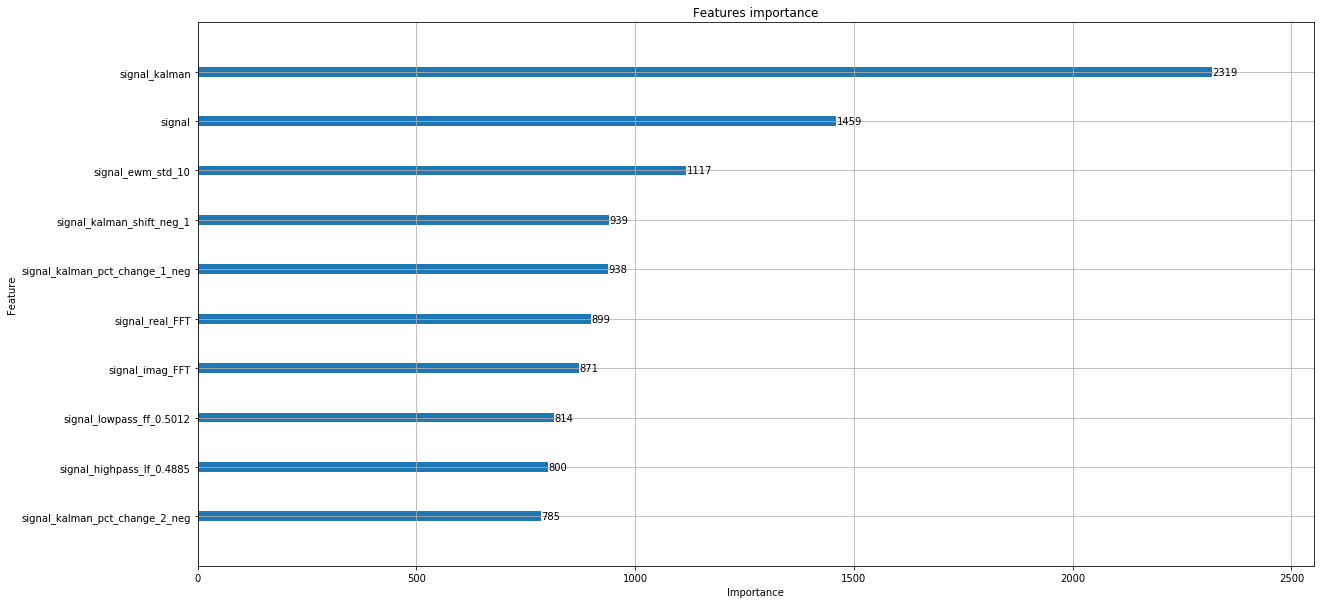

In [40]:
lgbm.plot_importance(
    booster=model,
    ax=None,
    height=.2,
    xlim=None,
    ylim=None,
    title='Features importance',
    xlabel='Importance',
    ylabel='Feature',
    importance_type='split',
    max_num_features=10,
    ignore_zero=True,
    figsize=(20, 10),
    grid=True
)

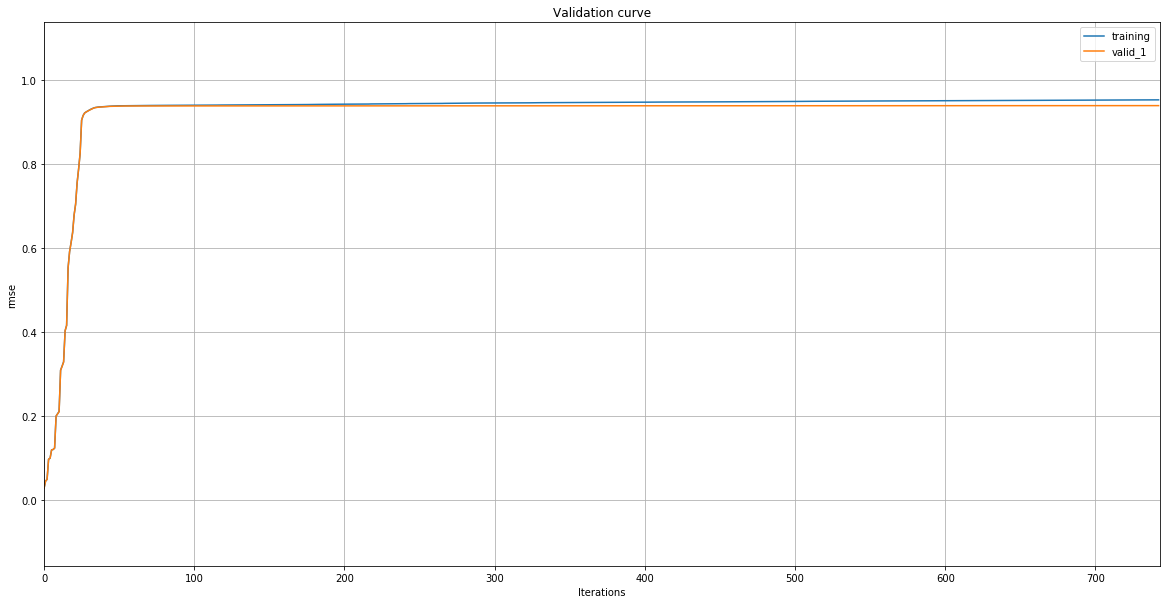

In [41]:
lgbm.plot_metric(
    booster=evals_result,
    metric=None,
    dataset_names=None,
    ax=None,
    xlim=None,
    ylim=None,
    title='Validation curve',
    xlabel='Iterations',
    ylabel='rmse',
    figsize=(20, 10),
    grid=True
)

In [42]:
y_pred_train = model.predict(
    train_lgbm.data,
    num_iteration=model.best_iteration,
    raw_score=False,
    pred_leaf=False,
    pred_contrib=False,
    data_has_header=False,
    is_reshape=True,
)

y_pred_valid = model.predict(
    valid_lgbm.data,
    num_iteration=model.best_iteration,
    raw_score=False,
    pred_leaf=False,
    pred_contrib=False,
    data_has_header=False,
    is_reshape=True,
)

y_pred_test = model.predict(
    test_lgbm.data,
    num_iteration=model.best_iteration,
    raw_score=False,
    pred_leaf=False,
    pred_contrib=False,
    data_has_header=False,
    is_reshape=True,
)

In [43]:
y_pred_train_clipped = np.round(np.clip(y_pred_train, 0, 10)).astype(int)
y_pred_valid_clipped = np.round(np.clip(y_pred_valid, 0, 10)).astype(int)
y_pred_test_clipped = np.round(np.clip(y_pred_test, 0, 10)).astype(int)

In [44]:
sklearn.metrics.f1_score(
    train_lgbm.get_label(),
    y_pred_train_clipped,
    average='macro'
)

0.9506624148561076

In [45]:
sklearn.metrics.f1_score(
    valid_lgbm.get_label(),
    y_pred_valid_clipped,
    average='macro'
)

0.9383167371373243

In [46]:
test['open_channels'] = y_pred_test_clipped

In [47]:
test[['time','open_channels']].to_csv(
    path + 'submission_lgbm_regression.csv',
    index=False,
    float_format='%.4f'
)

### Mean single models

In [ ]:
y_preds_train = []
y_preds_valid = []
y_preds_test = []

for i in range(10):
    
    params = {
        'boosting': 'gbdt',
        'objective': 'rmse',
        'metric': 'rmse',
        'learning_rate': .1,
        'max_depth': 16,    
        'num_leaves': 128,
        'min_data_in_leaf': 20,
        'feature_fraction': 1.,
        'feature_fraction_bynode': 1.,
        'feature_fraction_seed': random_state,
        'bagging_fraction': 1.,
        'bagging_freq': 0,
        'bagging_seed': random_state,
        'max_bin': 255,
        'is_unbalance': True,
        'random_state': random_state,
        'n_jobs': n_threads
    }
    
    evals_result = {}

    model = lgbm.train(
        params=params,
        train_set=train_lgbm,
        num_boost_round=2000,
        valid_sets=[train_lgbm, valid_lgbm],
        valid_names=None,
        fobj=None,
        feval=lgbm_metric,
        init_model=None,
        #feature_name=feat, #for not lgbm dataset
        #categorical_feature=cat_feat, #for not lgbm dataset
        early_stopping_rounds=100,
        evals_result=evals_result,
        verbose_eval=50,
        learning_rates=None,
        keep_training_booster=False,
        callbacks=None
    )
    
    y_pred_train = model.predict(
        data=train_lgbm.data,
        num_iteration=model.best_iteration,
        raw_score=False,
        pred_leaf=False,
        pred_contrib=False,
        data_has_header=False,
        is_reshape=True,
    )
    
    y_pred_valid = model.predict(
        data=valid_lgbm.data,
        num_iteration=model.best_iteration,
        raw_score=False,
        pred_leaf=False,
        pred_contrib=False,
        data_has_header=False,
        is_reshape=True,
    )
    
    y_pred_test = model.predict(
        data=test_lgbm.data,
        num_iteration=model.best_iteration,
        raw_score=False,
        pred_leaf=False,
        pred_contrib=False,
        data_has_header=False,
        is_reshape=True,
    )
    
    y_preds_train.append(y_pred_train)
    y_preds_valid.append(y_pred_valid)
    y_preds_test.append(y_pred_test)

In [ ]:
y_pred_train_final = np.mean(y_preds_train, axis=0)
y_pred_valid_final = np.mean(y_preds_valid, axis=0)
y_pred_test_final = np.mean(y_preds_test, axis=0)

In [ ]:
y_pred_train_final_clipped = np.round(np.clip(y_pred_train_final, 0, 10)).astype(int)
y_pred_valid_final_clipped = np.round(np.clip(y_pred_valid_final, 0, 10)).astype(int)
y_pred_test_final_clipped = np.round(np.clip(y_pred_test_final, 0, 10)).astype(int)

In [ ]:
sklearn.metrics.f1_score(
    train_lgbm.get_label(),
    y_pred_train_final_clipped,
    average='macro'
)

In [ ]:
sklearn.metrics.f1_score(
    valid_lgbm.get_label(),
    y_pred_valid_final_clipped,
    average='macro'
)

In [ ]:
test['open_channels'] = y_pred_test_final_clipped

In [ ]:
test[['time','open_channels']].to_csv(
    path + 'submission_100_lgbm_regression.csv',
    index=False,
    float_format='%.4f'
)

### Single model with cv

Fold 1
Training until validation scores don't improve for 100 rounds.
[50]	training's rmse: 0.194288	training's F1 Macro: 0.916638	valid_1's rmse: 0.195363	valid_1's F1 Macro: 0.916361
[100]	training's rmse: 0.180197	training's F1 Macro: 0.928192	valid_1's rmse: 0.181751	valid_1's F1 Macro: 0.927296
[150]	training's rmse: 0.174621	training's F1 Macro: 0.932022	valid_1's rmse: 0.176845	valid_1's F1 Macro: 0.930655
[200]	training's rmse: 0.171297	training's F1 Macro: 0.934024	valid_1's rmse: 0.174321	valid_1's F1 Macro: 0.932266
[250]	training's rmse: 0.16878	training's F1 Macro: 0.935688	valid_1's rmse: 0.172619	valid_1's F1 Macro: 0.93315
[300]	training's rmse: 0.166641	training's F1 Macro: 0.936991	valid_1's rmse: 0.171313	valid_1's F1 Macro: 0.933803
[350]	training's rmse: 0.164888	training's F1 Macro: 0.938123	valid_1's rmse: 0.17044	valid_1's F1 Macro: 0.934079
[400]	training's rmse: 0.163299	training's F1 Macro: 0.939229	valid_1's rmse: 0.169706	valid_1's F1 Macro: 0.934366
[450]	

[150]	training's rmse: 0.174037	training's F1 Macro: 0.93224	valid_1's rmse: 0.176172	valid_1's F1 Macro: 0.929959
[200]	training's rmse: 0.170619	training's F1 Macro: 0.934472	valid_1's rmse: 0.173561	valid_1's F1 Macro: 0.93176
[250]	training's rmse: 0.168208	training's F1 Macro: 0.936067	valid_1's rmse: 0.172	valid_1's F1 Macro: 0.932635
[300]	training's rmse: 0.166264	training's F1 Macro: 0.937357	valid_1's rmse: 0.170938	valid_1's F1 Macro: 0.933191
[350]	training's rmse: 0.164596	training's F1 Macro: 0.938603	valid_1's rmse: 0.170109	valid_1's F1 Macro: 0.933583
[400]	training's rmse: 0.162975	training's F1 Macro: 0.939663	valid_1's rmse: 0.169324	valid_1's F1 Macro: 0.934157
[450]	training's rmse: 0.161587	training's F1 Macro: 0.940658	valid_1's rmse: 0.168691	valid_1's F1 Macro: 0.934307
[500]	training's rmse: 0.160403	training's F1 Macro: 0.941475	valid_1's rmse: 0.168302	valid_1's F1 Macro: 0.934441
[550]	training's rmse: 0.159172	training's F1 Macro: 0.942385	valid_1's rmse:

[1800]	training's rmse: 0.138372	training's F1 Macro: 0.959506	valid_1's rmse: 0.164779	valid_1's F1 Macro: 0.936389
[1850]	training's rmse: 0.137707	training's F1 Macro: 0.960038	valid_1's rmse: 0.16473	valid_1's F1 Macro: 0.936362
Early stopping, best iteration is:
[1752]	training's rmse: 0.138991	training's F1 Macro: 0.958944	valid_1's rmse: 0.164823	valid_1's F1 Macro: 0.93643
Fold 5
Training until validation scores don't improve for 100 rounds.
[50]	training's rmse: 0.193752	training's F1 Macro: 0.917608	valid_1's rmse: 0.194388	valid_1's F1 Macro: 0.916938
[100]	training's rmse: 0.179851	training's F1 Macro: 0.928688	valid_1's rmse: 0.180944	valid_1's F1 Macro: 0.928088
[150]	training's rmse: 0.174306	training's F1 Macro: 0.932144	valid_1's rmse: 0.175997	valid_1's F1 Macro: 0.931263
[200]	training's rmse: 0.171044	training's F1 Macro: 0.934106	valid_1's rmse: 0.173476	valid_1's F1 Macro: 0.932697
[250]	training's rmse: 0.168517	training's F1 Macro: 0.935567	valid_1's rmse: 0.171

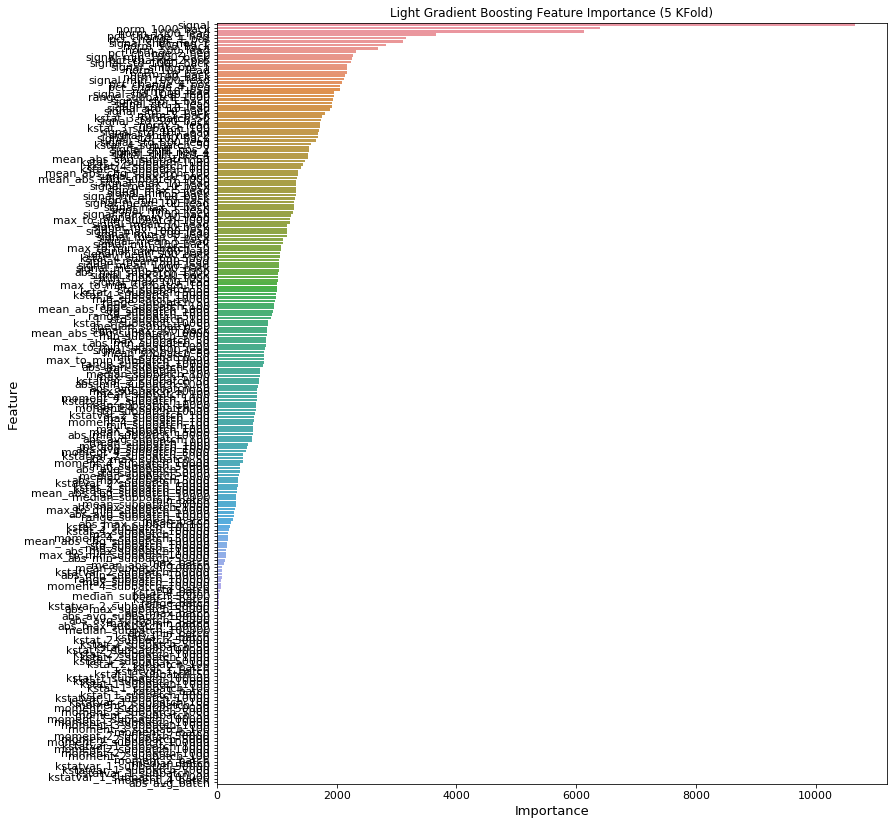

In [108]:
params = {
    'boosting': 'gbdt',
    'objective': 'rmse',
    'metric': 'rmse',
    'learning_rate': .1,
    'max_depth': 16,    
    'num_leaves': 128,
    'min_data_in_leaf': 20,
    'feature_fraction': 1.,
    'feature_fraction_bynode': 1.,
    'feature_fraction_seed': random_state,
    'bagging_fraction': 1.,
    'bagging_freq': 0,
    'bagging_seed': random_state,
    'max_bin': 255,
    'is_unbalance': True,
    'random_state': random_state,
    'n_jobs': n_threads
}

target = 'open_channels'

kf = sklearn.model_selection.KFold(
    n_splits=5,
    shuffle=True,
    random_state=random_state
)

oof_pred = np.zeros(len(train))
#y_pred = np.zeros(len(test))
y_preds_test = []
feature_importance = pd.DataFrame()

for fold, (tr_ind, val_ind) in enumerate(kf.split(train)):

    print('Fold {}'.format(fold + 1))

    X_train_f, X_valid_f = train[feat].iloc[tr_ind], train[feat].iloc[val_ind]
    y_train_f, y_valid_f = train[target][tr_ind], train[target][val_ind]
    
    train_set = lgbm.Dataset(
        data=X_train_f,
        label=y_train_f,
        reference=None,
        weight=None,
        group=None,
        init_score=None,
        silent=False,
        feature_name=feat,
        categorical_feature=cat_feat,
        params=None,
        free_raw_data=False,
    )
    
    val_set = lgbm.Dataset(
        data=X_valid_f,
        label=y_valid_f,
        reference=None,
        weight=None,
        group=None,
        init_score=None,
        silent=False,
        feature_name=feat,
        categorical_feature=cat_feat,
        params=None,
        free_raw_data=False,
    )
    
    evals_result = {}

    model = lgbm.train(
        params,
        train_set=train_set,
        num_boost_round=2000,
        valid_sets=[train_set, val_set],
        valid_names=None,
        fobj=None,
        feval=lgbm_metric,
        init_model=None,
        #feature_name=feat, #for not lgbm dataset
        #categorical_feature=cat_feat, #for not lgbm dataset
        early_stopping_rounds=100,
        evals_result=evals_result,
        verbose_eval=50,
        learning_rates=None,
        keep_training_booster=False,
        callbacks=None
    )
    
    y_pred_valid = model.predict(
        data=val_set.data,
        num_iteration=model.best_iteration,
        raw_score=False,
        pred_leaf=False,
        pred_contrib=False,
        data_has_header=False,
        is_reshape=True,
    )

    y_pred_test = model.predict(
        data=test_lgbm.data,
        num_iteration=model.best_iteration,
        raw_score=False,
        pred_leaf=False,
        pred_contrib=False,
        data_has_header=False,
        is_reshape=True,
    )
    
    oof_pred[val_ind] = y_pred_valid
    #y_pred += model.predict(test[feat]) / kf.n_splits
    y_preds_test.append(y_pred_test)

    fold_importance = pd.DataFrame({'features': feat})
    fold_importance['fold'] = fold + 1
    fold_importance['importance'] = model.feature_importance()
    feature_importance = pd.concat([feature_importance, fold_importance])

oof_pred_clipped = np.round(np.clip(oof_pred, 0, 10)).astype(int)
score = sklearn.metrics.f1_score(
    train[target],
    oof_pred_clipped,
    average='macro'
)
print(
    '\n',
    'F1 Macro oof score is: ',
    score
)

fi_mean = feature_importance.groupby(['features'])['importance'].mean().reset_index()
fi_mean.sort_values('importance', ascending = False, inplace = True)
plt.figure(figsize = (12, 14))
sns.barplot(x = fi_mean['importance'], y = fi_mean['features'])
plt.xlabel('Importance', fontsize = 13)
plt.ylabel('Feature', fontsize = 13)
plt.tick_params(axis = 'x', labelsize = 11)
plt.tick_params(axis = 'y', labelsize = 11)
plt.title('Light Gradient Boosting Feature Importance (5 KFold)')
plt.show()

In [109]:
y_pred_test_final = np.mean(y_preds_test, axis=0)

In [110]:
y_pred_test_final_clipped = np.round(np.clip(y_pred_test_final, 0, 10)).astype(int)

In [114]:
test['open_channels'] = y_pred_test_final_clipped

In [115]:
test[['time','open_channels']].to_csv(
    path + 'submission_1_lgbm_regression_5_kfold.csv',
    index=False,
    float_format='%.4f'
)

Fold 1
Training until validation scores don't improve for 100 rounds.
[50]	training's rmse: 0.19365	training's F1 Macro: 0.917521	valid_1's rmse: 0.195254	valid_1's F1 Macro: 0.916107
[100]	training's rmse: 0.179716	training's F1 Macro: 0.928716	valid_1's rmse: 0.181977	valid_1's F1 Macro: 0.926774
[150]	training's rmse: 0.174054	training's F1 Macro: 0.932285	valid_1's rmse: 0.176959	valid_1's F1 Macro: 0.92994
[200]	training's rmse: 0.170669	training's F1 Macro: 0.934407	valid_1's rmse: 0.174315	valid_1's F1 Macro: 0.931516
[250]	training's rmse: 0.168265	training's F1 Macro: 0.935988	valid_1's rmse: 0.172772	valid_1's F1 Macro: 0.93231
[300]	training's rmse: 0.166304	training's F1 Macro: 0.937317	valid_1's rmse: 0.171703	valid_1's F1 Macro: 0.932786
[350]	training's rmse: 0.164634	training's F1 Macro: 0.938396	valid_1's rmse: 0.170823	valid_1's F1 Macro: 0.933268
[400]	training's rmse: 0.163102	training's F1 Macro: 0.939387	valid_1's rmse: 0.170104	valid_1's F1 Macro: 0.933522
[450]	

[950]	training's rmse: 0.151202	training's F1 Macro: 0.948707	valid_1's rmse: 0.165855	valid_1's F1 Macro: 0.936098
[1000]	training's rmse: 0.150328	training's F1 Macro: 0.949344	valid_1's rmse: 0.165709	valid_1's F1 Macro: 0.936119
[1050]	training's rmse: 0.149448	training's F1 Macro: 0.95001	valid_1's rmse: 0.165523	valid_1's F1 Macro: 0.936277
[1100]	training's rmse: 0.148605	training's F1 Macro: 0.95068	valid_1's rmse: 0.165386	valid_1's F1 Macro: 0.93633
[1150]	training's rmse: 0.147775	training's F1 Macro: 0.951322	valid_1's rmse: 0.165258	valid_1's F1 Macro: 0.936331
Early stopping, best iteration is:
[1066]	training's rmse: 0.149214	training's F1 Macro: 0.950245	valid_1's rmse: 0.165499	valid_1's F1 Macro: 0.936351
Fold 4
Training until validation scores don't improve for 100 rounds.
[50]	training's rmse: 0.193956	training's F1 Macro: 0.917449	valid_1's rmse: 0.194722	valid_1's F1 Macro: 0.916453
[100]	training's rmse: 0.180047	training's F1 Macro: 0.928295	valid_1's rmse: 0.18

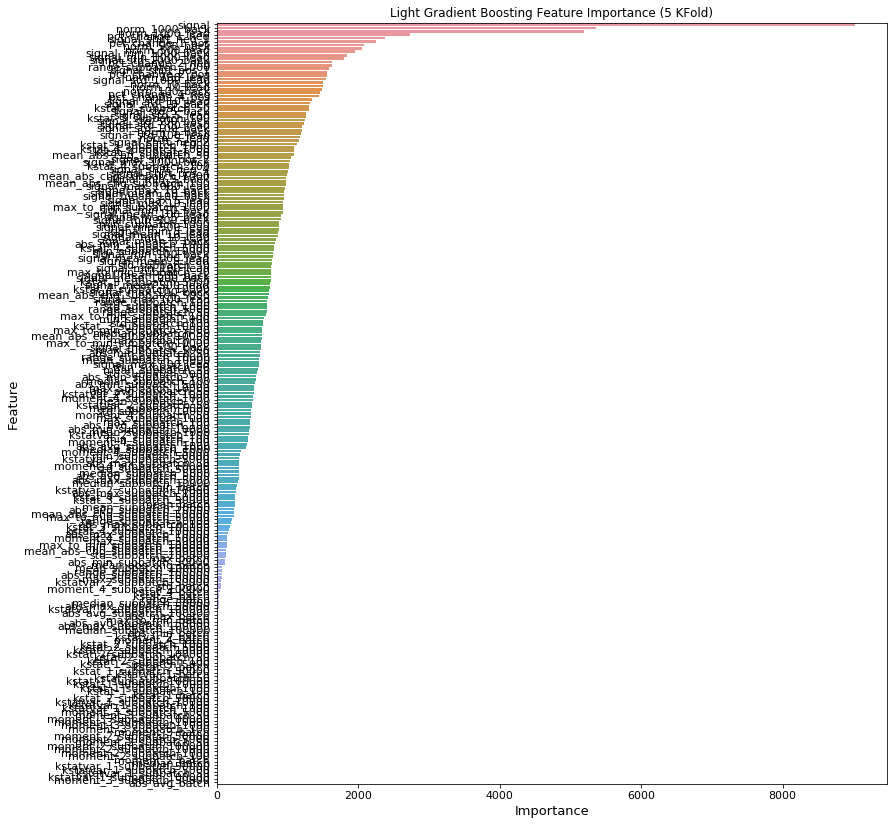

In [116]:
params = {
    'boosting': 'gbdt',
    'objective': 'rmse',
    'metric': 'rmse',
    'learning_rate': .1,
    'max_depth': 16,    
    'num_leaves': 128,
    'min_data_in_leaf': 20,
    'feature_fraction': 1.,
    'feature_fraction_bynode': 1.,
    'feature_fraction_seed': random_state,
    'bagging_fraction': 1.,
    'bagging_freq': 0,
    'bagging_seed': random_state,
    'max_bin': 255,
    'is_unbalance': True,
    'random_state': random_state,
    'n_jobs': n_threads
}

target = 'open_channels'

kf = sklearn.model_selection.StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=random_state
)

oof_pred = np.zeros(len(train))
#y_pred = np.zeros(len(test))
y_preds_test = []
feature_importance = pd.DataFrame()

for fold, (tr_ind, val_ind) in enumerate(kf.split(train, train[target])):

    print('Fold {}'.format(fold + 1))

    X_train_f, X_valid_f = train[feat].iloc[tr_ind], train[feat].iloc[val_ind]
    y_train_f, y_valid_f = train[target][tr_ind], train[target][val_ind]
    
    train_set = lgbm.Dataset(
        data=X_train_f,
        label=y_train_f,
        reference=None,
        weight=None,
        group=None,
        init_score=None,
        silent=False,
        feature_name=feat,
        categorical_feature=cat_feat,
        params=None,
        free_raw_data=False,
    )
    
    val_set = lgbm.Dataset(
        data=X_valid_f,
        label=y_valid_f,
        reference=None,
        weight=None,
        group=None,
        init_score=None,
        silent=False,
        feature_name=feat,
        categorical_feature=cat_feat,
        params=None,
        free_raw_data=False,
    )
    
    evals_result = {}

    model = lgbm.train(
        params,
        train_set=train_set,
        num_boost_round=2000,
        valid_sets=[train_set, val_set],
        valid_names=None,
        fobj=None,
        feval=lgbm_metric,
        init_model=None,
        #feature_name=feat, #for not lgbm dataset
        #categorical_feature=cat_feat, #for not lgbm dataset
        early_stopping_rounds=100,
        evals_result=evals_result,
        verbose_eval=50,
        learning_rates=None,
        keep_training_booster=False,
        callbacks=None
    )
    
    y_pred_valid = model.predict(
        data=val_set.data,
        num_iteration=model.best_iteration,
        raw_score=False,
        pred_leaf=False,
        pred_contrib=False,
        data_has_header=False,
        is_reshape=True,
    )

    y_pred_test = model.predict(
        data=test_lgbm.data,
        num_iteration=model.best_iteration,
        raw_score=False,
        pred_leaf=False,
        pred_contrib=False,
        data_has_header=False,
        is_reshape=True,
    )
    
    oof_pred[val_ind] = y_pred_valid
    #y_pred += model.predict(test[feat]) / kf.n_splits
    y_preds_test.append(y_pred_test)

    fold_importance = pd.DataFrame({'features': feat})
    fold_importance['fold'] = fold + 1
    fold_importance['importance'] = model.feature_importance()
    feature_importance = pd.concat([feature_importance, fold_importance])

oof_pred_clipped = np.round(np.clip(oof_pred, 0, 10)).astype(int)
score = sklearn.metrics.f1_score(
    train[target],
    oof_pred_clipped,
    average='macro'
)
print(
    '\n',
    'F1 Macro oof score is: ',
    score
)

fi_mean = feature_importance.groupby(['features'])['importance'].mean().reset_index()
fi_mean.sort_values('importance', ascending = False, inplace = True)
plt.figure(figsize = (12, 14))
sns.barplot(x = fi_mean['importance'], y = fi_mean['features'])
plt.xlabel('Importance', fontsize = 13)
plt.ylabel('Feature', fontsize = 13)
plt.tick_params(axis = 'x', labelsize = 11)
plt.tick_params(axis = 'y', labelsize = 11)
plt.title('Light Gradient Boosting Feature Importance (5 KFold)')
plt.show()

In [117]:
y_pred_test_final = np.mean(y_preds_test, axis=0)

In [119]:
y_pred_test_final_clipped = np.round(np.clip(y_pred_test_final, 0, 10)).astype(int)

In [120]:
test['open_channels'] = y_pred_test_final_clipped

In [121]:
test[['time','open_channels']].to_csv(
    path + 'submission_1_lgbm_regression_5_stratifiedkfold.csv',
    index=False,
    float_format='%.4f'
)

### Mean models with cv

In [ ]:
oof_preds = []
y_preds_test_ = []
target = 'open_channels'

for i in range(10):

    random_state_new = random_state + i

    params = {
        'boosting': 'gbdt',
        'objective': 'rmse',
        'metric': 'rmse',
        'learning_rate': .1,
        'max_depth': 16,    
        'num_leaves': 128,
        'min_data_in_leaf': 20,
        'feature_fraction': 1.,
        'feature_fraction_bynode': 1.,
        'feature_fraction_seed': random_state_new,
        'bagging_fraction': 1.,
        'bagging_freq': 0,
        'bagging_seed': random_state_new,
        'max_bin': 255,
        'is_unbalance': True,
        'random_state': random_state_new,
        'n_jobs': n_threads
    }
    
    kf = sklearn.model_selection.StratifiedKFold(
        n_splits=5,
        shuffle=True,
        random_state=random_state_new
    )
    
    oof_pred = np.zeros(len(train))
    #y_pred = np.zeros(len(test))
    y_preds_test = []
    #feature_importance = pd.DataFrame()

    for fold, (tr_ind, val_ind) in enumerate(kf.split(train, train[target])):

        print('Fold {}'.format(fold + 1))

        X_train_f, X_valid_f = train[feat].iloc[tr_ind], train[feat].iloc[val_ind]
        y_train_f, y_valid_f = train[target][tr_ind], train[target][val_ind]

        train_set = lgbm.Dataset(
            data=X_train_f,
            label=y_train_f,
            reference=None,
            weight=None,
            group=None,
            init_score=None,
            silent=False,
            feature_name=feat,
            categorical_feature=cat_feat,
            params=None,
            free_raw_data=False,
        )

        val_set = lgbm.Dataset(
            data=X_valid_f,
            label=y_valid_f,
            reference=None,
            weight=None,
            group=None,
            init_score=None,
            silent=False,
            feature_name=feat,
            categorical_feature=cat_feat,
            params=None,
            free_raw_data=False,
        )
        
        evals_result = {}

        model = lgbm.train(
            params,
            train_set=train_set,
            num_boost_round=2000,
            valid_sets=[train_set, val_set],
            valid_names=None,
            fobj=None,
            feval=lgbm_metric,
            init_model=None,
            #feature_name=feat, #for not lgbm dataset
            #categorical_feature=cat_feat, #for not lgbm dataset
            early_stopping_rounds=100,
            evals_result=evals_result,
            verbose_eval=50,
            learning_rates=None,
            keep_training_booster=False,
            callbacks=None
        )

        y_pred_valid = model.predict(
            data=val_set.data,
            num_iteration=model.best_iteration,
            raw_score=False,
            pred_leaf=False,
            pred_contrib=False,
            data_has_header=False,
            is_reshape=True,
        )

        y_pred_test = model.predict(
            data=test_lgbm.data,
            num_iteration=model.best_iteration,
            raw_score=False,
            pred_leaf=False,
            pred_contrib=False,
            data_has_header=False,
            is_reshape=True,
        )

        oof_pred[val_ind] = y_pred_valid
        #y_pred += model.predict(test[feat]) / kf.n_splits
        y_preds_test.append(y_pred_test)

    oof_preds.append(oof_pred)
    oof_pred_clipped = np.round(np.clip(oof_pred, 0, 10)).astype(int)
    
    y_pred_test_final = np.mean(y_preds_test, axis=0)
    y_preds_test_.append(y_pred_test_final)
    
    score = sklearn.metrics.f1_score(
        train[target],
        oof_pred_clipped,
        average='macro'
    )
    
    print(
        'random_state: ',
        random_state + i,
        'F1 Macro oof score is: ',
        score)

In [ ]:
oof_pred_final = np.mean(oof_preds, axis=0)
oof_pred_final_clipped = np.round(np.clip(oof_pred_final, 0, 10)).astype(int)

In [ ]:
sklearn.metrics.f1_score(
    train[target],
    oof_pred_final_clipped,
    average='macro'
)

In [ ]:
optR = OptimizedRounder()
optR.fit(
    oof_pred_final,
    train[target]
)
coefficients = optR.coefficients()
print(coefficients)

In [ ]:
y_pred_opt = optR.predict(
    oof_pred_final.reshape(-1,),
    coefficients
)
sklearn.metrics.f1_score(
    train[target],
    y_pred_opt,
    average = 'macro'
)

In [ ]:
y_pred_final = np.mean(y_preds, axis=0)

y_pred_final_opt = optR.predict(
    y_pred_final.reshape(-1,),
    coefficients
)
y_pred_final_opt = np.array(y_pred_final_opt)

prediction = np.mean(y_preds, axis=0)

prediction[prediction <= coefficients[0]] = 0
prediction[np.where(np.logical_and(prediction > coefficients[0], prediction <= coefficients[1]))] = 1
prediction[np.where(np.logical_and(prediction > coefficients[1], prediction <= coefficients[2]))] = 2
prediction[np.where(np.logical_and(prediction > coefficients[2], prediction <= coefficients[3]))] = 3
prediction[np.where(np.logical_and(prediction > coefficients[3], prediction <= coefficients[4]))] = 4
prediction[np.where(np.logical_and(prediction > coefficients[4], prediction <= coefficients[5]))] = 5
prediction[np.where(np.logical_and(prediction > coefficients[5], prediction <= coefficients[6]))] = 6
prediction[np.where(np.logical_and(prediction > coefficients[6], prediction <= coefficients[7]))] = 7
prediction[np.where(np.logical_and(prediction > coefficients[7], prediction <= coefficients[8]))] = 8
prediction[np.where(np.logical_and(prediction > coefficients[8], prediction <= coefficients[9]))] = 9
prediction[prediction > coefficients[9]] = 10

In [ ]:
y_pred_clipped = y_pred_final_opt.astype(int)
test['open_channels'] = y_pred_clipped

y_pred_final = np.mean(y_preds, axis=0)
y_pred_clipped = np.round(np.clip(y_pred_final, 0, 10)).astype(int)
test['open_channels'] = y_pred_clipped

In [ ]:
test[['time','open_channels']].to_csv(
    path + 'submission_10_lgbm_regression_5_stratified_kfold_optimized_round.csv',
    index=False,
    float_format='%.4f'
)

### Searching the best depth

In [18]:
target = 'open_channels'

kf = sklearn.model_selection.StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=random_state
)

train_results = []
valid_results = []

depths = [2, 4, 8, 16, 32, 64, -1]
num_leaves_ = [4, 16, 64, 128, 128, 128, 128]

for d, n_l in tqdm.tqdm_notebook(zip(depths, num_leaves_)):

    params = {
        'boosting': 'gbdt',
        'objective': 'rmse',
        'metric': 'rmse',
        'learning_rate': .1,
        'max_depth': d,    
        'num_leaves': n_l,
        'min_data_in_leaf': 20,
        'feature_fraction': 1.,
        'feature_fraction_bynode': 1.,
        'feature_fraction_seed': random_state,
        'bagging_fraction': 1.,
        'bagging_freq': 0,
        'bagging_seed': random_state,
        'max_bin': 255,
        'random_state': random_state,
        'n_jobs': n_threads
    }

    oof_pred = np.zeros(len(train))
    y_preds_train = []

    for fold, (tr_ind, val_ind) in enumerate(kf.split(train, train[target])):

        #print('Fold {}'.format(fold + 1))

        X_train_f, X_valid_f = train[feat].iloc[tr_ind], train[feat].iloc[val_ind]
        y_train_f, y_valid_f = train[target][tr_ind], train[target][val_ind]

        train_set = lgbm.Dataset(
            data=X_train_f,
            label=y_train_f,
            reference=None,
            weight=None,
            group=None,
            init_score=None,
            silent=False,
            feature_name=feat,
            categorical_feature=cat_feat,
            params=None,
            free_raw_data=False,
        )

        val_set = lgbm.Dataset(
            data=X_valid_f,
            label=y_valid_f,
            reference=None,
            weight=None,
            group=None,
            init_score=None,
            silent=False,
            feature_name=feat,
            categorical_feature=cat_feat,
            params=None,
            free_raw_data=False,
        )
    
        evals_result = {}

        model = lgbm.train(
            params,
            train_set=train_set,
            num_boost_round=500,
            valid_sets=[train_set, val_set],
            valid_names=None,
            fobj=None,
            feval=lgbm_metric,
            init_model=None,
            #feature_name=feat, #for not lgbm dataset
            #categorical_feature=cat_feat, #for not lgbm dataset
            early_stopping_rounds=10,
            evals_result=evals_result,
            verbose_eval=False,
            learning_rates=None,
            keep_training_booster=False,
            callbacks=None
        )

        y_pred_train = model.predict(
            data=train[feat],
            num_iteration=model.best_iteration,
            raw_score=False,
            pred_leaf=False,
            pred_contrib=False,
            data_has_header=False,
            is_reshape=True,
        )

        y_pred_valid = model.predict(
            data=val_set.data,
            num_iteration=model.best_iteration,
            raw_score=False,
            pred_leaf=False,
            pred_contrib=False,
            data_has_header=False,
            is_reshape=True,
        )
        
        oof_pred[val_ind] = y_pred_valid
        y_preds_train.append(y_pred_train)
        
    y_pred_train_final = np.mean(y_preds_train, axis=0)
    y_pred_train_final_clipped = np.round(np.clip(y_pred_train_final, 0, 10)).astype(int)
    train_results.append(
        sklearn.metrics.f1_score(
            train[target],
            y_pred_train_final_clipped,
            average='macro')
    )

    y_pred_valid_final_clipped = np.round(np.clip(oof_pred, 0, 10)).astype(int)
    valid_results.append(
        sklearn.metrics.f1_score(
            train[target],
            y_pred_valid_final_clipped,
            average='macro')
    )

plot_vc(
    x=[d for d in depths],
    y_train=train_results,
    y_valid=valid_results,
    xlabel='DEPTH',
    title='F1 Macro'
)

## Classification

In [39]:
params = {
    'boosting': 'gbdt',
    'objective': 'multiclass',
    'metric': 'softmax',
    'learning_rate': .01,
    'max_depth': 50,
    'num_leaves': 128,
    'min_data_in_leaf': 20,
    'feature_fraction': 1.,
    'feature_fraction_bynode': 1.,
    'feature_fraction_seed': random_state,
    'bagging_fraction': 1.,
    'bagging_freq': 0,
    'bagging_seed': random_state,
    'max_bin': 255,
    'num_class': 11,
    'is_unbalance': True,
    'random_state': random_state,
    'n_jobs': n_threads
}

evals_result = {}

model = lgbm.train(
    params=params,
    train_set=train_lgbm,
    num_boost_round=1000,
    valid_sets=[train_lgbm, valid_lgbm],
    valid_names=None,
    #fobj=lgbm_metric,
    feval=None,
    init_model=None,
    #feature_name=feat, #for not lgbm dataset
    #categorical_feature=cat_feat, #for not lgbm dataset
    early_stopping_rounds=100,
    evals_result=evals_result,
    verbose_eval=100,
    learning_rates=None,
    keep_training_booster=False,
    callbacks=None
)

Training until validation scores don't improve for 100 rounds.
[100]	training's multi_logloss: 0.620494	valid_1's multi_logloss: 0.624285
[200]	training's multi_logloss: 0.273891	valid_1's multi_logloss: 0.279937
[300]	training's multi_logloss: 0.15123	valid_1's multi_logloss: 0.159502
[400]	training's multi_logloss: 0.103846	valid_1's multi_logloss: 0.114526
[500]	training's multi_logloss: 0.083694	valid_1's multi_logloss: 0.0968314
[600]	training's multi_logloss: 0.0740358	valid_1's multi_logloss: 0.0894376
[700]	training's multi_logloss: 0.0685453	valid_1's multi_logloss: 0.0860051
[800]	training's multi_logloss: 0.0649877	valid_1's multi_logloss: 0.0843141
[900]	training's multi_logloss: 0.0623423	valid_1's multi_logloss: 0.08342
[1000]	training's multi_logloss: 0.0602782	valid_1's multi_logloss: 0.082891
[1100]	training's multi_logloss: 0.0585402	valid_1's multi_logloss: 0.0825818
[1200]	training's multi_logloss: 0.0570254	valid_1's multi_logloss: 0.0823938
[1300]	training's multi

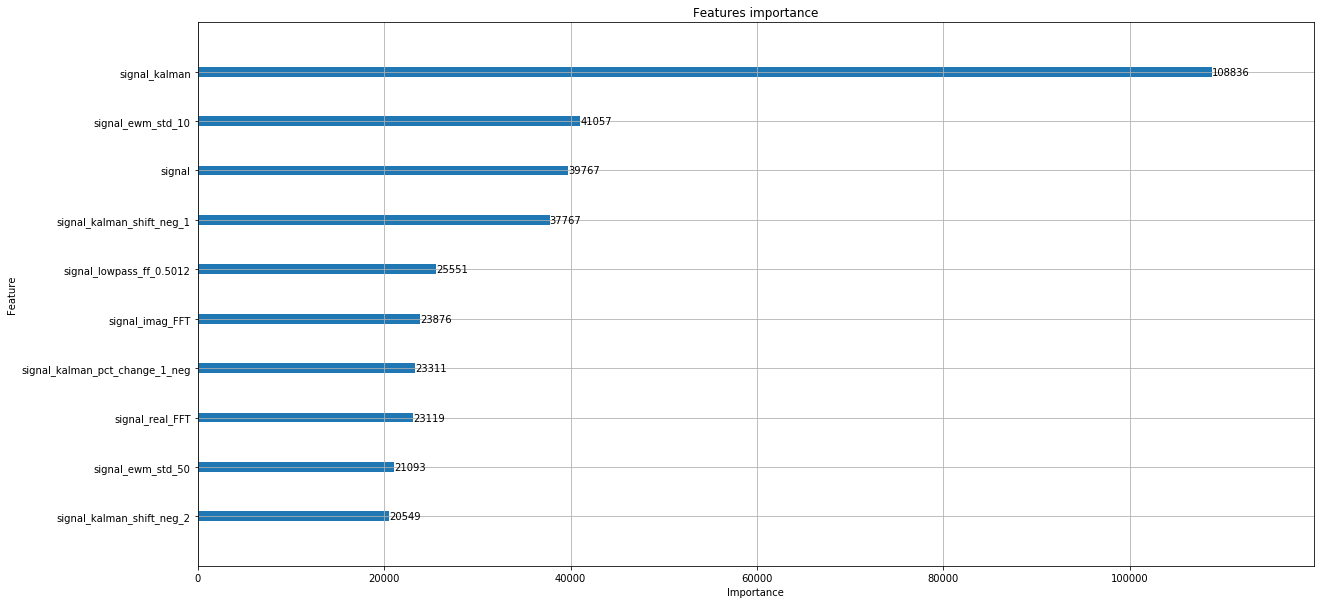

In [40]:
lgbm.plot_importance(
    booster=model,
    ax=None,
    height=.2,
    xlim=None,
    ylim=None,
    title='Features importance',
    xlabel='Importance',
    ylabel='Feature',
    importance_type='split',
    max_num_features=10,
    ignore_zero=True,
    figsize=(20, 10),
    grid=True
)

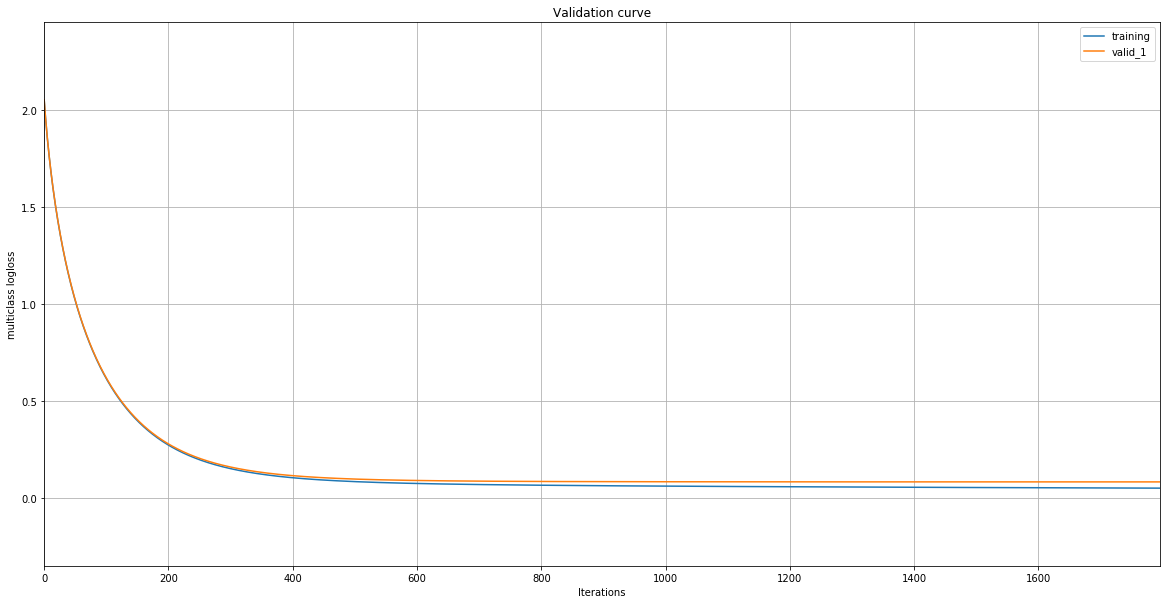

In [41]:
lgbm.plot_metric(
    booster=evals_result,
    metric=None,
    dataset_names=None,
    ax=None,
    xlim=None,
    ylim=None,
    title='Validation curve',
    xlabel='Iterations',
    ylabel='multiclass logloss',
    figsize=(20, 10),
    grid=True
)

In [42]:
gc.collect()

25

In [45]:
y_pred_train = model.predict(
    data=train_lgbm.data,
    num_iteration=model.best_iteration,
    raw_score=False,
    pred_leaf=False,
    pred_contrib=False,
    data_has_header=False,
    is_reshape=True,
    pred_parameter=None
)

y_pred_valid = model.predict(
    data=valid_lgbm.data,
    num_iteration=model.best_iteration,
    raw_score=False,
    pred_leaf=False,
    pred_contrib=False,
    data_has_header=False,
    is_reshape=True,
    pred_parameter=None
)

y_pred_test = model.predict(
    data=test_lgbm.data,
    num_iteration=model.best_iteration,
    raw_score=False,
    pred_leaf=False,
    pred_contrib=False,
    data_has_header=False,
    is_reshape=True,
    pred_parameter=None
)

In [46]:
y_pred_train_class = np.argmax(y_pred_train, axis=1)
y_pred_valid_class = np.argmax(y_pred_valid, axis=1)
y_pred_test_class = np.argmax(y_pred_test, axis=1)

In [47]:
sklearn.metrics.f1_score(
    train_lgbm.get_label(),
    y_pred_train_class,
    average='macro'
)

0.9610187039316823

In [48]:
sklearn.metrics.f1_score(
    valid_lgbm.get_label(),
    y_pred_valid_class,
    average='macro'
)

0.9381972408210263

In [49]:
pd.DataFrame(y_pred_train_class)[0].value_counts()

0     929905
1     739517
3     500751
2     416112
4     303167
5     206991
7     199783
8     183930
6     141714
9     101525
10     26605
Name: 0, dtype: int64

In [50]:
pd.DataFrame(y_pred_test_class)[0].value_counts()

0     1220493
1      217535
3      135336
2      116686
4       80427
5       55972
7       53045
8       49015
6       37347
9       27174
10       6970
Name: 0, dtype: int64

In [51]:
test['open_channels'] = y_pred_test_class

In [52]:
test[['time','open_channels']].to_csv(
    path + 'submission_1_lgbm_classification.csv',
    index=False,
    float_format='%.4f'
)

### Mean single models

In [ ]:
y_preds_train = []
y_preds_valid = []
y_preds_test = []

for i in range(3):
    
    params = {
        'boosting': 'gbdt',
        'objective': 'multiclass',
        'metric': 'softmax',
        'learning_rate': .01,
        'max_depth': 50,    
        'num_leaves': 128,
        'min_data_in_leaf': 20,
        'feature_fraction': 1.,
        'feature_fraction_bynode': 1.,
        'feature_fraction_seed': random_state,
        'bagging_fraction': 1.,
        'bagging_freq': 0,
        'bagging_seed': random_state,
        'max_bin': 255,
        'num_class': 11,
        'is_unbalance': True,
        'random_state': random_state,
        'n_jobs': n_threads
    }
    
    evals_result = {}

    model = lgbm.train(
        params,
        train_set=train_lgbm,
        num_boost_round=2000,
        valid_sets=[train_lgbm, valid_lgbm],
        valid_names=None,
        #fobj=lgbm_metric,
        feval=None,
        init_model=None,
        #feature_name=feat, #for not lgbm dataset
        #categorical_feature=cat_feat, #for not lgbm dataset
        early_stopping_rounds=100,
        evals_result=evals_result,
        verbose_eval=50,
        learning_rates=None,
        keep_training_booster=False,
        callbacks=None
    )
    
    y_pred_train = model.predict(
        data=train_lgbm.data,
        num_iteration=model.best_iteration,
        raw_score=False,
        pred_leaf=False,
        pred_contrib=False,
        data_has_header=False,
        is_reshape=True,
        pred_parameter=None
    )

    y_pred_valid = model.predict(
        data=valid_lgbm.data,
        num_iteration=model.best_iteration,
        raw_score=False,
        pred_leaf=False,
        pred_contrib=False,
        data_has_header=False,
        is_reshape=True,
        pred_parameter=None
    )

    y_pred_test = model.predict(
        data=test[feat],
        num_iteration=model.best_iteration,
        raw_score=False,
        pred_leaf=False,
        pred_contrib=False,
        data_has_header=False,
        is_reshape=True,
        pred_parameter=None
    )

    y_preds_train.append(y_pred_train)
    y_preds_valid.append(y_pred_valid)
    y_preds_test.append(y_pred_test)

In [ ]:
y_pred_train_class = np.argmax(np.mean(y_preds_train, axis=0), axis=1)
y_pred_valid_class = np.argmax(np.mean(y_preds_valid, axis=0), axis=1)
y_pred_test_class = np.argmax(np.mean(y_preds_test, axis=0), axis=1)

In [ ]:
sklearn.metrics.f1_score(
    train_lgbm.get_label(),
    y_pred_train_class,
    average='macro'
)

In [ ]:
sklearn.metrics.f1_score(
    valid_lgbm.get_label(),
    y_pred_valid_class,
    average='macro'
)

In [ ]:
test['open_channels'] = y_pred_test_class

In [ ]:
test[['time','open_channels']].to_csv(
    path + 'submission_100_lgbm_classification.csv',
    index=False,
    float_format='%.4f'
)

### Single model with cv

Fold 1
Training until validation scores don't improve for 100 rounds.
[100]	training's multi_logloss: 0.62072	valid_1's multi_logloss: 0.624332
[200]	training's multi_logloss: 0.274273	valid_1's multi_logloss: 0.280033
[300]	training's multi_logloss: 0.151713	valid_1's multi_logloss: 0.159577
[400]	training's multi_logloss: 0.104434	valid_1's multi_logloss: 0.114577
[500]	training's multi_logloss: 0.084352	valid_1's multi_logloss: 0.0968645
[600]	training's multi_logloss: 0.0747454	valid_1's multi_logloss: 0.0894442
[700]	training's multi_logloss: 0.0693027	valid_1's multi_logloss: 0.0860103
[800]	training's multi_logloss: 0.0658053	valid_1's multi_logloss: 0.0843149
[900]	training's multi_logloss: 0.0632277	valid_1's multi_logloss: 0.0834016
[1000]	training's multi_logloss: 0.0611974	valid_1's multi_logloss: 0.0828637
Did not meet early stopping. Best iteration is:
[1000]	training's multi_logloss: 0.0611974	valid_1's multi_logloss: 0.0828637
Fold 2
Training until validation scores don

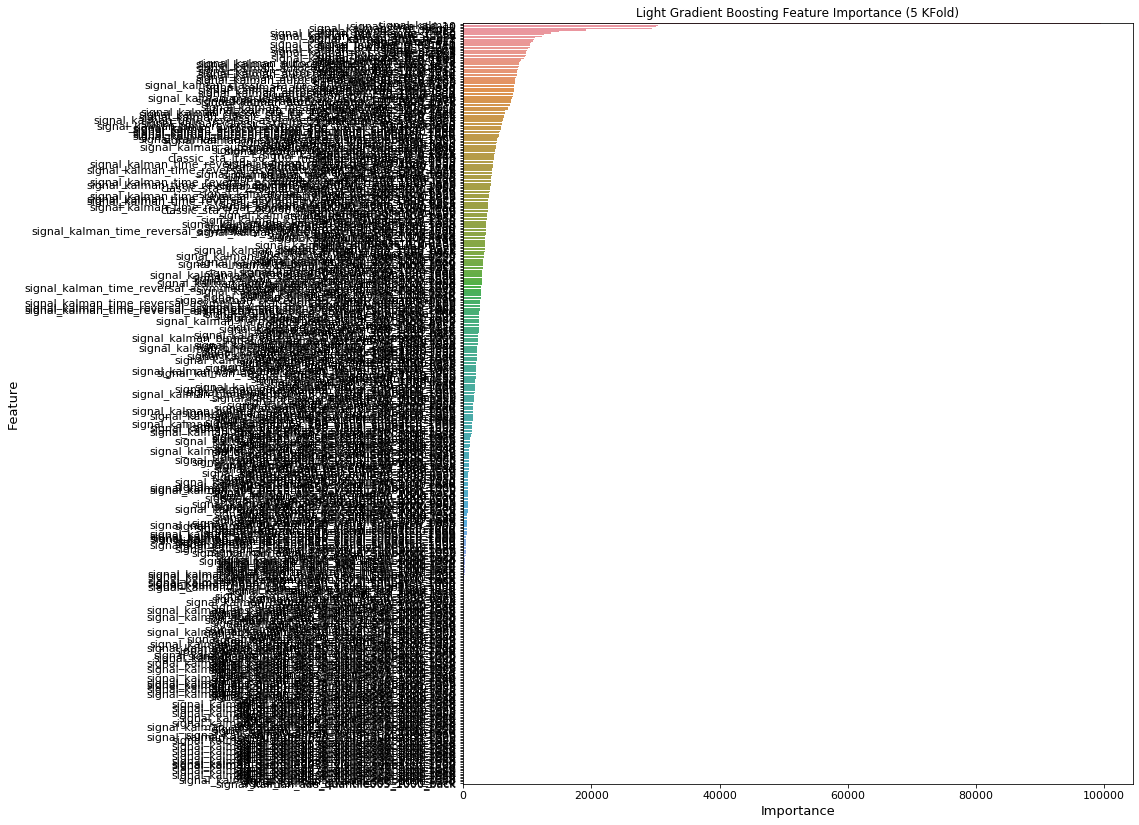

In [20]:
params = {
    'boosting': 'gbdt',
    'objective': 'multiclass',
    'metric': 'softmax',
    'learning_rate': .01,
    'max_depth': 50,    
    'num_leaves': 128,
    'min_data_in_leaf': 20,
    'feature_fraction': 1.,
    'feature_fraction_bynode': 1.,
    'feature_fraction_seed': random_state,
    'bagging_fraction': 1.,
    'bagging_freq': 0,
    'bagging_seed': random_state,
    'max_bin': 255,
    'num_class': 11,
    'is_unbalance': True,
    'random_state': random_state,
    'n_jobs': n_threads
}

target = 'open_channels'

kf = sklearn.model_selection.KFold(
    n_splits=5,
    shuffle=True,
    random_state=random_state
)

oof_pred = np.zeros(len(train))
y_preds_test = []
feature_importance = pd.DataFrame()

for fold, (tr_ind, val_ind) in enumerate(kf.split(train)):

    print('Fold {}'.format(fold + 1))

    X_train_f, X_valid_f = train[feat].iloc[tr_ind], train[feat].iloc[val_ind]
    y_train_f, y_valid_f = train[target][tr_ind], train[target][val_ind]
    
    train_set = lgbm.Dataset(
        data=X_train_f,
        label=y_train_f,
        reference=None,
        weight=None,
        group=None,
        init_score=None,
        silent=False,
        feature_name=feat,
        categorical_feature=cat_feat,
        params=None,
        free_raw_data=False,
    )
    
    del X_train_f
    del y_train_f
    gc.collect()
    
    val_set = lgbm.Dataset(
        data=X_valid_f,
        label=y_valid_f,
        reference=None,
        weight=None,
        group=None,
        init_score=None,
        silent=False,
        feature_name=feat,
        categorical_feature=cat_feat,
        params=None,
        free_raw_data=False,
    )
    
    del X_valid_f
    del y_valid_f
    gc.collect()
    
    evals_result = {}

    model = lgbm.train(
        params,
        train_set=train_set,
        num_boost_round=1000,
        valid_sets=[train_set, val_set],
        valid_names=None,
        #fobj=lgbm_metric,
        feval=None,
        init_model=None,
        #feature_name=feat, #for not lgbm dataset
        #categorical_feature=cat_feat, #for not lgbm dataset
        early_stopping_rounds=10,
        evals_result=evals_result,
        verbose_eval=100,
        learning_rates=None,
        keep_training_booster=False,
        callbacks=None
    )
    
    y_pred_valid = model.predict(
        data=val_set.data,
        num_iteration=model.best_iteration,
        raw_score=False,
        pred_leaf=False,
        pred_contrib=False,
        data_has_header=False,
        is_reshape=True,
    )

    y_pred_test = model.predict(
        data=test_lgbm.data,
        num_iteration=model.best_iteration,
        raw_score=False,
        pred_leaf=False,
        pred_contrib=False,
        data_has_header=False,
        is_reshape=True,
    )

    oof_pred[val_ind] = np.argmax(y_pred_valid, axis=1)
    y_preds_test.append(y_pred_test)

    fold_importance = pd.DataFrame({'features': feat})
    fold_importance['fold'] = fold + 1
    fold_importance['importance'] = model.feature_importance()
    feature_importance = pd.concat([feature_importance, fold_importance])

oof_pred_class = oof_pred
score = sklearn.metrics.f1_score(
    train[target],
    oof_pred_class,
    average='macro'
)
print(
    'F1 Macro oof score is: ',
    score
)

fi_mean = feature_importance.groupby(['features'])['importance'].mean().reset_index()
fi_mean.sort_values('importance', ascending = False, inplace = True)
plt.figure(figsize = (12, 14))
sns.barplot(x = fi_mean['importance'], y = fi_mean['features'])
plt.xlabel('Importance', fontsize = 13)
plt.ylabel('Feature', fontsize = 13)
plt.tick_params(axis = 'x', labelsize = 11)
plt.tick_params(axis = 'y', labelsize = 11)
plt.title('Light Gradient Boosting Feature Importance (5 KFold)')
plt.show()

In [21]:
y_pred_final = np.mean(y_preds_test, axis=0)

In [22]:
y_pred_test_class = np.argmax(y_pred_final, axis=1)
test['open_channels'] = y_pred_test_class

In [23]:
test[['time','open_channels']].to_csv(
    path + 'submission_1_lgbm_classification_5_kfold.csv',
    index=False,
    float_format='%.4f'
)

Fold 1
Training until validation scores don't improve for 10 rounds.
[100]	training's multi_logloss: 0.620702	valid_1's multi_logloss: 0.624413
[200]	training's multi_logloss: 0.274204	valid_1's multi_logloss: 0.280143
[300]	training's multi_logloss: 0.151637	valid_1's multi_logloss: 0.159782
[400]	training's multi_logloss: 0.104363	valid_1's multi_logloss: 0.114838
[500]	training's multi_logloss: 0.0842955	valid_1's multi_logloss: 0.0971632
[600]	training's multi_logloss: 0.0746775	valid_1's multi_logloss: 0.0897704
[700]	training's multi_logloss: 0.0692463	valid_1's multi_logloss: 0.0863713
[800]	training's multi_logloss: 0.0657174	valid_1's multi_logloss: 0.084712
[900]	training's multi_logloss: 0.0631384	valid_1's multi_logloss: 0.0838155
[1000]	training's multi_logloss: 0.0611079	valid_1's multi_logloss: 0.0832839
Did not meet early stopping. Best iteration is:
[1000]	training's multi_logloss: 0.0611079	valid_1's multi_logloss: 0.0832839
Fold 2
Training until validation scores don

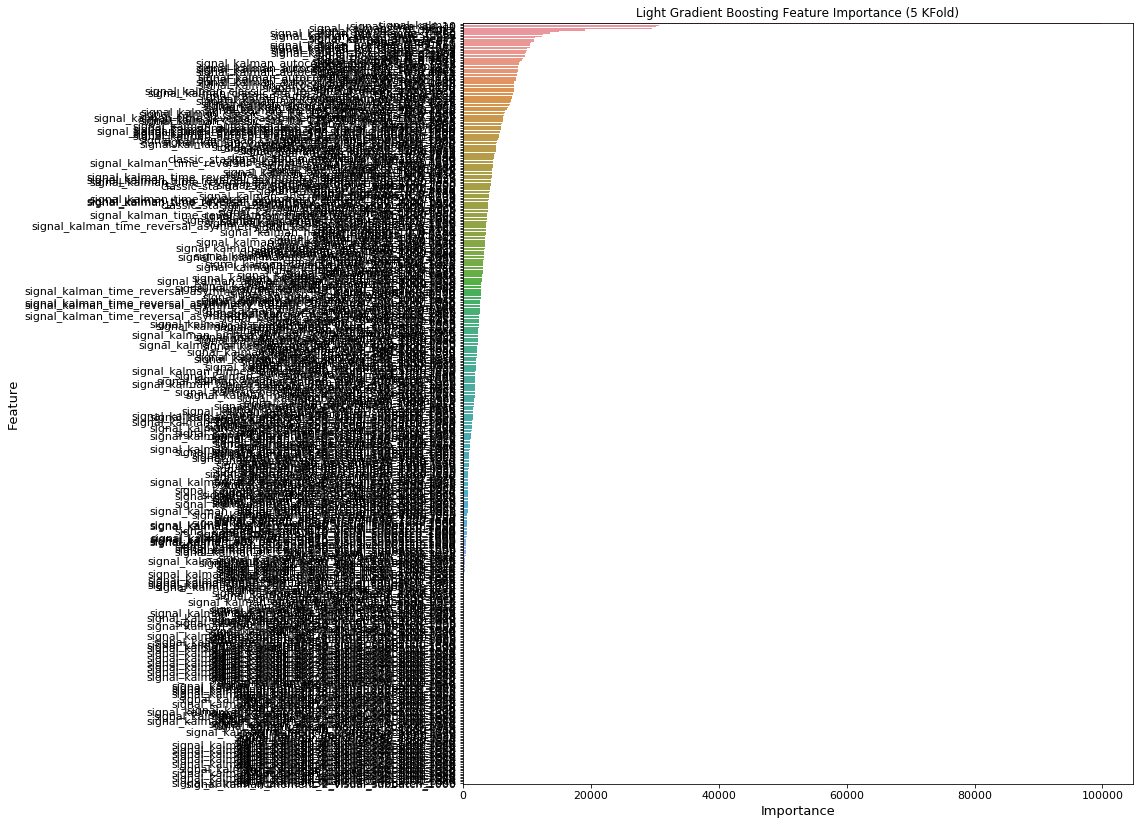

In [22]:
params = {
    'boosting': 'gbdt',
    'objective': 'multiclass',
    'metric': 'softmax',
    'learning_rate': .01,
    'max_depth': 50,    
    'num_leaves': 128,
    'min_data_in_leaf': 20,
    'feature_fraction': 1.,
    'feature_fraction_bynode': 1.,
    'feature_fraction_seed': random_state,
    'bagging_fraction': 1.,
    'bagging_freq': 0,
    'bagging_seed': random_state,
    'max_bin': 255,
    'num_class': 11,
    'is_unbalance': True,
    'random_state': random_state,
    'n_jobs': n_threads
}

target = 'open_channels'

kf = sklearn.model_selection.StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=random_state
)

oof_pred = np.zeros(len(train))
y_preds_test = []
feature_importance = pd.DataFrame()

for fold, (tr_ind, val_ind) in enumerate(kf.split(train, train[target])):

    print('Fold {}'.format(fold + 1))

    X_train_f, X_valid_f = train[feat].iloc[tr_ind], train[feat].iloc[val_ind]
    y_train_f, y_valid_f = train[target][tr_ind], train[target][val_ind]
    
    train_set = lgbm.Dataset(
        data=X_train_f,
        label=y_train_f,
        reference=None,
        weight=None,
        group=None,
        init_score=None,
        silent=False,
        feature_name=feat,
        categorical_feature=cat_feat,
        params=None,
        free_raw_data=False,
    )
    
    del X_train_f
    del y_train_f
    gc.collect()
    
    val_set = lgbm.Dataset(
        data=X_valid_f,
        label=y_valid_f,
        reference=None,
        weight=None,
        group=None,
        init_score=None,
        silent=False,
        feature_name=feat,
        categorical_feature=cat_feat,
        params=None,
        free_raw_data=False,
    )
    
    del X_valid_f
    del y_valid_f
    gc.collect()
    
    evals_result = {}

    model = lgbm.train(
        params,
        train_set=train_set,
        num_boost_round=1000,
        valid_sets=[train_set, val_set],
        valid_names=None,
        #fobj=lgbm_metric,
        feval=None,
        init_model=None,
        #feature_name=feat, #for not lgbm dataset
        #categorical_feature=cat_feat, #for not lgbm dataset
        early_stopping_rounds=10,
        evals_result=evals_result,
        verbose_eval=100,
        learning_rates=None,
        keep_training_booster=False,
        callbacks=None
    )
    
    y_pred_valid = model.predict(
        data=val_set.data,
        num_iteration=model.best_iteration,
        raw_score=False,
        pred_leaf=False,
        pred_contrib=False,
        data_has_header=False,
        is_reshape=True,
    )

    y_pred_test = model.predict(
        data=test_lgbm.data,
        num_iteration=model.best_iteration,
        raw_score=False,
        pred_leaf=False,
        pred_contrib=False,
        data_has_header=False,
        is_reshape=True,
    )

    oof_pred[val_ind] = np.argmax(y_pred_valid, axis=1)
    y_preds_test.append(y_pred_test)

    fold_importance = pd.DataFrame({'features': feat})
    fold_importance['fold'] = fold + 1
    fold_importance['importance'] = model.feature_importance()
    feature_importance = pd.concat([feature_importance, fold_importance])

oof_pred_class = oof_pred
score = sklearn.metrics.f1_score(
    train[target],
    oof_pred_class,
    average='macro'
)
print(
    'F1 Macro oof score is: ',
    score
)

fi_mean = feature_importance.groupby(['features'])['importance'].mean().reset_index()
fi_mean.sort_values('importance', ascending = False, inplace = True)
plt.figure(figsize = (12, 14))
sns.barplot(x = fi_mean['importance'], y = fi_mean['features'])
plt.xlabel('Importance', fontsize = 13)
plt.ylabel('Feature', fontsize = 13)
plt.tick_params(axis = 'x', labelsize = 11)
plt.tick_params(axis = 'y', labelsize = 11)
plt.title('Light Gradient Boosting Feature Importance (5 KFold)')
plt.show()

In [23]:
y_pred_test_final = np.mean(y_preds_test, axis=0)

In [24]:
y_pred_test_class = np.argmax(y_pred_test, axis=1)
test['open_channels'] = y_pred_test_class

In [25]:
test[['time','open_channels']].to_csv(
    path + 'submission_1_lgbm_classification_5_stratifiedkfold.csv',
    index=False,
    float_format='%.4f'
)

Fold 1
Training until validation scores don't improve for 10 rounds.
[100]	training's multi_logloss: 0.621789	valid_1's multi_logloss: 0.621128
[200]	training's multi_logloss: 0.275438	valid_1's multi_logloss: 0.27593
[300]	training's multi_logloss: 0.152888	valid_1's multi_logloss: 0.155226
[400]	training's multi_logloss: 0.105605	valid_1's multi_logloss: 0.110185
[500]	training's multi_logloss: 0.0854864	valid_1's multi_logloss: 0.0925102
[600]	training's multi_logloss: 0.0758419	valid_1's multi_logloss: 0.0851692
[700]	training's multi_logloss: 0.07039	valid_1's multi_logloss: 0.0818175
[800]	training's multi_logloss: 0.0668506	valid_1's multi_logloss: 0.0802211
[900]	training's multi_logloss: 0.064243	valid_1's multi_logloss: 0.0793958
[1000]	training's multi_logloss: 0.0622415	valid_1's multi_logloss: 0.0789572
Did not meet early stopping. Best iteration is:
[1000]	training's multi_logloss: 0.0622415	valid_1's multi_logloss: 0.0789572
Fold 2
Training until validation scores don't 

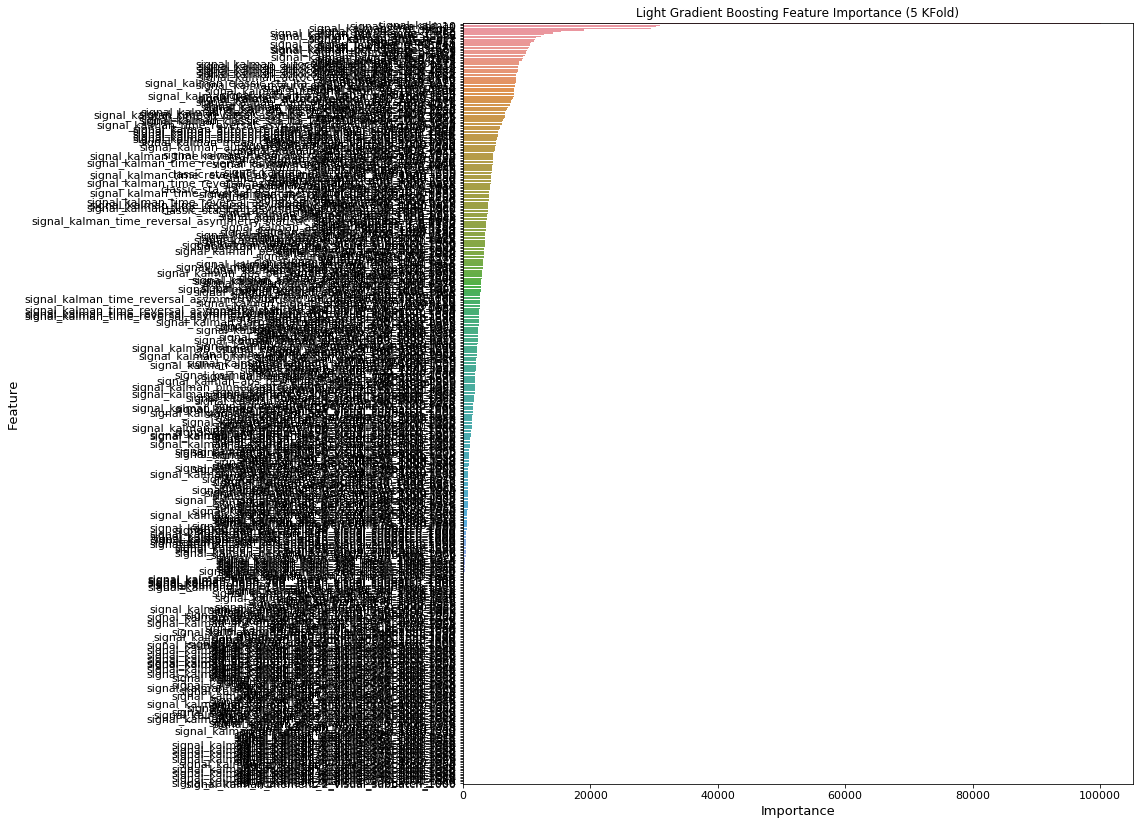

In [21]:
params = {
    'boosting': 'gbdt',
    'objective': 'multiclass',
    'metric': 'softmax',
    'learning_rate': .01,
    'max_depth': 50,    
    'num_leaves': 128,
    'min_data_in_leaf': 20,
    'feature_fraction': 1.,
    'feature_fraction_bynode': 1.,
    'feature_fraction_seed': random_state,
    'bagging_fraction': 1.,
    'bagging_freq': 0,
    'bagging_seed': random_state,
    'max_bin': 255,
    'num_class': 11,
    'is_unbalance': True,
    'random_state': random_state,
    'n_jobs': n_threads
}

target = 'open_channels'

splits = 5

groups = np.tile(np.arange(splits).repeat(500000 // splits), 10)
kf = sklearn.model_selection.GroupKFold(
    n_splits=splits
)

oof_pred = np.zeros(len(train))
y_preds_test = []
feature_importance = pd.DataFrame()

for fold, (tr_ind, val_ind) in enumerate(kf.split(train, train[target], groups=groups)):

    print('Fold {}'.format(fold + 1))

    X_train_f, X_valid_f = train[feat].iloc[tr_ind], train[feat].iloc[val_ind]
    y_train_f, y_valid_f = train[target][tr_ind], train[target][val_ind]

    train_set = lgbm.Dataset(
        data=X_train_f,
        label=y_train_f,
        reference=None,
        weight=None,
        group=None,
        init_score=None,
        silent=False,
        feature_name=feat,
        categorical_feature=cat_feat,
        params=None,
        free_raw_data=False,
    )
    
    del X_train_f
    del y_train_f
    gc.collect()
    
    val_set = lgbm.Dataset(
        data=X_valid_f,
        label=y_valid_f,
        reference=None,
        weight=None,
        group=None,
        init_score=None,
        silent=False,
        feature_name=feat,
        categorical_feature=cat_feat,
        params=None,
        free_raw_data=False,
    )
    
    del X_valid_f
    del y_valid_f
    gc.collect()
    
    evals_result = {}

    model = lgbm.train(
        params,
        train_set=train_set,
        num_boost_round=1000,
        valid_sets=[train_set, val_set],
        valid_names=None,
        #fobj=lgbm_metric,
        feval=None,
        init_model=None,
        #feature_name=feat, #for not lgbm dataset
        #categorical_feature=cat_feat, #for not lgbm dataset
        early_stopping_rounds=10,
        evals_result=evals_result,
        verbose_eval=100,
        learning_rates=None,
        keep_training_booster=False,
        callbacks=None
    )
    
    y_pred_valid = model.predict(
        data=val_set.data,
        num_iteration=model.best_iteration,
        raw_score=False,
        pred_leaf=False,
        pred_contrib=False,
        data_has_header=False,
        is_reshape=True,
    )

    y_pred_test = model.predict(
        data=test_lgbm.data,
        num_iteration=model.best_iteration,
        raw_score=False,
        pred_leaf=False,
        pred_contrib=False,
        data_has_header=False,
        is_reshape=True,
    )

    oof_pred[val_ind] = np.argmax(y_pred_valid, axis=1)
    y_preds_test.append(y_pred_test)

    fold_importance = pd.DataFrame({'features': feat})
    fold_importance['fold'] = fold + 1
    fold_importance['importance'] = model.feature_importance()
    feature_importance = pd.concat([feature_importance, fold_importance])

oof_pred_class = oof_pred
score = sklearn.metrics.f1_score(
    train[target],
    oof_pred_class,
    average='macro'
)
print(
    'F1 Macro oof score is: ',
    score
)

fi_mean = feature_importance.groupby(['features'])['importance'].mean().reset_index()
fi_mean.sort_values('importance', ascending = False, inplace = True)
plt.figure(figsize = (12, 14))
sns.barplot(x = fi_mean['importance'], y = fi_mean['features'])
plt.xlabel('Importance', fontsize = 13)
plt.ylabel('Feature', fontsize = 13)
plt.tick_params(axis = 'x', labelsize = 11)
plt.tick_params(axis = 'y', labelsize = 11)
plt.title('Light Gradient Boosting Feature Importance (5 KFold)')
plt.show()

In [22]:
y_pred_test_final = np.mean(y_preds_test, axis=0)

In [23]:
y_pred_test_class = np.argmax(y_pred_test, axis=1)
test['open_channels'] = y_pred_test_class

In [24]:
test[['time','open_channels']].to_csv(
    path + 'submission_1_lgbm_classification_5_groupkfold.csv',
    index=False,
    float_format='%.4f'
)

### Mean models with cv

In [ ]:
oof_preds = []
y_preds_test_ = []
target = 'open_channels'

for i in range(3):

    random_state_new = random_state + i
    
    params = {
        'boosting': 'gbdt',
        'objective': 'multiclass',
        'metric': 'softmax',
        'learning_rate': .01,
        'max_depth': 50,    
        'num_leaves': 128,
        'min_data_in_leaf': 20,
        'feature_fraction': 1.,
        'feature_fraction_bynode': 1.,
        'feature_fraction_seed': random_state,
        'bagging_fraction': 1.,
        'bagging_freq': 0,
        'bagging_seed': random_state,
        'max_bin': 255,
        'num_class': 11,
        'is_unbalance': True,
        'random_state': random_state,
        'n_jobs': n_threads
    }

    kf = sklearn.model_selection.StratifiedKFold(
        n_splits=5,
        shuffle=True,
        random_state=random_state_new
    )
    
    oof_pred = np.zeros(len(train))
    #y_pred = np.zeros(len(test))
    y_preds_test = []
    #feature_importance = pd.DataFrame()

    for fold, (tr_ind, val_ind) in enumerate(kf.split(train, train[target])):

        print('Fold {}'.format(fold + 1))

        X_train_f, X_valid_f = train[feat].iloc[tr_ind], train[feat].iloc[val_ind]
        y_train_f, y_valid_f = train[target][tr_ind], train[target][val_ind]

        train_set = lgbm.Dataset(
            data=X_train_f,
            label=y_train_f,
            reference=None,
            weight=None,
            group=None,
            init_score=None,
            silent=False,
            feature_name=feat,
            categorical_feature=cat_feat,
            params=None,
            free_raw_data=False,
        )

        val_set = lgbm.Dataset(
            data=X_valid_f,
            label=y_valid_f,
            reference=None,
            weight=None,
            group=None,
            init_score=None,
            silent=False,
            feature_name=feat,
            categorical_feature=cat_feat,
            params=None,
            free_raw_data=False,
        )
        
        evals_result = {}

        model = lgbm.train(
            params,
            train_set=train_set,
            num_boost_round=2,
            valid_sets=[train_set, val_set],
            valid_names=None,
            fobj=None,
            feval=lgbm_metric,
            init_model=None,
            #feature_name=feat, #for not lgbm dataset
            #categorical_feature=cat_feat, #for not lgbm dataset
            early_stopping_rounds=1,
            evals_result=evals_result,
            verbose_eval=50,
            learning_rates=None,
            keep_training_booster=False,
            callbacks=None
        )

        y_pred_valid = model.predict(
            data=val_set.data,
            num_iteration=model.best_iteration,
            raw_score=False,
            pred_leaf=False,
            pred_contrib=False,
            data_has_header=False,
            is_reshape=True,
        )

        y_pred_test = model.predict(
            data=test_lgbm.data,
            num_iteration=model.best_iteration,
            raw_score=False,
            pred_leaf=False,
            pred_contrib=False,
            data_has_header=False,
            is_reshape=True,
        )

        oof_pred[val_ind] = np.argmax(y_pred_valid, axis=1)
        y_preds_test.append(y_pred_test)
        
    oof_preds.append(oof_pred)
    oof_pred_clipped = np.round(np.clip(oof_pred, 0, 10)).astype(int)

    y_pred_test_final = np.mean(y_preds_test, axis=0)
    y_preds_test_.append(y_pred_test_final)
    
    score = sklearn.metrics.f1_score(
        train[target],
        oof_pred_clipped,
        average='macro'
    )
    
    print(
        'random_state: ',
        random_state + i,
        'F1 Macro oof score is: ',
        score
    )

In [ ]:
oof_pred_final = np.mean(oof_preds, axis=0)
oof_pred_final_class = np.argmax(oof_pred_final, axis=1)

In [ ]:
sklearn.metrics.f1_score(
    train[target],
    oof_pred_final_clipped,
    average='macro'
)

In [ ]:
y_pred_final = np.mean(y_preds_test_, axis=0)
y_pred_final_class = np.argmax(y_pred_final, axis=1)

In [ ]:
test['open_channels'] = y_pred_final_class

In [ ]:
test[['time','open_channels']].to_csv(
    path + 'submission_3_lgbm_5_stratified_kfold_optimized_round.csv',
    index=False,
    float_format='%.4f'
)

### Searching the best depth

In [ ]:
target = 'open_channels'

kf = sklearn.model_selection.StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=random_state
)

train_results = []
valid_results = []

depths = [2, 4, 8, 16, 32, 64, -1]
num_leaves_ = [4, 16, 64, 128, 128, 128, 128]

for d, n_l in tqdm.tqdm_notebook(zip(depths, num_leaves_)):

    params = {
        'boosting': 'gbdt',
        'objective': 'rmse',
        'metric': 'rmse',
        'learning_rate': .1,
        'max_depth': d,    
        'num_leaves': n_l,
        'min_data_in_leaf': 20,
        'feature_fraction': 1.,
        'feature_fraction_bynode': 1.,
        'feature_fraction_seed': random_state,
        'bagging_fraction': 1.,
        'bagging_freq': 0,
        'bagging_seed': random_state,
        'max_bin': 255,
        'random_state': random_state,
        'n_jobs': n_threads
    }

    oof_pred = np.zeros(len(train))

    for fold, (tr_ind, val_ind) in enumerate(kf.split(train, train[target])):

        #print('Fold {}'.format(fold + 1))

        X_train_f, X_valid_f = train[feat].iloc[tr_ind], train[feat].iloc[val_ind]
        y_train_f, y_valid_f = train[target][tr_ind], train[target][val_ind]

        train_set = lgbm.Dataset(
            data=X_train_f,
            label=y_train_f,
            reference=None,
            weight=None,
            group=None,
            init_score=None,
            silent=False,
            feature_name=feat,
            categorical_feature=cat_feat,
            params=None,
            free_raw_data=False,
        )

        val_set = lgbm.Dataset(
            data=X_valid_f,
            label=y_valid_f,
            reference=None,
            weight=None,
            group=None,
            init_score=None,
            silent=False,
            feature_name=feat,
            categorical_feature=cat_feat,
            params=None,
            free_raw_data=False,
        )
    
        evals_result = {}
    
        model = lgbm.train(
            params,
            train_set=train_set,
            num_boost_round=500,
            valid_sets=[train_set, val_set],
            valid_names=None,
            fobj=None,
            feval=lgbm_metric,
            init_model=None,
            #feature_name=feat, #for not lgbm dataset
            #categorical_feature=cat_feat, #for not lgbm dataset
            early_stopping_rounds=10,
            evals_result=evals_result,
            verbose_eval=False,
            learning_rates=None,
            keep_training_booster=False,
            callbacks=None
        )

        y_pred_train = model.predict(
            data=train[feat],
            num_iteration=model.best_iteration,
            raw_score=False,
            pred_leaf=False,
            pred_contrib=False,
            data_has_header=False,
            is_reshape=True,
        )

        y_pred_valid = model.predict(
            data=val_set.data,
            num_iteration=model.best_iteration,
            raw_score=False,
            pred_leaf=False,
            pred_contrib=False,
            data_has_header=False,
            is_reshape=True,
        )
        
        oof_pred[val_ind] = y_pred_valid
        y_preds_train.append(y_pred_train)
        
    y_pred_train_final = np.mean(y_preds_train, axis=0)
    y_pred_train_final_class = np.argmax(y_pred_train_final, axis=1)
    train_results.append(
        sklearn.metrics.f1_score(
            train[target],
            y_pred_train_final_class,
            average='macro')
    )

    y_pred_valid_final_class = np.argmax(oof_pred, axis=1)
    valid_results.append(
        sklearn.metrics.f1_score(
            train[target],
            y_pred_valid_final_class,
            average='macro')
    )

plot_vc(
    x=[d for d in depths],
    y_train=train_results,
    y_valid=valid_results,
    xlabel='DEPTH',
    title='F1 Macro'
)

# Catboost

## Regression

In [ ]:
model = ctbst.CatBoostRegressor(
    task_type = "CPU",
    iterations=1000,
    learning_rate=0.1,
    random_seed = 42,
    depth=2
)

model.fit(
    x1,
    y1
)

In [ ]:
preds_catb = model.predict(test[col])
test['open_channels'] = np.round(np.clip(preds_catb, 0, 10)).astype(int)

In [ ]:
preds_comb = 0.78 * preds + 0.22 * preds_catb
test['open_channels'] = np.round(np.clip(preds_comb, 0, 10)).astype(int)

In [ ]:
test[['time','open_channels']].to_csv('submission.csv', index=False, float_format='%.4f')